## KAN RL

In [1]:
!pip install gymnasium pykan~=0.0.2

## Models

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14217578.49it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 423110.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4039802.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2413903.80it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

State shape: torch.Size([1, 8, 8])
Label: tensor(9)
Feedback shape: torch.Size([1, 8, 8])


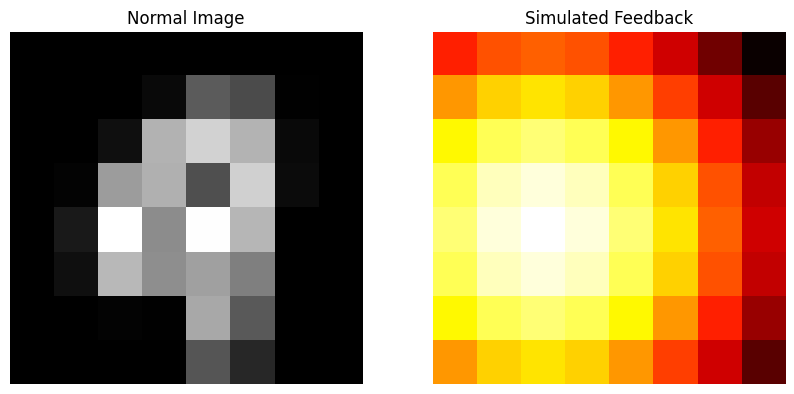

tensor(0.4404) tensor(1.)


In [2]:
# @title

import torch
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

class MNISTEnvironment:
    def __init__(self, batch_size, image_size=(8, 8), feedback_sigma=5.0):
        self.batch_size = batch_size
        self.image_size = image_size
        self.feedback_sigma = feedback_sigma
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        dataset = MNIST('./data', train=True, download=True, transform=self.transform)
        self.loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.iterator = iter(self.loader)
        self.reset()

    def reset(self):
        try:
            self.current_batch = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.loader)
            self.current_batch = next(self.iterator)
        self.idx = 0

    def step(self):
        images, labels = self.current_batch
        if self.idx >= len(images):
            self.reset()
            return self.step()
        state = images[self.idx]
        label = labels[self.idx]
        feedback = self.generate_simulated_feedback(state.unsqueeze(0))
        self.idx += 1
        return state, label, feedback

    def generate_simulated_feedback(self, image_tensor):
        image_np = image_tensor.squeeze().numpy()

        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

        center_of_mass = np.array(np.unravel_index(np.argmax(image_np), image_np.shape))

        x, y = np.meshgrid(np.arange(image_np.shape[1]), np.arange(image_np.shape[0]))
        gaussian_mask = np.exp(-((x - center_of_mass[1])**2 + (y - center_of_mass[0])**2) / (2 * self.feedback_sigma**2))

        feedback = gaussian_mask / np.max(gaussian_mask)
        return torch.tensor(feedback, dtype=torch.float32).view(1, *feedback.shape)


def plot_images(normal_image, feedback_image):
    # Convert tensors to numpy arrays
    normal_image_np = normal_image.squeeze().numpy()
    feedback_image_np = feedback_image.squeeze().numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot normal image
    axes[0].imshow(normal_image_np, cmap='gray')
    axes[0].set_title('Normal Image')
    axes[0].axis('off')

    # Plot feedback image
    axes[1].imshow(feedback_image_np, cmap='hot')  # Using 'jet' colormap to visualize feedback
    axes[1].set_title('Simulated Feedback')
    axes[1].axis('off')

    plt.show()


# Example usage:
if __name__ == "__main__":
    env = MNISTEnvironment(batch_size=1, feedback_sigma=5.0)
    state, label, feedback = env.step()
    print("State shape:", state.shape)
    print("Label:", label)
    print("Feedback shape:", feedback.shape)
    plot_images(state, feedback)
    print(feedback.min(), feedback.max())

In [3]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.optim.lr_scheduler import ExponentialLR

class FSNet(nn.Module):
    def __init__(self, input_shape, num_filters, num_conv_layers=3, hidden_dim=128, distribution=None, tau=1.0):
        super(FSNet, self).__init__()

        self.distribution = distribution
        self.global_step = 0
        self.initial_tau = tau
        self.tau_decay = 0.96  # Exponential decay rate

        layers = []
        in_channels = input_shape[0]
        channels = []

        for i in range(num_conv_layers):
            num_filters *= 2
            channels.append(num_filters)

        for i in range(num_conv_layers):
            # For a convolutional layer to keep the input and output shapes the same: P = (K-1)/2 with S = 1
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=channels[i], kernel_size=3, padding=1, stride=1))
            layers.append(nn.ReLU())
            # Each MaxPool2d layer with kernel size 2 and stride 2 will halve the height and width of the feature maps.
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = channels[i]

        layers.append(nn.Flatten())
        self.feature_extractor = nn.Sequential(*layers)

        # Dummy forward pass to determine the output size of the feature extractor
        dummy_input = torch.empty(1, *input_shape)
        n_features = self.feature_extractor(dummy_input).shape[1]
        # print(n_features)

        self.fc1 = nn.Linear(n_features, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_dim, n_features)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)

        # Storage for probabilities and feedback costs
        self.probs_history = []
        self.feedback_cost_history = []


    def forward(self, x, feedback=None, epoch=0, n_epochs=None):
        x = x.view(-1, 1, input_shape[1], input_shape[2])
        features = self.feature_extractor(x)

        x = self.relu(self.fc1(features))
        probs_logits = self.relu(self.fc2(x))
        probs = self.sigmoid(probs_logits)

        # Apply the simulated feedback as a weight to the feature selection
        if feedback is None:
            feedback = probs # so that mse_loss becomes 0 if no feedback is fed
        else:
            pass

        # Use distribution as weight of the features
        if self.distribution == 'bernoulli':
            mask = torch.distributions.Bernoulli(logits=probs_logits)
            sample_probs = mask.sample()
        if self.distribution == 'gumbel_softmax':
            tau = self.initial_tau * (self.tau_decay ** epoch)
            mask = F.gumbel_softmax(logits=probs_logits, tau=tau, hard=False)
            sample_probs = mask
        if self.distribution == 'gaussian':
            mu = probs_logits  # or some transformation of probs_logits
            sigma = torch.ones_like(mu)  # Standard deviation
            gaussian_dist = torch.distributions.Normal(mu, sigma)
            sample_probs = gaussian_dist.rsample()  # Use rsample for the reparameterization trick
        if self.distribution == 'beta':
            alpha = F.softplus(probs_logits) + 1
            beta = F.softplus(probs_logits) + 1
            beta_dist = torch.distributions.Beta(alpha, beta)
            sample_probs = beta_dist.sample()
        if self.distribution == 'dirichlet':
            concentration = F.softplus(probs_logits) + 1  # Ensuring positive values
            dirichlet_dist = torch.distributions.Dirichlet(concentration)
            sample_probs = dirichlet_dist.sample()
        elif self.distribution == 'multinomial':
            logits = probs_logits  # Logits for the multinomial distribution
            mask = torch.distributions.Multinomial(logits=logits)
            sample_probs = mask.sample()
        elif self.distribution == 'laplace':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            laplace_dist = torch.distributions.Laplace(loc, scale)
            sample_probs = laplace_dist.sample()
        elif self.distribution == 'cauchy':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            cauchy_dist = torch.distributions.Cauchy(loc, scale)
            sample_probs = cauchy_dist.sample()
        elif self.distribution == 'uniform':
            low = torch.zeros_like(probs_logits)  # Lower bound
            high = torch.ones_like(probs_logits)  # Upper bound
            uniform_dist = torch.distributions.Uniform(low, high)
            sample_probs = uniform_dist.sample()

        # print(sample_probs.shape)

        feedback_cost = F.mse_loss(probs, feedback)

        flat_zoom_X = features * sample_probs

        return flat_zoom_X, feedback_cost, probs


# Example usage:
input_shape = (1, 8, 8)  # Change this to the desired input shape
num_conv_layers = 2  # Specify the desired number of convolutional layers
num_filters = 4 # [2,4], [3,8]
model = FSNet(input_shape, num_filters, num_conv_layers, hidden_dim=128, distribution='uniform')
print(model)

# Test with an example input
example_input = torch.randn(*input_shape)

# print(flat_zoom_X, probs)
# print(flat_zoom_X.shape[1])
flat_zoom_X, feedback_cost, probs = model.forward(example_input)


FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)


In [4]:
# @title
from collections import deque
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from kan import KAN
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Callable, Union

class ReplayBuffer:
    def __init__(self, capacity, observation_dim):
        self.capacity = capacity
        self.observations = torch.zeros(capacity, observation_dim)
        self.actions = torch.zeros(capacity, 1, dtype=torch.int64)
        self.next_observations = torch.zeros(capacity, observation_dim)
        self.rewards = torch.zeros(capacity, 1)
        self.terminations = torch.zeros(capacity, 1, dtype=torch.int)
        self.cursor = 0

    def add(self, observation, action, next_observation, reward, termination):
        index = self.cursor % self.capacity
        self.observations[index] = observation
        self.actions[index] = action
        self.next_observations[index] = next_observation
        self.rewards[index] = reward
        self.terminations[index] = termination
        self.cursor += 1

    def sample(self, batch_size):
        idx = np.random.permutation(np.arange(len(self)))[:batch_size]
        return (
            self.observations[idx],
            self.actions[idx],
            self.next_observations[idx],
            self.rewards[idx],
            self.terminations[idx],
        )

    def __len__(self):
        return min(self.cursor, self.capacity)



def kan_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    lamb=0.0,
    lamb_l1=1.0,
    lamb_entropy=2.0,
    lamb_coef=0.0,
    lamb_coefdiff=0.0,
    small_mag_threshold=1e-16,
    small_reg_factor=1.0,
    feedback_cost=None,
    feature_selection=False,
):
    

    def reg(acts_scale):
        def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
            return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

        reg_ = 0.0
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(
                -1,
            )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = -torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for i in range(len(net.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(net.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(
                torch.mean(torch.abs(torch.diff(net.act_fun[i].coef)), dim=1)
            )
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

        return reg_

    observations, actions, next_observations, rewards, terminations = data

    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )


    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    # loss = criterion(td_target, old_val)
    reg_ = reg(net.acts_scale)
    loss = criterion(td_target, old_val) + lamb * reg_

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
        combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
        combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()

def mlp_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    feedback_cost=None,
    feature_selection=False,
):
    observations, actions, next_observations, rewards, terminations = data

    # Compute everything related to primary loss in a single block to retain the graph
    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )

    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    loss = criterion(td_target, old_val)

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
      combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
      combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

2024-08-15 16:47:07.210470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 16:47:07.210637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 16:47:07.387655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# @title
import os
import time
import random
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm

def kanRL(config):
      set_all_seeds(config["seed"])
      env = MNISTEnvironment(config["batch_size"])
      results_dir = 'results'

      # Check if the directory exists before trying to delete it
      # if os.path.exists(results_dir) and os.path.isdir(results_dir):
      #     shutil.rmtree(results_dir)
      #     print(f"Directory '{results_dir}' has been deleted.")
      # else:
      #     print(f"Directory '{results_dir}' does not exist.")

      input_shape = (config['first_channel'], int(config['input_size']**0.5), int(config['input_size']**0.5))  # Change this to the desired input shape
      print(input_shape)
      agent = FSNet(input_shape, config['num_filters'], config['num_conv_layers'], config['hidden_dim'], distribution=config['distribution'], tau=config['initial_tau'])
      print(agent)

      if config["feature_selection"] == True:
          example_input = torch.randn(*input_shape)
          features, _, _ = agent(example_input)
          n_features = features.shape[1]
          print(n_features)
      else:
          n_features = config["input_size"]

      if config["method"] == "KAN":
          q_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          target_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          train = kan_train
      elif config["method"] == "MLP":
          q_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          target_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          train = mlp_train
      else:
          raise Exception(
              f"Method {config['method']} doesn't exist, choose between MLP and KAN."
          )

      target_network.load_state_dict(q_network.state_dict())

      run_name = f"{config['method']}_MNIST_{config['seed']}_{int(time.time())}"

      writer = SummaryWriter(f"runs/{run_name}")

      os.makedirs("results", exist_ok=True)
      with open(f"results/{run_name}.csv", "w") as f:
          f.write("epoch,accuracy\n")


      optimizer = optim.Adam(list(agent.parameters())+list(q_network.parameters()), lr = config["learning_rate"], weight_decay = config["weight_decay"])
      # Define learning rate scheduler
      scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'])

      writer.add_text(
          "hyperparameters",
          "|param|value|\n|-|-|\n%s"
          % ("\n".join([f"|{key}|{value}|" for key, value in config.items()])),
      )

      replay_buffer = ReplayBuffer(config["buffer_size"], n_features) # change here if the input size changes

      train_accuracies = []
      test_accuracies = []
      train_acc_stds = []
      test_acc_stds = []
      episode_lengths = []
      losses = []
      loss_stds = []
      probs_history = []
      feedback_cost_history = []

      # Training phase
      for epoch in tqdm(range(config["n_epochs"]), desc=f"{run_name}"):
          running_loss = 0.0
          correct = 0
          total = 0
          probs_batch_list = []
          feedback_cost_tot = 0

          for _ in range(len(env.loader)):
              state, label, feedback = env.step()
              feedback = feedback.view(-1, config['input_size'])
              
              if config["feature_selection"] == True:
                  flat_zoom_X, feedback_cost, probs = agent.forward(state, feedback, epoch, config["n_epochs"])
                  # Collect the probabilities and feedback costs
                  probs_batch_list.append(probs.detach().cpu().numpy())
                  feedback_cost_tot += feedback_cost.detach().cpu().numpy()
                  # Calculate regularization loss
                  state = flat_zoom_X
              else:
                  state = state.view(-1, config['input_size'])
                  probs_batch_list.append(torch.zeros((1, int(config['input_size']))))
                  probs = torch.zeros((1, int(config['input_size'])))
                  feedback_cost = torch.zeros(1)
                  feedback_cost_tot += torch.zeros(1)                

              # Forward pass
              if epoch < config["warm_up_episodes"]:
                  action = torch.tensor([random.randint(0, 9)])
              else:
                  with torch.no_grad():
                      action = q_network(state).argmax(axis=-1).squeeze().item()

              reward = torch.tensor([1.0]) if action == label else torch.tensor([0.0])
              next_state, next_label, _ = env.step()
              if config["feature_selection"] == True:
                  next_state, _, _ = agent.forward(next_state)
              else:
                  next_state = next_state.view(-1, config['input_size'])

              replay_buffer.add(state, action, next_state, reward, torch.tensor([1]))

              if len(replay_buffer) > config["batch_size"]:
                  batch = replay_buffer.sample(config["batch_size"])
                  loss = train(
                      q_network,
                      target_network,
                      batch,
                      optimizer,
                      gamma=config["gamma"],
                      feedback_cost = feedback_cost,
                      feature_selection = config['feature_selection'],
                  )
                  running_loss += loss

              correct += (action == label).sum().item()
              total += 1

          scheduler.step()
          print()
          print('correct:', correct, 'total:', total)
          print('loss:', running_loss/total)
          train_accuracy = correct / total
          print(' Train accuracy: ', train_accuracy, '| ')
          train_accuracies.append(train_accuracy)
          losses.append(running_loss/total)

          # Aggregate probabilities by averaging across the batch
          avg_probs = np.mean(np.array(probs_batch_list), axis=0)
          probs_history.append(avg_probs)
          # Compute feedback cost
          feedback_cost_history.append(feedback_cost_tot / len(env.loader))

          if (
              epoch % 25 == 0
              and config["method"] == "KAN"
              and epoch < int(config["n_epochs"] * (1 / 2))
          ):
              q_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])
              target_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])

          if epoch % config["target_update"] == 0:
              target_network.load_state_dict(q_network.state_dict())

          correct = 0
          total = 0
          with torch.no_grad():
              for images, labels in DataLoader(MNIST('./data', train=False, download=True, transform=transforms.Compose([
                  transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
                  transforms.ToTensor(),
                  transforms.Normalize((0.1307,), (0.3081,))
              ])), batch_size=config["batch_size"]):
                  state = images.view(-1,config["input_size"])
                  
                  if config["feature_selection"] == True:
                      flat_zoom_X, _, _ = agent(state)
                      state = flat_zoom_X

                  outputs = q_network(state)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

          test_accuracy = correct / total
          print(' Test accuracy: ', test_accuracy)
          test_accuracies.append(test_accuracy)

          writer.add_scalar("Loss/train", running_loss / total, epoch)
          writer.add_scalar("Accuracy/train", train_accuracy, epoch)
          writer.add_scalar("Accuracy/test", test_accuracy, epoch)

          with open(f"results/{run_name}.csv", "a") as f:
              f.write(f"{epoch},{test_accuracy}\n")


      # Calculate standard deviations
      train_acc_stds = [np.std(train_accuracies[max(0, i-10):i+1]) for i in range(len(train_accuracies))]
      test_acc_stds = [np.std(test_accuracies[max(0, i-10):i+1]) for i in range(len(test_accuracies))]
      loss_stds = [np.std(losses[max(0, i-10):i+1]) for i in range(len(losses))]

      epochs = np.arange(len(train_accuracies))

      #### With uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.fill_between(epochs, np.array(train_accuracies) - np.array(train_acc_stds), np.array(train_accuracies) + np.array(train_acc_stds), alpha=0.3)
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.fill_between(epochs, np.array(test_accuracies) - np.array(test_acc_stds), np.array(test_accuracies) + np.array(test_acc_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.fill_between(epochs, np.array(losses) - np.array(loss_stds), np.array(losses) + np.array(loss_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()


      ##### Without uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()

      # Print final accuracy with +/- error
      final_train_accuracy = train_accuracies[-1]
      final_train_acc_std = train_acc_stds[-1]
      final_test_accuracy = test_accuracies[-1]
      final_test_acc_std = test_acc_stds[-1]

      print(f"Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
      print(f"Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")


      return q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent

# All distributions

https://pytorch.org/docs/stable/distributions.html#laplace

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1723740440:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.05651204181568963
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723740440:   1%|          | 1/100 [00:04<07:52,  4.78s/it]

 Test accuracy:  0.1927

correct: 48 total: 469
loss: 0.07333932105285018
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723740440:   2%|▏         | 2/100 [00:09<08:00,  4.90s/it]

 Test accuracy:  0.2569

correct: 129 total: 469
loss: 0.08246902362115856
 Train accuracy:  0.27505330490405117 | 


MLP_MNIST_0_1723740440:   3%|▎         | 3/100 [00:14<08:03,  4.99s/it]

 Test accuracy:  0.3103

correct: 146 total: 469
loss: 0.09104245327619602
 Train accuracy:  0.31130063965884863 | 


MLP_MNIST_0_1723740440:   4%|▍         | 4/100 [00:19<08:02,  5.03s/it]

 Test accuracy:  0.3406

correct: 161 total: 469
loss: 0.09582742921579113
 Train accuracy:  0.34328358208955223 | 


MLP_MNIST_0_1723740440:   5%|▌         | 5/100 [00:25<08:02,  5.08s/it]

 Test accuracy:  0.3585

correct: 186 total: 469
loss: 0.10158205302412322
 Train accuracy:  0.39658848614072495 | 


MLP_MNIST_0_1723740440:   6%|▌         | 6/100 [00:30<08:05,  5.17s/it]

 Test accuracy:  0.3715

correct: 175 total: 469
loss: 0.10657763288918334
 Train accuracy:  0.373134328358209 | 


MLP_MNIST_0_1723740440:   7%|▋         | 7/100 [00:36<08:13,  5.31s/it]

 Test accuracy:  0.3902

correct: 193 total: 469
loss: 0.1102904118200355
 Train accuracy:  0.4115138592750533 | 


MLP_MNIST_0_1723740440:   8%|▊         | 8/100 [00:41<08:18,  5.42s/it]

 Test accuracy:  0.3944

correct: 171 total: 469
loss: 0.11313658453889493
 Train accuracy:  0.3646055437100213 | 


MLP_MNIST_0_1723740440:   9%|▉         | 9/100 [00:47<08:10,  5.39s/it]

 Test accuracy:  0.4027

correct: 178 total: 469
loss: 0.11531418499979637
 Train accuracy:  0.3795309168443497 | 


MLP_MNIST_0_1723740440:  10%|█         | 10/100 [00:52<08:05,  5.39s/it]

 Test accuracy:  0.4115

correct: 183 total: 469
loss: 0.11769510476764586
 Train accuracy:  0.39019189765458423 | 


MLP_MNIST_0_1723740440:  11%|█         | 11/100 [00:57<07:58,  5.38s/it]

 Test accuracy:  0.4161

correct: 193 total: 469
loss: 0.11863152271331247
 Train accuracy:  0.4115138592750533 | 


MLP_MNIST_0_1723740440:  12%|█▏        | 12/100 [01:03<07:53,  5.38s/it]

 Test accuracy:  0.4215

correct: 197 total: 469
loss: 0.1205178269985388
 Train accuracy:  0.4200426439232409 | 


MLP_MNIST_0_1723740440:  13%|█▎        | 13/100 [01:08<07:56,  5.48s/it]

 Test accuracy:  0.4253

correct: 188 total: 469
loss: 0.12140598233892465
 Train accuracy:  0.40085287846481876 | 


MLP_MNIST_0_1723740440:  14%|█▍        | 14/100 [01:14<07:49,  5.46s/it]

 Test accuracy:  0.4254

correct: 206 total: 469
loss: 0.12262133712262742
 Train accuracy:  0.43923240938166314 | 


MLP_MNIST_0_1723740440:  15%|█▌        | 15/100 [01:19<07:43,  5.45s/it]

 Test accuracy:  0.4249

correct: 200 total: 469
loss: 0.12448906995403741
 Train accuracy:  0.42643923240938164 | 


MLP_MNIST_0_1723740440:  16%|█▌        | 16/100 [01:25<07:36,  5.44s/it]

 Test accuracy:  0.43

correct: 200 total: 469
loss: 0.1258431202821386
 Train accuracy:  0.42643923240938164 | 


MLP_MNIST_0_1723740440:  17%|█▋        | 17/100 [01:30<07:31,  5.44s/it]

 Test accuracy:  0.4328

correct: 208 total: 469
loss: 0.12647953038530818
 Train accuracy:  0.44349680170575695 | 


MLP_MNIST_0_1723740440:  18%|█▊        | 18/100 [01:36<07:27,  5.46s/it]

 Test accuracy:  0.4413

correct: 185 total: 469
loss: 0.12743085996110812
 Train accuracy:  0.39445628997867804 | 


MLP_MNIST_0_1723740440:  19%|█▉        | 19/100 [01:41<07:29,  5.55s/it]

 Test accuracy:  0.4273

correct: 206 total: 469
loss: 0.1284479430870715
 Train accuracy:  0.43923240938166314 | 


MLP_MNIST_0_1723740440:  20%|██        | 20/100 [01:47<07:22,  5.54s/it]

 Test accuracy:  0.4318

correct: 201 total: 469
loss: 0.12894010564475172
 Train accuracy:  0.42857142857142855 | 


MLP_MNIST_0_1723740440:  21%|██        | 21/100 [01:52<07:17,  5.54s/it]

 Test accuracy:  0.4366

correct: 192 total: 469
loss: 0.12955738035346398
 Train accuracy:  0.4093816631130064 | 


MLP_MNIST_0_1723740440:  22%|██▏       | 22/100 [01:58<07:14,  5.56s/it]

 Test accuracy:  0.4357

correct: 211 total: 469
loss: 0.13034137168418625
 Train accuracy:  0.44989339019189767 | 


MLP_MNIST_0_1723740440:  23%|██▎       | 23/100 [02:04<07:10,  5.59s/it]

 Test accuracy:  0.4407

correct: 201 total: 469
loss: 0.13162928154028808
 Train accuracy:  0.42857142857142855 | 


MLP_MNIST_0_1723740440:  24%|██▍       | 24/100 [02:09<07:04,  5.58s/it]

 Test accuracy:  0.4358

correct: 209 total: 469
loss: 0.1316288319795625
 Train accuracy:  0.44562899786780386 | 


MLP_MNIST_0_1723740440:  25%|██▌       | 25/100 [02:15<06:56,  5.55s/it]

 Test accuracy:  0.4332

correct: 195 total: 469
loss: 0.13186429456861287
 Train accuracy:  0.4157782515991471 | 


MLP_MNIST_0_1723740440:  26%|██▌       | 26/100 [02:20<06:48,  5.51s/it]

 Test accuracy:  0.4336

correct: 213 total: 469
loss: 0.13181648184177971
 Train accuracy:  0.4541577825159915 | 


MLP_MNIST_0_1723740440:  27%|██▋       | 27/100 [02:26<06:40,  5.48s/it]

 Test accuracy:  0.4357

correct: 210 total: 469
loss: 0.13245049933952563
 Train accuracy:  0.44776119402985076 | 


MLP_MNIST_0_1723740440:  28%|██▊       | 28/100 [02:31<06:33,  5.46s/it]

 Test accuracy:  0.4425

correct: 196 total: 469
loss: 0.13268534985305405
 Train accuracy:  0.417910447761194 | 


MLP_MNIST_0_1723740440:  29%|██▉       | 29/100 [02:36<06:28,  5.47s/it]

 Test accuracy:  0.432

correct: 205 total: 469
loss: 0.13337924604667528
 Train accuracy:  0.43710021321961623 | 


MLP_MNIST_0_1723740440:  30%|███       | 30/100 [02:42<06:29,  5.57s/it]

 Test accuracy:  0.4329

correct: 197 total: 469
loss: 0.13352672480888714
 Train accuracy:  0.4200426439232409 | 


MLP_MNIST_0_1723740440:  31%|███       | 31/100 [02:48<06:24,  5.57s/it]

 Test accuracy:  0.437

correct: 210 total: 469
loss: 0.13404022722737366
 Train accuracy:  0.44776119402985076 | 


MLP_MNIST_0_1723740440:  32%|███▏      | 32/100 [02:53<06:18,  5.56s/it]

 Test accuracy:  0.4385

correct: 228 total: 469
loss: 0.13441042695790212
 Train accuracy:  0.4861407249466951 | 


MLP_MNIST_0_1723740440:  33%|███▎      | 33/100 [02:59<06:13,  5.57s/it]

 Test accuracy:  0.4334

correct: 225 total: 469
loss: 0.13488245293148546
 Train accuracy:  0.47974413646055436 | 


MLP_MNIST_0_1723740440:  34%|███▍      | 34/100 [03:04<06:05,  5.54s/it]

 Test accuracy:  0.4403

correct: 196 total: 469
loss: 0.13556172168140473
 Train accuracy:  0.417910447761194 | 


MLP_MNIST_0_1723740440:  35%|███▌      | 35/100 [03:10<05:59,  5.53s/it]

 Test accuracy:  0.4337

correct: 207 total: 469
loss: 0.13576550135162593
 Train accuracy:  0.44136460554371004 | 


MLP_MNIST_0_1723740440:  36%|███▌      | 36/100 [03:16<05:57,  5.59s/it]

 Test accuracy:  0.4414

correct: 189 total: 469
loss: 0.13603417742163387
 Train accuracy:  0.40298507462686567 | 


MLP_MNIST_0_1723740440:  37%|███▋      | 37/100 [03:21<05:49,  5.55s/it]

 Test accuracy:  0.446

correct: 213 total: 469
loss: 0.13613447111679802
 Train accuracy:  0.4541577825159915 | 


MLP_MNIST_0_1723740440:  38%|███▊      | 38/100 [03:27<05:42,  5.52s/it]

 Test accuracy:  0.4427

correct: 204 total: 469
loss: 0.13690009592438557
 Train accuracy:  0.4349680170575693 | 


MLP_MNIST_0_1723740440:  39%|███▉      | 39/100 [03:32<05:36,  5.52s/it]

 Test accuracy:  0.4431

correct: 185 total: 469
loss: 0.1362042584970816
 Train accuracy:  0.39445628997867804 | 


MLP_MNIST_0_1723740440:  40%|████      | 40/100 [03:38<05:30,  5.51s/it]

 Test accuracy:  0.4401

correct: 198 total: 469
loss: 0.13645370960680406
 Train accuracy:  0.42217484008528783 | 


MLP_MNIST_0_1723740440:  41%|████      | 41/100 [03:43<05:27,  5.54s/it]

 Test accuracy:  0.4386

correct: 199 total: 469
loss: 0.13619576639203884
 Train accuracy:  0.42430703624733473 | 


MLP_MNIST_0_1723740440:  42%|████▏     | 42/100 [03:49<05:23,  5.57s/it]

 Test accuracy:  0.4331

correct: 194 total: 469
loss: 0.1363586678719724
 Train accuracy:  0.4136460554371002 | 


MLP_MNIST_0_1723740440:  43%|████▎     | 43/100 [03:54<05:17,  5.58s/it]

 Test accuracy:  0.4367

correct: 223 total: 469
loss: 0.13720974392855345
 Train accuracy:  0.47547974413646055 | 


MLP_MNIST_0_1723740440:  44%|████▍     | 44/100 [04:00<05:12,  5.58s/it]

 Test accuracy:  0.4378

correct: 210 total: 469
loss: 0.13845128921875313
 Train accuracy:  0.44776119402985076 | 


MLP_MNIST_0_1723740440:  45%|████▌     | 45/100 [04:06<05:07,  5.59s/it]

 Test accuracy:  0.4329

correct: 203 total: 469
loss: 0.13807510413022947
 Train accuracy:  0.43283582089552236 | 


MLP_MNIST_0_1723740440:  46%|████▌     | 46/100 [04:12<05:09,  5.73s/it]

 Test accuracy:  0.4438

correct: 193 total: 469
loss: 0.13771725147327127
 Train accuracy:  0.4115138592750533 | 


MLP_MNIST_0_1723740440:  47%|████▋     | 47/100 [04:18<05:06,  5.78s/it]

 Test accuracy:  0.4407

correct: 208 total: 469
loss: 0.13815006345256306
 Train accuracy:  0.44349680170575695 | 


MLP_MNIST_0_1723740440:  48%|████▊     | 48/100 [04:23<04:57,  5.72s/it]

 Test accuracy:  0.4394

correct: 210 total: 469
loss: 0.1384516116271395
 Train accuracy:  0.44776119402985076 | 


MLP_MNIST_0_1723740440:  49%|████▉     | 49/100 [04:29<04:50,  5.69s/it]

 Test accuracy:  0.4326

correct: 199 total: 469
loss: 0.13868117569161376
 Train accuracy:  0.42430703624733473 | 


MLP_MNIST_0_1723740440:  50%|█████     | 50/100 [04:34<04:43,  5.67s/it]

 Test accuracy:  0.4349

correct: 221 total: 469
loss: 0.13915585834525032
 Train accuracy:  0.47121535181236673 | 


MLP_MNIST_0_1723740440:  51%|█████     | 51/100 [04:40<04:37,  5.66s/it]

 Test accuracy:  0.4346

correct: 195 total: 469
loss: 0.13857462535153575
 Train accuracy:  0.4157782515991471 | 


MLP_MNIST_0_1723740440:  52%|█████▏    | 52/100 [04:46<04:32,  5.67s/it]

 Test accuracy:  0.436

correct: 185 total: 469
loss: 0.13882861823351908
 Train accuracy:  0.39445628997867804 | 


MLP_MNIST_0_1723740440:  53%|█████▎    | 53/100 [04:51<04:27,  5.69s/it]

 Test accuracy:  0.4391

correct: 197 total: 469
loss: 0.13969367121391968
 Train accuracy:  0.4200426439232409 | 


MLP_MNIST_0_1723740440:  54%|█████▍    | 54/100 [04:57<04:20,  5.66s/it]

 Test accuracy:  0.4354

correct: 199 total: 469
loss: 0.13928366773354728
 Train accuracy:  0.42430703624733473 | 


MLP_MNIST_0_1723740440:  55%|█████▌    | 55/100 [05:03<04:15,  5.68s/it]

 Test accuracy:  0.4392

correct: 218 total: 469
loss: 0.13975399440285494
 Train accuracy:  0.464818763326226 | 


MLP_MNIST_0_1723740440:  56%|█████▌    | 56/100 [05:08<04:09,  5.68s/it]

 Test accuracy:  0.4401

correct: 195 total: 469
loss: 0.13968000835828434
 Train accuracy:  0.4157782515991471 | 


MLP_MNIST_0_1723740440:  57%|█████▋    | 57/100 [05:14<04:03,  5.65s/it]

 Test accuracy:  0.4334

correct: 207 total: 469
loss: 0.13926403129151635
 Train accuracy:  0.44136460554371004 | 


MLP_MNIST_0_1723740440:  58%|█████▊    | 58/100 [05:20<03:59,  5.70s/it]

 Test accuracy:  0.4365

correct: 195 total: 469
loss: 0.13928758472140665
 Train accuracy:  0.4157782515991471 | 


MLP_MNIST_0_1723740440:  59%|█████▉    | 59/100 [05:26<03:53,  5.69s/it]

 Test accuracy:  0.4375

correct: 172 total: 469
loss: 0.14036932152344475
 Train accuracy:  0.36673773987206826 | 


MLP_MNIST_0_1723740440:  60%|██████    | 60/100 [05:31<03:47,  5.70s/it]

 Test accuracy:  0.4399

correct: 190 total: 469
loss: 0.1398157586039765
 Train accuracy:  0.4051172707889126 | 


MLP_MNIST_0_1723740440:  61%|██████    | 61/100 [05:37<03:41,  5.68s/it]

 Test accuracy:  0.4345

correct: 219 total: 469
loss: 0.14046332071712023
 Train accuracy:  0.4669509594882729 | 


MLP_MNIST_0_1723740440:  62%|██████▏   | 62/100 [05:43<03:35,  5.68s/it]

 Test accuracy:  0.4335

correct: 210 total: 469
loss: 0.1405894037312282
 Train accuracy:  0.44776119402985076 | 


MLP_MNIST_0_1723740440:  63%|██████▎   | 63/100 [05:48<03:30,  5.69s/it]

 Test accuracy:  0.4378

correct: 216 total: 469
loss: 0.14079804681956387
 Train accuracy:  0.4605543710021322 | 


MLP_MNIST_0_1723740440:  64%|██████▍   | 64/100 [05:54<03:26,  5.73s/it]

 Test accuracy:  0.4418

correct: 195 total: 469
loss: 0.14070059150965739
 Train accuracy:  0.4157782515991471 | 


MLP_MNIST_0_1723740440:  65%|██████▌   | 65/100 [06:00<03:19,  5.71s/it]

 Test accuracy:  0.4432

correct: 192 total: 469
loss: 0.14124844550514526
 Train accuracy:  0.4093816631130064 | 


MLP_MNIST_0_1723740440:  66%|██████▌   | 66/100 [06:05<03:12,  5.66s/it]

 Test accuracy:  0.434

correct: 220 total: 469
loss: 0.14060659252250118
 Train accuracy:  0.4690831556503198 | 


MLP_MNIST_0_1723740440:  67%|██████▋   | 67/100 [06:11<03:07,  5.67s/it]

 Test accuracy:  0.4406

correct: 196 total: 469
loss: 0.14089984859802576
 Train accuracy:  0.417910447761194 | 


MLP_MNIST_0_1723740440:  68%|██████▊   | 68/100 [06:17<03:01,  5.67s/it]

 Test accuracy:  0.4376

correct: 206 total: 469
loss: 0.14081907026104326
 Train accuracy:  0.43923240938166314 | 


MLP_MNIST_0_1723740440:  69%|██████▉   | 69/100 [06:22<02:56,  5.69s/it]

 Test accuracy:  0.4341

correct: 201 total: 469
loss: 0.1410232356934151
 Train accuracy:  0.42857142857142855 | 


MLP_MNIST_0_1723740440:  70%|███████   | 70/100 [06:28<02:50,  5.68s/it]

 Test accuracy:  0.4439

correct: 214 total: 469
loss: 0.14075635267155512
 Train accuracy:  0.4562899786780384 | 


MLP_MNIST_0_1723740440:  71%|███████   | 71/100 [06:34<02:44,  5.69s/it]

 Test accuracy:  0.4375

correct: 208 total: 469
loss: 0.14143298810987331
 Train accuracy:  0.44349680170575695 | 


MLP_MNIST_0_1723740440:  72%|███████▏  | 72/100 [06:39<02:39,  5.69s/it]

 Test accuracy:  0.4379

correct: 205 total: 469
loss: 0.1414375306128947
 Train accuracy:  0.43710021321961623 | 


MLP_MNIST_0_1723740440:  73%|███████▎  | 73/100 [06:45<02:34,  5.72s/it]

 Test accuracy:  0.4349

correct: 198 total: 469
loss: 0.14140604093257805
 Train accuracy:  0.42217484008528783 | 


MLP_MNIST_0_1723740440:  74%|███████▍  | 74/100 [06:51<02:28,  5.71s/it]

 Test accuracy:  0.434

correct: 215 total: 469
loss: 0.14185403045942027
 Train accuracy:  0.4584221748400853 | 


MLP_MNIST_0_1723740440:  75%|███████▌  | 75/100 [06:57<02:23,  5.75s/it]

 Test accuracy:  0.4288

correct: 200 total: 469
loss: 0.14178246472563064
 Train accuracy:  0.42643923240938164 | 


MLP_MNIST_0_1723740440:  76%|███████▌  | 76/100 [07:03<02:17,  5.74s/it]

 Test accuracy:  0.4412

correct: 202 total: 469
loss: 0.14178953415104575
 Train accuracy:  0.43070362473347545 | 


MLP_MNIST_0_1723740440:  77%|███████▋  | 77/100 [07:08<02:11,  5.74s/it]

 Test accuracy:  0.4415

correct: 208 total: 469
loss: 0.1423728992340407
 Train accuracy:  0.44349680170575695 | 


MLP_MNIST_0_1723740440:  78%|███████▊  | 78/100 [07:14<02:05,  5.72s/it]

 Test accuracy:  0.4357

correct: 213 total: 469
loss: 0.1424041738324582
 Train accuracy:  0.4541577825159915 | 


MLP_MNIST_0_1723740440:  79%|███████▉  | 79/100 [07:20<02:00,  5.75s/it]

 Test accuracy:  0.4368

correct: 214 total: 469
loss: 0.1420843422349328
 Train accuracy:  0.4562899786780384 | 


MLP_MNIST_0_1723740440:  80%|████████  | 80/100 [07:26<01:55,  5.77s/it]

 Test accuracy:  0.436

correct: 179 total: 469
loss: 0.14231536886903015
 Train accuracy:  0.3816631130063966 | 


MLP_MNIST_0_1723740440:  81%|████████  | 81/100 [07:31<01:50,  5.80s/it]

 Test accuracy:  0.4391

correct: 189 total: 469
loss: 0.1416924195503121
 Train accuracy:  0.40298507462686567 | 


MLP_MNIST_0_1723740440:  82%|████████▏ | 82/100 [07:37<01:44,  5.82s/it]

 Test accuracy:  0.4366

correct: 213 total: 469
loss: 0.14192907061022736
 Train accuracy:  0.4541577825159915 | 


MLP_MNIST_0_1723740440:  83%|████████▎ | 83/100 [07:43<01:38,  5.80s/it]

 Test accuracy:  0.4394

correct: 202 total: 469
loss: 0.1422285957377094
 Train accuracy:  0.43070362473347545 | 


MLP_MNIST_0_1723740440:  84%|████████▍ | 84/100 [07:49<01:32,  5.81s/it]

 Test accuracy:  0.4401

correct: 212 total: 469
loss: 0.14246510917634597
 Train accuracy:  0.4520255863539446 | 


MLP_MNIST_0_1723740440:  85%|████████▌ | 85/100 [07:55<01:27,  5.82s/it]

 Test accuracy:  0.4393

correct: 188 total: 469
loss: 0.14340385996393049
 Train accuracy:  0.40085287846481876 | 


MLP_MNIST_0_1723740440:  86%|████████▌ | 86/100 [08:01<01:21,  5.83s/it]

 Test accuracy:  0.4409

correct: 197 total: 469
loss: 0.14240203880424948
 Train accuracy:  0.4200426439232409 | 


MLP_MNIST_0_1723740440:  87%|████████▋ | 87/100 [08:06<01:15,  5.80s/it]

 Test accuracy:  0.4346

correct: 199 total: 469
loss: 0.14255385941216178
 Train accuracy:  0.42430703624733473 | 


MLP_MNIST_0_1723740440:  88%|████████▊ | 88/100 [08:12<01:09,  5.81s/it]

 Test accuracy:  0.4373

correct: 199 total: 469
loss: 0.14254501979869566
 Train accuracy:  0.42430703624733473 | 


MLP_MNIST_0_1723740440:  89%|████████▉ | 89/100 [08:18<01:04,  5.83s/it]

 Test accuracy:  0.4443

correct: 178 total: 469
loss: 0.14233457133459892
 Train accuracy:  0.3795309168443497 | 


MLP_MNIST_0_1723740440:  90%|█████████ | 90/100 [08:24<00:58,  5.82s/it]

 Test accuracy:  0.4368

correct: 213 total: 469
loss: 0.14277711666342038
 Train accuracy:  0.4541577825159915 | 


MLP_MNIST_0_1723740440:  91%|█████████ | 91/100 [08:30<00:53,  5.90s/it]

 Test accuracy:  0.4359

correct: 220 total: 469
loss: 0.14231957955909436
 Train accuracy:  0.4690831556503198 | 


MLP_MNIST_0_1723740440:  92%|█████████▏| 92/100 [08:36<00:48,  6.01s/it]

 Test accuracy:  0.4269

correct: 231 total: 469
loss: 0.1421118182445894
 Train accuracy:  0.4925373134328358 | 


MLP_MNIST_0_1723740440:  93%|█████████▎| 93/100 [08:42<00:41,  5.96s/it]

 Test accuracy:  0.4428

correct: 216 total: 469
loss: 0.14347637833944007
 Train accuracy:  0.4605543710021322 | 


MLP_MNIST_0_1723740440:  94%|█████████▍| 94/100 [08:48<00:35,  5.95s/it]

 Test accuracy:  0.4416

correct: 188 total: 469
loss: 0.14278069429242535
 Train accuracy:  0.40085287846481876 | 


MLP_MNIST_0_1723740440:  95%|█████████▌| 95/100 [08:54<00:29,  5.92s/it]

 Test accuracy:  0.4394

correct: 233 total: 469
loss: 0.14291295240809923
 Train accuracy:  0.4968017057569296 | 


MLP_MNIST_0_1723740440:  96%|█████████▌| 96/100 [09:00<00:23,  6.00s/it]

 Test accuracy:  0.4387

correct: 199 total: 469
loss: 0.14348838978738926
 Train accuracy:  0.42430703624733473 | 


MLP_MNIST_0_1723740440:  97%|█████████▋| 97/100 [09:06<00:18,  6.00s/it]

 Test accuracy:  0.4374

correct: 203 total: 469
loss: 0.14327222977810578
 Train accuracy:  0.43283582089552236 | 


MLP_MNIST_0_1723740440:  98%|█████████▊| 98/100 [09:12<00:11,  5.98s/it]

 Test accuracy:  0.4379

correct: 191 total: 469
loss: 0.14261059839524695
 Train accuracy:  0.4072494669509595 | 


MLP_MNIST_0_1723740440:  99%|█████████▉| 99/100 [09:18<00:05,  5.95s/it]

 Test accuracy:  0.4401

correct: 220 total: 469
loss: 0.14330904865696995
 Train accuracy:  0.4690831556503198 | 


MLP_MNIST_0_1723740440: 100%|██████████| 100/100 [09:24<00:00,  5.64s/it]

 Test accuracy:  0.4423


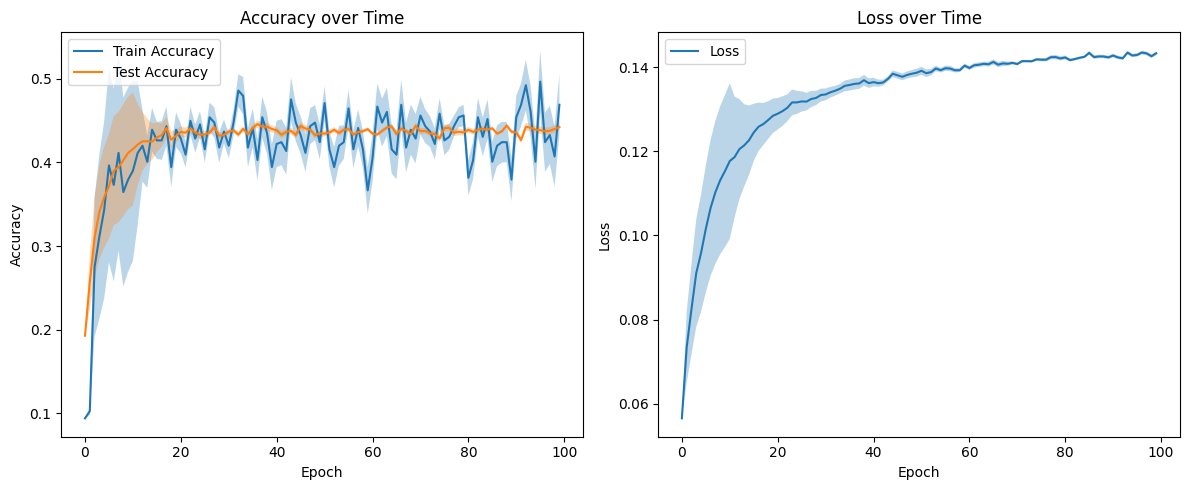

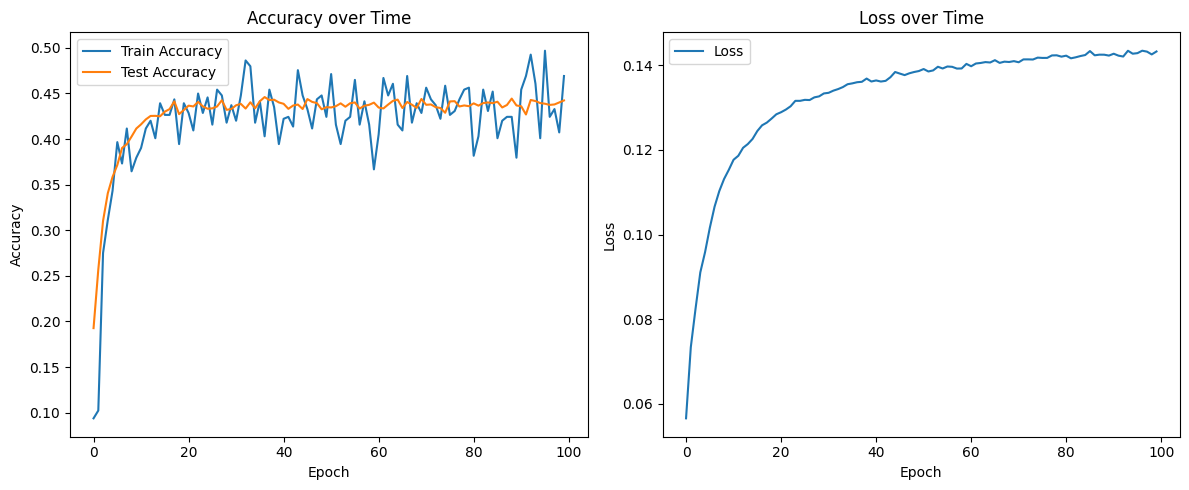

Final Train Accuracy: 0.47 ± 0.04
Final Test Accuracy: 0.44 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1723741008:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.06754179221035829
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723741008:   1%|          | 1/100 [00:04<07:36,  4.61s/it]

 Test accuracy:  0.1009

correct: 48 total: 469
loss: 0.09163364273970569
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723741008:   2%|▏         | 2/100 [00:09<07:47,  4.77s/it]

 Test accuracy:  0.1108

correct: 51 total: 469
loss: 0.09249424770760384
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1723741008:   3%|▎         | 3/100 [00:14<07:43,  4.78s/it]

 Test accuracy:  0.118

correct: 64 total: 469
loss: 0.09496695881904062
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723741008:   4%|▍         | 4/100 [00:19<07:47,  4.87s/it]

 Test accuracy:  0.1279

correct: 58 total: 469
loss: 0.09804510425275831
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723741008:   5%|▌         | 5/100 [00:24<07:53,  4.98s/it]

 Test accuracy:  0.1247

correct: 61 total: 469
loss: 0.0985483002942254
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723741008:   6%|▌         | 6/100 [00:29<07:59,  5.10s/it]

 Test accuracy:  0.1449

correct: 62 total: 469
loss: 0.10041611762379786
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1723741008:   7%|▋         | 7/100 [00:35<08:08,  5.25s/it]

 Test accuracy:  0.1339

correct: 62 total: 469
loss: 0.10042208337834649
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1723741008:   8%|▊         | 8/100 [00:40<08:09,  5.32s/it]

 Test accuracy:  0.133

correct: 58 total: 469
loss: 0.10019224245093271
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723741008:   9%|▉         | 9/100 [00:46<08:07,  5.35s/it]

 Test accuracy:  0.1429

correct: 67 total: 469
loss: 0.09990861546446773
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1723741008:  10%|█         | 10/100 [00:51<08:04,  5.39s/it]

 Test accuracy:  0.1461

correct: 61 total: 469
loss: 0.10233731888758857
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723741008:  11%|█         | 11/100 [00:57<08:02,  5.43s/it]

 Test accuracy:  0.1413

correct: 59 total: 469
loss: 0.10217591370346704
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723741008:  12%|█▏        | 12/100 [01:02<08:05,  5.52s/it]

 Test accuracy:  0.14

correct: 55 total: 469
loss: 0.10199340663230749
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1723741008:  13%|█▎        | 13/100 [01:08<08:10,  5.64s/it]

 Test accuracy:  0.1329

correct: 57 total: 469
loss: 0.10178511443613435
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723741008:  14%|█▍        | 14/100 [01:14<08:09,  5.69s/it]

 Test accuracy:  0.1387

correct: 59 total: 469
loss: 0.1018772533040311
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723741008:  15%|█▌        | 15/100 [01:20<08:08,  5.75s/it]

 Test accuracy:  0.1437

correct: 59 total: 469
loss: 0.10191939467750886
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723741008:  16%|█▌        | 16/100 [01:26<08:05,  5.78s/it]

 Test accuracy:  0.1423

correct: 71 total: 469
loss: 0.10233098192255634
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1723741008:  17%|█▋        | 17/100 [01:32<08:00,  5.79s/it]

 Test accuracy:  0.1428

correct: 65 total: 469
loss: 0.10286674219598649
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723741008:  18%|█▊        | 18/100 [01:38<08:02,  5.88s/it]

 Test accuracy:  0.1471

correct: 70 total: 469
loss: 0.1042691073787492
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1723741008:  19%|█▉        | 19/100 [01:44<08:00,  5.93s/it]

 Test accuracy:  0.1371

correct: 61 total: 469
loss: 0.1044588526651295
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723741008:  20%|██        | 20/100 [01:50<07:57,  5.97s/it]

 Test accuracy:  0.1398

correct: 64 total: 469
loss: 0.10270223791983082
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723741008:  21%|██        | 21/100 [01:56<07:52,  5.99s/it]

 Test accuracy:  0.1397

correct: 55 total: 469
loss: 0.10304877432043365
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1723741008:  22%|██▏       | 22/100 [02:02<07:50,  6.03s/it]

 Test accuracy:  0.1424

correct: 60 total: 469
loss: 0.10339357613373412
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723741008:  23%|██▎       | 23/100 [02:08<07:46,  6.06s/it]

 Test accuracy:  0.1426

correct: 56 total: 469
loss: 0.1040474875554093
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723741008:  24%|██▍       | 24/100 [02:14<07:42,  6.08s/it]

 Test accuracy:  0.1449

correct: 66 total: 469
loss: 0.1036643363011163
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723741008:  25%|██▌       | 25/100 [02:20<07:37,  6.10s/it]

 Test accuracy:  0.1438

correct: 65 total: 469
loss: 0.10386653606698457
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723741008:  26%|██▌       | 26/100 [02:27<07:32,  6.12s/it]

 Test accuracy:  0.1464

correct: 70 total: 469
loss: 0.10351873681679971
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1723741008:  27%|██▋       | 27/100 [02:33<07:25,  6.11s/it]

 Test accuracy:  0.1455

correct: 60 total: 469
loss: 0.10391002634504456
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723741008:  28%|██▊       | 28/100 [02:39<07:19,  6.10s/it]

 Test accuracy:  0.1425

correct: 65 total: 469
loss: 0.10382935285631782
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723741008:  29%|██▉       | 29/100 [02:45<07:16,  6.15s/it]

 Test accuracy:  0.1434

correct: 61 total: 469
loss: 0.1046215565696454
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723741008:  30%|███       | 30/100 [02:52<07:17,  6.25s/it]

 Test accuracy:  0.1423

correct: 57 total: 469
loss: 0.10470900246138766
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723741008:  31%|███       | 31/100 [02:58<07:08,  6.22s/it]

 Test accuracy:  0.1413

correct: 81 total: 469
loss: 0.10450905070566674
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1723741008:  32%|███▏      | 32/100 [03:04<07:01,  6.19s/it]

 Test accuracy:  0.1423

correct: 67 total: 469
loss: 0.105167067587884
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1723741008:  33%|███▎      | 33/100 [03:10<06:54,  6.18s/it]

 Test accuracy:  0.1428

correct: 59 total: 469
loss: 0.10466451909559876
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723741008:  34%|███▍      | 34/100 [03:16<06:53,  6.26s/it]

 Test accuracy:  0.1413

correct: 60 total: 469
loss: 0.10491549948067554
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723741008:  35%|███▌      | 35/100 [03:23<06:50,  6.31s/it]

 Test accuracy:  0.145

correct: 65 total: 469
loss: 0.10565571625158986
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723741008:  36%|███▌      | 36/100 [03:29<06:44,  6.31s/it]

 Test accuracy:  0.141

correct: 55 total: 469
loss: 0.10513124781758038
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1723741008:  37%|███▋      | 37/100 [03:35<06:35,  6.28s/it]

 Test accuracy:  0.1416

correct: 59 total: 469
loss: 0.10516432370903141
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723741008:  38%|███▊      | 38/100 [03:42<06:27,  6.25s/it]

 Test accuracy:  0.1424

correct: 55 total: 469
loss: 0.1055270906831664
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1723741008:  39%|███▉      | 39/100 [03:48<06:23,  6.29s/it]

 Test accuracy:  0.1398

correct: 62 total: 469
loss: 0.10489623024583117
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1723741008:  40%|████      | 40/100 [03:54<06:18,  6.30s/it]

 Test accuracy:  0.1435

correct: 62 total: 469
loss: 0.10530231030447397
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1723741008:  41%|████      | 41/100 [04:01<06:10,  6.28s/it]

 Test accuracy:  0.144

correct: 56 total: 469
loss: 0.10438166345868792
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723741008:  42%|████▏     | 42/100 [04:07<06:06,  6.31s/it]

 Test accuracy:  0.145

correct: 48 total: 469
loss: 0.1048524913662024
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723741008:  43%|████▎     | 43/100 [04:13<06:02,  6.36s/it]

 Test accuracy:  0.1424

correct: 59 total: 469
loss: 0.10437130861317934
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723741008:  44%|████▍     | 44/100 [04:20<06:00,  6.44s/it]

 Test accuracy:  0.1376

correct: 61 total: 469
loss: 0.1045957959092248
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723741008:  45%|████▌     | 45/100 [04:27<05:56,  6.49s/it]

 Test accuracy:  0.145

correct: 76 total: 469
loss: 0.1049080094866661
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1723741008:  46%|████▌     | 46/100 [04:33<05:47,  6.44s/it]

 Test accuracy:  0.1426

correct: 51 total: 469
loss: 0.10512599782712424
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1723741008:  47%|████▋     | 47/100 [04:39<05:42,  6.46s/it]

 Test accuracy:  0.1414

correct: 54 total: 469
loss: 0.10461834289117662
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723741008:  48%|████▊     | 48/100 [04:46<05:34,  6.42s/it]

 Test accuracy:  0.1418

correct: 58 total: 469
loss: 0.10442856751652414
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723741008:  49%|████▉     | 49/100 [04:52<05:29,  6.46s/it]

 Test accuracy:  0.1403

correct: 59 total: 469
loss: 0.10477227879676229
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723741008:  50%|█████     | 50/100 [04:59<05:19,  6.39s/it]

 Test accuracy:  0.1423

correct: 61 total: 469
loss: 0.10576603324936905
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723741008:  51%|█████     | 51/100 [05:05<05:11,  6.37s/it]

 Test accuracy:  0.1437

correct: 57 total: 469
loss: 0.10535985736577495
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723741008:  52%|█████▏    | 52/100 [05:11<05:04,  6.34s/it]

 Test accuracy:  0.1473

correct: 54 total: 469
loss: 0.10480230644758322
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723741008:  53%|█████▎    | 53/100 [05:17<04:57,  6.33s/it]

 Test accuracy:  0.1441

correct: 59 total: 469
loss: 0.10524636548338161
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723741008:  54%|█████▍    | 54/100 [05:24<04:53,  6.37s/it]

 Test accuracy:  0.1414

correct: 60 total: 469
loss: 0.10529534437699613
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723741008:  55%|█████▌    | 55/100 [05:30<04:46,  6.37s/it]

 Test accuracy:  0.144

correct: 63 total: 469
loss: 0.10470824614008352
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723741008:  56%|█████▌    | 56/100 [05:37<04:40,  6.39s/it]

 Test accuracy:  0.1402

correct: 59 total: 469
loss: 0.10452037982976259
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723741008:  57%|█████▋    | 57/100 [05:43<04:34,  6.37s/it]

 Test accuracy:  0.1398

correct: 56 total: 469
loss: 0.10426406921354184
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723741008:  58%|█████▊    | 58/100 [05:49<04:27,  6.38s/it]

 Test accuracy:  0.1446

correct: 36 total: 469
loss: 0.103779395045375
 Train accuracy:  0.0767590618336887 | 


MLP_MNIST_0_1723741008:  59%|█████▉    | 59/100 [05:56<04:23,  6.42s/it]

 Test accuracy:  0.1394

correct: 46 total: 469
loss: 0.10450422608140689
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1723741008:  60%|██████    | 60/100 [06:03<04:21,  6.55s/it]

 Test accuracy:  0.1454

correct: 66 total: 469
loss: 0.10426320056162917
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723741008:  61%|██████    | 61/100 [06:09<04:13,  6.51s/it]

 Test accuracy:  0.1426

correct: 40 total: 469
loss: 0.10399135831258953
 Train accuracy:  0.08528784648187633 | 


MLP_MNIST_0_1723741008:  62%|██████▏   | 62/100 [06:16<04:06,  6.47s/it]

 Test accuracy:  0.1445

correct: 54 total: 469
loss: 0.10415260590660547
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723741008:  63%|██████▎   | 63/100 [06:22<04:00,  6.50s/it]

 Test accuracy:  0.1447

correct: 60 total: 469
loss: 0.10335517215576254
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723741008:  64%|██████▍   | 64/100 [06:29<03:53,  6.49s/it]

 Test accuracy:  0.1444

correct: 50 total: 469
loss: 0.104086950850258
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1723741008:  65%|██████▌   | 65/100 [06:35<03:46,  6.48s/it]

 Test accuracy:  0.1409

correct: 60 total: 469
loss: 0.10369788037180137
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723741008:  66%|██████▌   | 66/100 [06:42<03:39,  6.46s/it]

 Test accuracy:  0.1462

correct: 69 total: 469
loss: 0.10324373952488401
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1723741008:  67%|██████▋   | 67/100 [06:48<03:33,  6.47s/it]

 Test accuracy:  0.1433

correct: 58 total: 469
loss: 0.10496961964028222
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723741008:  68%|██████▊   | 68/100 [06:55<03:27,  6.49s/it]

 Test accuracy:  0.1419

correct: 60 total: 469
loss: 0.1042276897441858
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723741008:  69%|██████▉   | 69/100 [07:01<03:20,  6.48s/it]

 Test accuracy:  0.1429

correct: 63 total: 469
loss: 0.10353845114837577
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723741008:  70%|███████   | 70/100 [07:07<03:13,  6.44s/it]

 Test accuracy:  0.1423

correct: 66 total: 469
loss: 0.10443647569621295
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723741008:  71%|███████   | 71/100 [07:14<03:06,  6.42s/it]

 Test accuracy:  0.143

correct: 47 total: 469
loss: 0.10344206346377635
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723741008:  72%|███████▏  | 72/100 [07:20<02:59,  6.41s/it]

 Test accuracy:  0.1444

correct: 60 total: 469
loss: 0.1037767451645723
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723741008:  73%|███████▎  | 73/100 [07:27<02:54,  6.47s/it]

 Test accuracy:  0.1455

correct: 58 total: 469
loss: 0.10421696716724936
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723741008:  74%|███████▍  | 74/100 [07:33<02:48,  6.49s/it]

 Test accuracy:  0.1418

correct: 46 total: 469
loss: 0.10390233366029349
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1723741008:  75%|███████▌  | 75/100 [07:40<02:43,  6.52s/it]

 Test accuracy:  0.1425

correct: 46 total: 469
loss: 0.10331672423684013
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1723741008:  76%|███████▌  | 76/100 [07:46<02:36,  6.51s/it]

 Test accuracy:  0.1403

correct: 56 total: 469
loss: 0.10264035471593902
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723741008:  77%|███████▋  | 77/100 [07:53<02:29,  6.49s/it]

 Test accuracy:  0.1422

correct: 57 total: 469
loss: 0.10443294987177798
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723741008:  78%|███████▊  | 78/100 [07:59<02:23,  6.54s/it]

 Test accuracy:  0.1432

correct: 63 total: 469
loss: 0.10388136229344777
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723741008:  79%|███████▉  | 79/100 [08:06<02:17,  6.53s/it]

 Test accuracy:  0.1431

correct: 59 total: 469
loss: 0.10400739936495641
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723741008:  80%|████████  | 80/100 [08:12<02:10,  6.51s/it]

 Test accuracy:  0.1433

correct: 43 total: 469
loss: 0.10377173159104675
 Train accuracy:  0.09168443496801706 | 


MLP_MNIST_0_1723741008:  81%|████████  | 81/100 [08:19<02:04,  6.56s/it]

 Test accuracy:  0.1427

correct: 52 total: 469
loss: 0.10274715221195078
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1723741008:  82%|████████▏ | 82/100 [08:26<01:58,  6.58s/it]

 Test accuracy:  0.1398

correct: 55 total: 469
loss: 0.10460772411401338
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1723741008:  83%|████████▎ | 83/100 [08:32<01:52,  6.64s/it]

 Test accuracy:  0.1431

correct: 56 total: 469
loss: 0.10425728195702344
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723741008:  84%|████████▍ | 84/100 [08:39<01:46,  6.64s/it]

 Test accuracy:  0.1424

correct: 55 total: 469
loss: 0.10386330302336069
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1723741008:  85%|████████▌ | 85/100 [08:46<01:39,  6.64s/it]

 Test accuracy:  0.1438

correct: 60 total: 469
loss: 0.10401049351641364
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723741008:  86%|████████▌ | 86/100 [08:52<01:32,  6.63s/it]

 Test accuracy:  0.1392

correct: 52 total: 469
loss: 0.10354360988907722
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1723741008:  87%|████████▋ | 87/100 [08:59<01:26,  6.63s/it]

 Test accuracy:  0.1416

correct: 58 total: 469
loss: 0.10393440790140807
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723741008:  88%|████████▊ | 88/100 [09:06<01:20,  6.68s/it]

 Test accuracy:  0.1427

correct: 48 total: 469
loss: 0.10381262191831431
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723741008:  89%|████████▉ | 89/100 [09:12<01:12,  6.62s/it]

 Test accuracy:  0.1432

correct: 56 total: 469
loss: 0.10311881133488246
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723741008:  90%|█████████ | 90/100 [09:19<01:06,  6.62s/it]

 Test accuracy:  0.1456

correct: 59 total: 469
loss: 0.10420124085028289
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723741008:  91%|█████████ | 91/100 [09:26<00:59,  6.63s/it]

 Test accuracy:  0.1452

correct: 57 total: 469
loss: 0.10346120559393979
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723741008:  92%|█████████▏| 92/100 [09:32<00:53,  6.68s/it]

 Test accuracy:  0.1437

correct: 54 total: 469
loss: 0.10276868823431194
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723741008:  93%|█████████▎| 93/100 [09:39<00:47,  6.74s/it]

 Test accuracy:  0.1436

correct: 56 total: 469
loss: 0.10263227453745251
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723741008:  94%|█████████▍| 94/100 [09:46<00:40,  6.67s/it]

 Test accuracy:  0.1443

correct: 65 total: 469
loss: 0.10341892420038232
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723741008:  95%|█████████▌| 95/100 [09:52<00:33,  6.64s/it]

 Test accuracy:  0.1424

correct: 61 total: 469
loss: 0.10333223625032632
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723741008:  96%|█████████▌| 96/100 [09:59<00:26,  6.64s/it]

 Test accuracy:  0.1423

correct: 54 total: 469
loss: 0.10363691798977252
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723741008:  97%|█████████▋| 97/100 [10:06<00:20,  6.88s/it]

 Test accuracy:  0.1433

correct: 64 total: 469
loss: 0.10350553947153376
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723741008:  98%|█████████▊| 98/100 [10:13<00:13,  6.83s/it]

 Test accuracy:  0.143

correct: 54 total: 469
loss: 0.10266157643182446
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723741008:  99%|█████████▉| 99/100 [10:20<00:06,  6.82s/it]

 Test accuracy:  0.1402

correct: 61 total: 469
loss: 0.10403423915222001
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723741008: 100%|██████████| 100/100 [10:27<00:00,  6.27s/it]

 Test accuracy:  0.1396


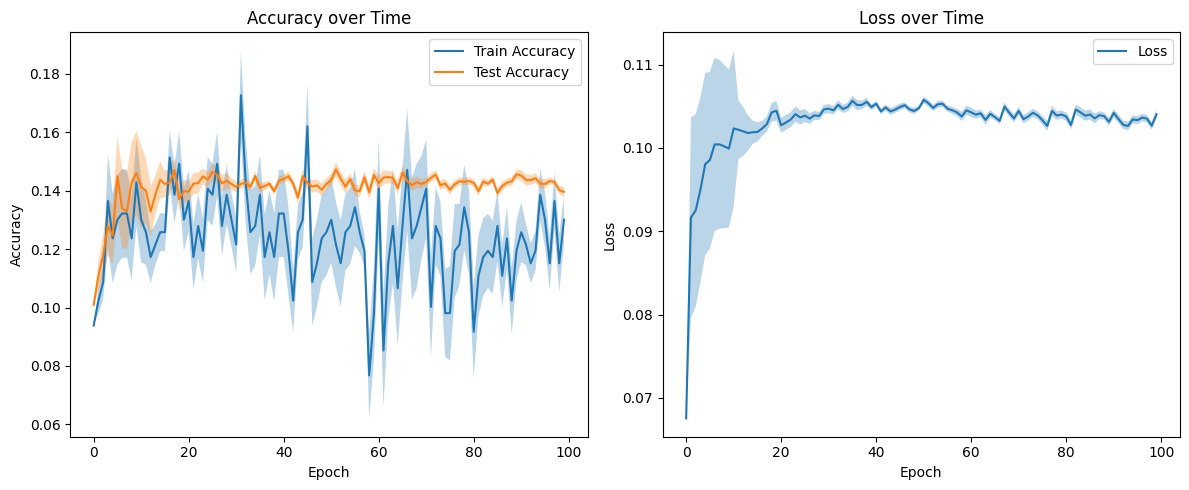

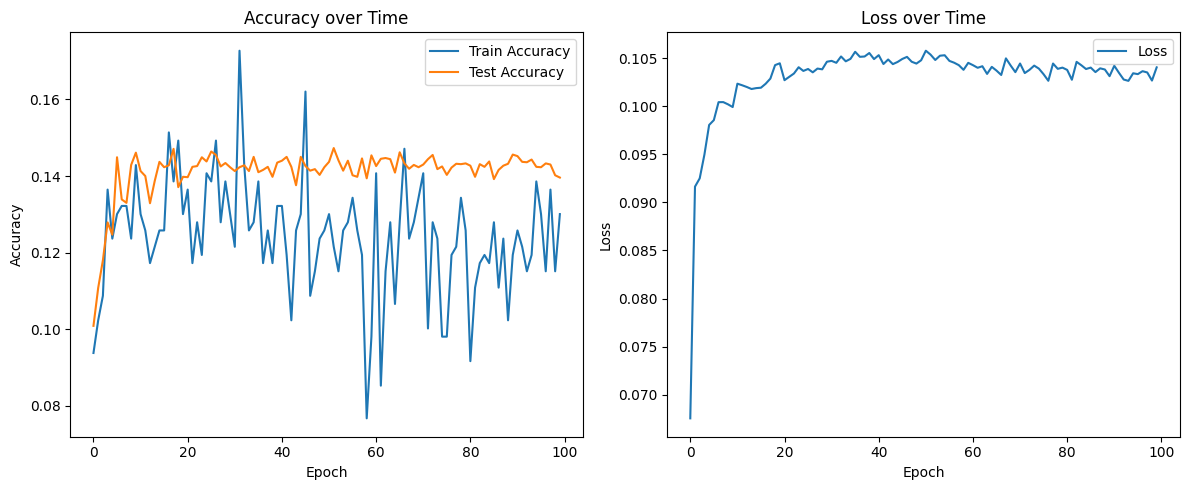

Final Train Accuracy: 0.13 ± 0.01
Final Test Accuracy: 0.14 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1723741641:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.05210760827543639
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723741641:   1%|          | 1/100 [00:04<07:53,  4.78s/it]

 Test accuracy:  0.1072

correct: 48 total: 469
loss: 0.06877860257715813
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723741641:   2%|▏         | 2/100 [00:09<07:53,  4.83s/it]

 Test accuracy:  0.1108

correct: 57 total: 469
loss: 0.07399648939495657
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723741641:   3%|▎         | 3/100 [00:14<07:52,  4.87s/it]

 Test accuracy:  0.1215

correct: 50 total: 469
loss: 0.07690249041898418
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1723741641:   4%|▍         | 4/100 [00:19<07:50,  4.90s/it]

 Test accuracy:  0.1261

correct: 66 total: 469
loss: 0.07973313507939707
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723741641:   5%|▌         | 5/100 [00:24<07:46,  4.91s/it]

 Test accuracy:  0.1314

correct: 74 total: 469
loss: 0.08300858008454857
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723741641:   6%|▌         | 6/100 [00:29<07:49,  5.00s/it]

 Test accuracy:  0.1415

correct: 65 total: 469
loss: 0.08533714789507994
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723741641:   7%|▋         | 7/100 [00:34<07:53,  5.09s/it]

 Test accuracy:  0.1442

correct: 75 total: 469
loss: 0.08745164748257411
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723741641:   8%|▊         | 8/100 [00:40<07:52,  5.14s/it]

 Test accuracy:  0.1445

correct: 85 total: 469
loss: 0.08913807011743598
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1723741641:   9%|▉         | 9/100 [00:45<07:48,  5.15s/it]

 Test accuracy:  0.1506

correct: 65 total: 469
loss: 0.09160922334265353
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723741641:  10%|█         | 10/100 [00:50<07:43,  5.15s/it]

 Test accuracy:  0.1439

correct: 67 total: 469
loss: 0.09178225443497903
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1723741641:  11%|█         | 11/100 [00:55<07:35,  5.11s/it]

 Test accuracy:  0.1546

correct: 72 total: 469
loss: 0.09372486185226868
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1723741641:  12%|█▏        | 12/100 [01:00<07:28,  5.10s/it]

 Test accuracy:  0.1592

correct: 70 total: 469
loss: 0.09471926590336412
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1723741641:  13%|█▎        | 13/100 [01:05<07:28,  5.15s/it]

 Test accuracy:  0.1595

correct: 85 total: 469
loss: 0.09596725648590751
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1723741641:  14%|█▍        | 14/100 [01:10<07:21,  5.13s/it]

 Test accuracy:  0.1607

correct: 49 total: 469
loss: 0.09645115005881039
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1723741641:  15%|█▌        | 15/100 [01:16<07:16,  5.13s/it]

 Test accuracy:  0.1546

correct: 75 total: 469
loss: 0.09659696564173648
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723741641:  16%|█▌        | 16/100 [01:21<07:12,  5.15s/it]

 Test accuracy:  0.1585

correct: 76 total: 469
loss: 0.0971836824851758
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1723741641:  17%|█▋        | 17/100 [01:26<07:06,  5.14s/it]

 Test accuracy:  0.1559

correct: 75 total: 469
loss: 0.09858743271339676
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723741641:  18%|█▊        | 18/100 [01:31<07:04,  5.18s/it]

 Test accuracy:  0.1604

correct: 89 total: 469
loss: 0.09967056398135005
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1723741641:  19%|█▉        | 19/100 [01:36<07:01,  5.21s/it]

 Test accuracy:  0.1595

correct: 63 total: 469
loss: 0.10008036667731271
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723741641:  20%|██        | 20/100 [01:42<06:55,  5.20s/it]

 Test accuracy:  0.1624

correct: 78 total: 469
loss: 0.10017399599493694
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1723741641:  21%|██        | 21/100 [01:47<06:50,  5.19s/it]

 Test accuracy:  0.1594

correct: 63 total: 469
loss: 0.10003653910559124
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723741641:  22%|██▏       | 22/100 [01:52<06:44,  5.19s/it]

 Test accuracy:  0.156

correct: 74 total: 469
loss: 0.10077864463840212
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723741641:  23%|██▎       | 23/100 [01:57<06:39,  5.18s/it]

 Test accuracy:  0.1627

correct: 80 total: 469
loss: 0.10120650455514506
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723741641:  24%|██▍       | 24/100 [02:02<06:32,  5.16s/it]

 Test accuracy:  0.1609

correct: 86 total: 469
loss: 0.10197465742892547
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1723741641:  25%|██▌       | 25/100 [02:08<06:30,  5.20s/it]

 Test accuracy:  0.1567

correct: 73 total: 469
loss: 0.1025792091512985
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1723741641:  26%|██▌       | 26/100 [02:13<06:23,  5.18s/it]

 Test accuracy:  0.1586

correct: 70 total: 469
loss: 0.10184898419675034
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1723741641:  27%|██▋       | 27/100 [02:18<06:17,  5.16s/it]

 Test accuracy:  0.1604

correct: 76 total: 469
loss: 0.10331129346257334
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1723741641:  28%|██▊       | 28/100 [02:23<06:11,  5.16s/it]

 Test accuracy:  0.1609

correct: 90 total: 469
loss: 0.10298003435833876
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1723741641:  29%|██▉       | 29/100 [02:28<06:05,  5.14s/it]

 Test accuracy:  0.1612

correct: 82 total: 469
loss: 0.10370869550115264
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1723741641:  30%|███       | 30/100 [02:33<05:58,  5.12s/it]

 Test accuracy:  0.1649

correct: 69 total: 469
loss: 0.10452193885978096
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1723741641:  31%|███       | 31/100 [02:38<05:55,  5.16s/it]

 Test accuracy:  0.158

correct: 66 total: 469
loss: 0.10466287790267452
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723741641:  32%|███▏      | 32/100 [02:44<05:55,  5.23s/it]

 Test accuracy:  0.1585

correct: 77 total: 469
loss: 0.10488007751418583
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1723741641:  33%|███▎      | 33/100 [02:49<05:48,  5.21s/it]

 Test accuracy:  0.1655

correct: 84 total: 469
loss: 0.10502696696565604
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1723741641:  34%|███▍      | 34/100 [02:54<05:44,  5.21s/it]

 Test accuracy:  0.163

correct: 75 total: 469
loss: 0.10464499050429635
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723741641:  35%|███▌      | 35/100 [02:59<05:37,  5.19s/it]

 Test accuracy:  0.1616

correct: 68 total: 469
loss: 0.10574002347902449
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1723741641:  36%|███▌      | 36/100 [03:04<05:31,  5.17s/it]

 Test accuracy:  0.158

correct: 80 total: 469
loss: 0.10602368547845242
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723741641:  37%|███▋      | 37/100 [03:10<05:27,  5.19s/it]

 Test accuracy:  0.1639

correct: 67 total: 469
loss: 0.10563240889737856
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1723741641:  38%|███▊      | 38/100 [03:15<05:24,  5.24s/it]

 Test accuracy:  0.1631

correct: 83 total: 469
loss: 0.1060827497734444
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1723741641:  39%|███▉      | 39/100 [03:21<05:27,  5.36s/it]

 Test accuracy:  0.1642

correct: 76 total: 469
loss: 0.10560417013254755
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1723741641:  40%|████      | 40/100 [03:26<05:18,  5.32s/it]

 Test accuracy:  0.1584

correct: 85 total: 469
loss: 0.10685019114060697
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1723741641:  41%|████      | 41/100 [03:31<05:12,  5.29s/it]

 Test accuracy:  0.1655

correct: 79 total: 469
loss: 0.10668506940354162
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1723741641:  42%|████▏     | 42/100 [03:36<05:04,  5.25s/it]

 Test accuracy:  0.1607

correct: 63 total: 469
loss: 0.10650381348979499
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723741641:  43%|████▎     | 43/100 [03:41<04:58,  5.23s/it]

 Test accuracy:  0.1576

correct: 71 total: 469
loss: 0.10640609666292093
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1723741641:  44%|████▍     | 44/100 [03:47<04:54,  5.26s/it]

 Test accuracy:  0.1576

correct: 86 total: 469
loss: 0.10647817640734125
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1723741641:  45%|████▌     | 45/100 [03:52<04:47,  5.22s/it]

 Test accuracy:  0.1614

correct: 73 total: 469
loss: 0.1067826948376861
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1723741641:  46%|████▌     | 46/100 [03:57<04:41,  5.21s/it]

 Test accuracy:  0.1631

correct: 59 total: 469
loss: 0.10735654724495751
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723741641:  47%|████▋     | 47/100 [04:02<04:34,  5.18s/it]

 Test accuracy:  0.1541

correct: 82 total: 469
loss: 0.10631881314300017
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1723741641:  48%|████▊     | 48/100 [04:07<04:29,  5.17s/it]

 Test accuracy:  0.1657

correct: 77 total: 469
loss: 0.10720156670125054
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1723741641:  49%|████▉     | 49/100 [04:13<04:24,  5.18s/it]

 Test accuracy:  0.1596

correct: 74 total: 469
loss: 0.10801100017610135
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723741641:  50%|█████     | 50/100 [04:18<04:23,  5.27s/it]

 Test accuracy:  0.1619

correct: 82 total: 469
loss: 0.107985368590238
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1723741641:  51%|█████     | 51/100 [04:23<04:16,  5.24s/it]

 Test accuracy:  0.1539

correct: 73 total: 469
loss: 0.10786000567712764
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1723741641:  52%|█████▏    | 52/100 [04:28<04:11,  5.23s/it]

 Test accuracy:  0.1624

correct: 81 total: 469
loss: 0.10765413555509246
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1723741641:  53%|█████▎    | 53/100 [04:34<04:04,  5.21s/it]

 Test accuracy:  0.1633

correct: 78 total: 469
loss: 0.10664965431573295
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1723741641:  54%|█████▍    | 54/100 [04:39<04:00,  5.23s/it]

 Test accuracy:  0.1649

correct: 75 total: 469
loss: 0.10790164219036794
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723741641:  55%|█████▌    | 55/100 [04:44<03:55,  5.24s/it]

 Test accuracy:  0.1583

correct: 75 total: 469
loss: 0.10748825120582764
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723741641:  56%|█████▌    | 56/100 [04:50<03:54,  5.32s/it]

 Test accuracy:  0.1631

correct: 87 total: 469
loss: 0.10829168540646018
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1723741641:  57%|█████▋    | 57/100 [04:55<03:48,  5.31s/it]

 Test accuracy:  0.155

correct: 82 total: 469
loss: 0.10747851293160716
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1723741641:  58%|█████▊    | 58/100 [05:00<03:44,  5.34s/it]

 Test accuracy:  0.1626

correct: 67 total: 469
loss: 0.10804329072234473
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1723741641:  59%|█████▉    | 59/100 [05:06<03:37,  5.31s/it]

 Test accuracy:  0.1553

correct: 76 total: 469
loss: 0.10847386627245559
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1723741641:  60%|██████    | 60/100 [05:11<03:33,  5.34s/it]

 Test accuracy:  0.159

correct: 80 total: 469
loss: 0.10923710706899924
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723741641:  61%|██████    | 61/100 [05:16<03:28,  5.35s/it]

 Test accuracy:  0.1566

correct: 75 total: 469
loss: 0.10901395433238828
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723741641:  62%|██████▏   | 62/100 [05:22<03:25,  5.40s/it]

 Test accuracy:  0.1604

correct: 78 total: 469
loss: 0.109134249134994
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1723741641:  63%|██████▎   | 63/100 [05:27<03:18,  5.37s/it]

 Test accuracy:  0.1678

correct: 75 total: 469
loss: 0.10813061444998295
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723741641:  64%|██████▍   | 64/100 [05:32<03:12,  5.34s/it]

 Test accuracy:  0.1635

correct: 58 total: 469
loss: 0.10876890305262893
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723741641:  65%|██████▌   | 65/100 [05:38<03:06,  5.32s/it]

 Test accuracy:  0.1578

correct: 67 total: 469
loss: 0.10880732113745675
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1723741641:  66%|██████▌   | 66/100 [05:43<03:00,  5.31s/it]

 Test accuracy:  0.1582

correct: 76 total: 469
loss: 0.1088120250432476
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1723741641:  67%|██████▋   | 67/100 [05:48<02:55,  5.32s/it]

 Test accuracy:  0.1586

correct: 65 total: 469
loss: 0.10917639929348472
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723741641:  68%|██████▊   | 68/100 [05:54<02:51,  5.37s/it]

 Test accuracy:  0.166

correct: 61 total: 469
loss: 0.10912721408709788
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723741641:  69%|██████▉   | 69/100 [05:59<02:46,  5.35s/it]

 Test accuracy:  0.1611

correct: 90 total: 469
loss: 0.10825744271278381
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1723741641:  70%|███████   | 70/100 [06:05<02:43,  5.46s/it]

 Test accuracy:  0.1592

correct: 84 total: 469
loss: 0.10925078214104496
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1723741641:  71%|███████   | 71/100 [06:10<02:36,  5.40s/it]

 Test accuracy:  0.1618

correct: 76 total: 469
loss: 0.1094065132076298
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1723741641:  72%|███████▏  | 72/100 [06:15<02:29,  5.35s/it]

 Test accuracy:  0.1567

correct: 70 total: 469
loss: 0.10919850090864117
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1723741641:  73%|███████▎  | 73/100 [06:21<02:25,  5.39s/it]

 Test accuracy:  0.1665

correct: 75 total: 469
loss: 0.10866167999978767
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723741641:  74%|███████▍  | 74/100 [06:26<02:20,  5.40s/it]

 Test accuracy:  0.1621

correct: 79 total: 469
loss: 0.10914989220879988
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1723741641:  75%|███████▌  | 75/100 [06:32<02:14,  5.38s/it]

 Test accuracy:  0.1616

correct: 65 total: 469
loss: 0.10907724013587813
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723741641:  76%|███████▌  | 76/100 [06:37<02:09,  5.41s/it]

 Test accuracy:  0.1611

correct: 74 total: 469
loss: 0.10918310899406608
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723741641:  77%|███████▋  | 77/100 [06:42<02:04,  5.41s/it]

 Test accuracy:  0.1608

correct: 70 total: 469
loss: 0.10933644465927377
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1723741641:  78%|███████▊  | 78/100 [06:48<01:59,  5.44s/it]

 Test accuracy:  0.1615

correct: 69 total: 469
loss: 0.10907918119481377
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1723741641:  79%|███████▉  | 79/100 [06:53<01:54,  5.47s/it]

 Test accuracy:  0.1629

correct: 102 total: 469
loss: 0.10972345787197796
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1723741641:  80%|████████  | 80/100 [06:59<01:48,  5.45s/it]

 Test accuracy:  0.1578

correct: 73 total: 469
loss: 0.10994213765491047
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1723741641:  81%|████████  | 81/100 [07:04<01:43,  5.45s/it]

 Test accuracy:  0.1571

correct: 65 total: 469
loss: 0.10907769279439312
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723741641:  82%|████████▏ | 82/100 [07:10<01:38,  5.47s/it]

 Test accuracy:  0.1556

correct: 64 total: 469
loss: 0.10891862188193843
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723741641:  83%|████████▎ | 83/100 [07:15<01:32,  5.46s/it]

 Test accuracy:  0.1586

correct: 77 total: 469
loss: 0.10869300892866497
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1723741641:  84%|████████▍ | 84/100 [07:21<01:27,  5.47s/it]

 Test accuracy:  0.1546

correct: 68 total: 469
loss: 0.1098568108893915
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1723741641:  85%|████████▌ | 85/100 [07:26<01:22,  5.53s/it]

 Test accuracy:  0.1568

correct: 80 total: 469
loss: 0.10991529948802899
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723741641:  86%|████████▌ | 86/100 [07:32<01:18,  5.59s/it]

 Test accuracy:  0.1619

correct: 75 total: 469
loss: 0.10974219247603467
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723741641:  87%|████████▋ | 87/100 [07:38<01:12,  5.61s/it]

 Test accuracy:  0.1626

correct: 80 total: 469
loss: 0.10882532398011893
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723741641:  88%|████████▊ | 88/100 [07:44<01:07,  5.66s/it]

 Test accuracy:  0.1567

correct: 89 total: 469
loss: 0.11011463657879372
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1723741641:  89%|████████▉ | 89/100 [07:49<01:02,  5.67s/it]

 Test accuracy:  0.1606

correct: 78 total: 469
loss: 0.11024749541142856
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1723741641:  90%|█████████ | 90/100 [07:55<00:57,  5.71s/it]

 Test accuracy:  0.16

correct: 71 total: 469
loss: 0.10970122829429123
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1723741641:  91%|█████████ | 91/100 [08:01<00:51,  5.76s/it]

 Test accuracy:  0.1603

correct: 67 total: 469
loss: 0.10959075507261097
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1723741641:  92%|█████████▏| 92/100 [08:07<00:46,  5.77s/it]

 Test accuracy:  0.1626

correct: 74 total: 469
loss: 0.1090845790054244
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723741641:  93%|█████████▎| 93/100 [08:12<00:40,  5.76s/it]

 Test accuracy:  0.1557

correct: 81 total: 469
loss: 0.10961713409944893
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1723741641:  94%|█████████▍| 94/100 [08:18<00:34,  5.77s/it]

 Test accuracy:  0.1541

correct: 76 total: 469
loss: 0.11025956913288723
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1723741641:  95%|█████████▌| 95/100 [08:24<00:28,  5.74s/it]

 Test accuracy:  0.1616

correct: 86 total: 469
loss: 0.10901886707684125
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1723741641:  96%|█████████▌| 96/100 [08:30<00:23,  5.75s/it]

 Test accuracy:  0.1652

correct: 81 total: 469
loss: 0.11044951536253825
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1723741641:  97%|█████████▋| 97/100 [08:35<00:17,  5.74s/it]

 Test accuracy:  0.1593

correct: 82 total: 469
loss: 0.11080052182554945
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1723741641:  98%|█████████▊| 98/100 [08:41<00:11,  5.75s/it]

 Test accuracy:  0.1604

correct: 74 total: 469
loss: 0.1098898063495215
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723741641:  99%|█████████▉| 99/100 [08:47<00:05,  5.77s/it]

 Test accuracy:  0.1545

correct: 73 total: 469
loss: 0.11058000738877477
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1723741641: 100%|██████████| 100/100 [08:53<00:00,  5.33s/it]

 Test accuracy:  0.1576


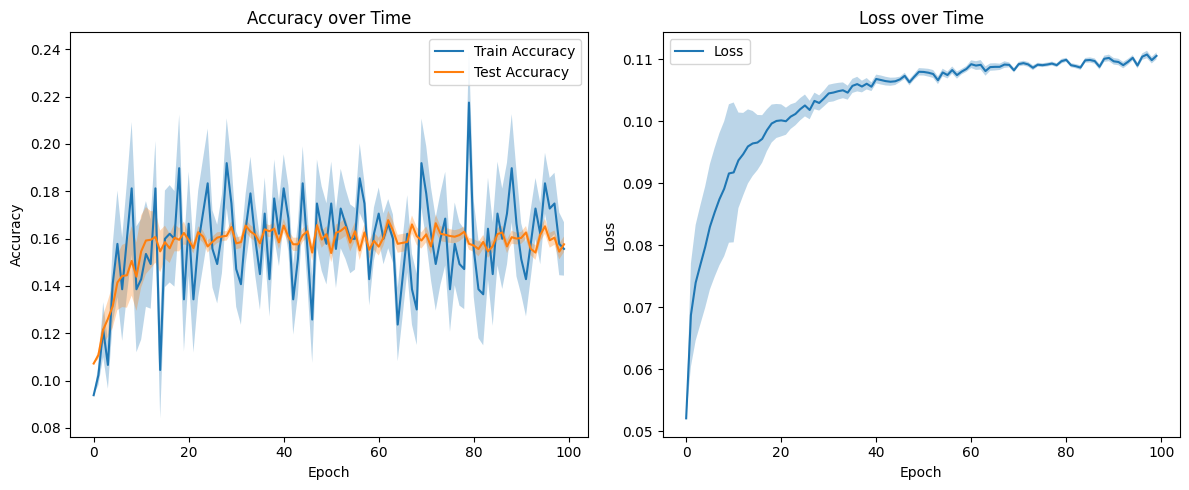

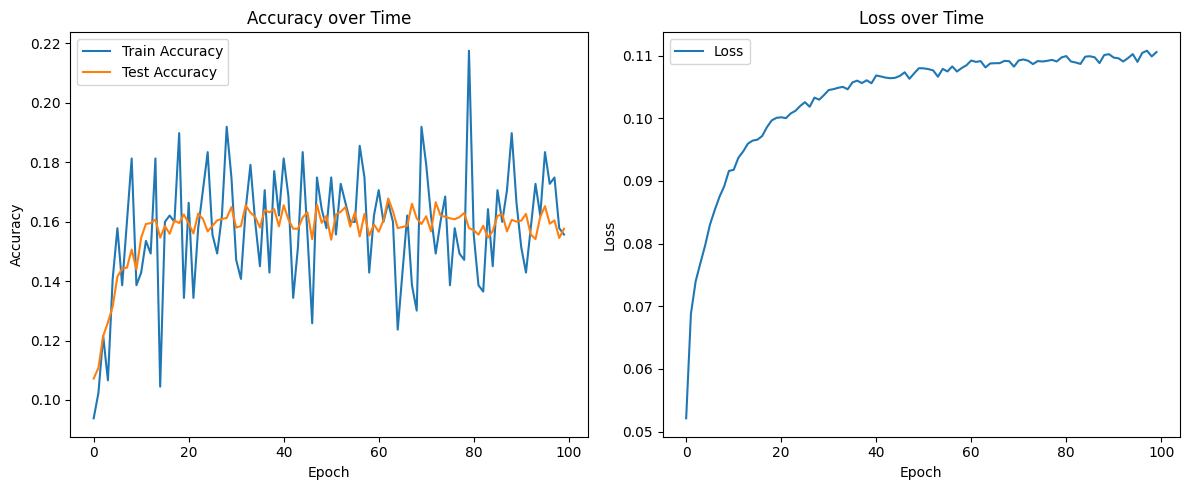

Final Train Accuracy: 0.16 ± 0.01
Final Test Accuracy: 0.16 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1723742180:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.06011684574901676
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723742180:   1%|          | 1/100 [00:05<09:13,  5.59s/it]

 Test accuracy:  0.2766

correct: 48 total: 469
loss: 0.0753499137630849
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723742180:   2%|▏         | 2/100 [00:11<09:04,  5.56s/it]

 Test accuracy:  0.3981

correct: 187 total: 469
loss: 0.08548851212713002
 Train accuracy:  0.39872068230277186 | 


MLP_MNIST_0_1723742180:   3%|▎         | 3/100 [00:16<08:52,  5.49s/it]

 Test accuracy:  0.4825

correct: 231 total: 469
loss: 0.09657933516924315
 Train accuracy:  0.4925373134328358 | 


MLP_MNIST_0_1723742180:   4%|▍         | 4/100 [00:22<08:51,  5.54s/it]

 Test accuracy:  0.5131

correct: 245 total: 469
loss: 0.10301903997466508
 Train accuracy:  0.5223880597014925 | 


MLP_MNIST_0_1723742180:   5%|▌         | 5/100 [00:27<08:52,  5.61s/it]

 Test accuracy:  0.5356

correct: 251 total: 469
loss: 0.10732205156514894
 Train accuracy:  0.535181236673774 | 


MLP_MNIST_0_1723742180:   6%|▌         | 6/100 [00:33<08:53,  5.68s/it]

 Test accuracy:  0.5562

correct: 248 total: 469
loss: 0.11064485741703749
 Train accuracy:  0.5287846481876333 | 


MLP_MNIST_0_1723742180:   7%|▋         | 7/100 [00:39<08:48,  5.68s/it]

 Test accuracy:  0.5729

correct: 267 total: 469
loss: 0.1134262833196217
 Train accuracy:  0.5692963752665245 | 


MLP_MNIST_0_1723742180:   8%|▊         | 8/100 [00:45<08:53,  5.80s/it]

 Test accuracy:  0.5864

correct: 282 total: 469
loss: 0.11565401813368807
 Train accuracy:  0.6012793176972282 | 


MLP_MNIST_0_1723742180:   9%|▉         | 9/100 [00:51<08:46,  5.79s/it]

 Test accuracy:  0.5915

correct: 271 total: 469
loss: 0.11820334812471353
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1723742180:  10%|█         | 10/100 [00:56<08:36,  5.74s/it]

 Test accuracy:  0.5958

correct: 251 total: 469
loss: 0.11964098923305459
 Train accuracy:  0.535181236673774 | 


MLP_MNIST_0_1723742180:  11%|█         | 11/100 [01:02<08:30,  5.74s/it]

 Test accuracy:  0.6005

correct: 281 total: 469
loss: 0.12063667016115778
 Train accuracy:  0.5991471215351812 | 


MLP_MNIST_0_1723742180:  12%|█▏        | 12/100 [01:08<08:32,  5.82s/it]

 Test accuracy:  0.612

correct: 286 total: 469
loss: 0.12206687854487759
 Train accuracy:  0.6098081023454158 | 


MLP_MNIST_0_1723742180:  13%|█▎        | 13/100 [01:14<08:27,  5.83s/it]

 Test accuracy:  0.6076

correct: 298 total: 469
loss: 0.12336251953009095
 Train accuracy:  0.6353944562899787 | 


MLP_MNIST_0_1723742180:  14%|█▍        | 14/100 [01:20<08:21,  5.83s/it]

 Test accuracy:  0.6194

correct: 281 total: 469
loss: 0.1239424727078694
 Train accuracy:  0.5991471215351812 | 


MLP_MNIST_0_1723742180:  15%|█▌        | 15/100 [01:25<08:12,  5.80s/it]

 Test accuracy:  0.6204

correct: 292 total: 469
loss: 0.12508629815283615
 Train accuracy:  0.6226012793176973 | 


MLP_MNIST_0_1723742180:  16%|█▌        | 16/100 [01:31<08:12,  5.87s/it]

 Test accuracy:  0.6165

correct: 314 total: 469
loss: 0.12550777400226226
 Train accuracy:  0.6695095948827292 | 


MLP_MNIST_0_1723742180:  17%|█▋        | 17/100 [01:38<08:16,  5.99s/it]

 Test accuracy:  0.6294

correct: 290 total: 469
loss: 0.12669567925843603
 Train accuracy:  0.6183368869936035 | 


MLP_MNIST_0_1723742180:  18%|█▊        | 18/100 [01:44<08:14,  6.03s/it]

 Test accuracy:  0.6273

correct: 295 total: 469
loss: 0.12692511661538183
 Train accuracy:  0.6289978678038379 | 


MLP_MNIST_0_1723742180:  19%|█▉        | 19/100 [01:50<08:19,  6.17s/it]

 Test accuracy:  0.6288

correct: 298 total: 469
loss: 0.1277387179037147
 Train accuracy:  0.6353944562899787 | 


MLP_MNIST_0_1723742180:  20%|██        | 20/100 [01:56<08:08,  6.11s/it]

 Test accuracy:  0.6263

correct: 295 total: 469
loss: 0.1279423776338858
 Train accuracy:  0.6289978678038379 | 


MLP_MNIST_0_1723742180:  21%|██        | 21/100 [02:02<07:59,  6.07s/it]

 Test accuracy:  0.6381

correct: 295 total: 469
loss: 0.128716631881845
 Train accuracy:  0.6289978678038379 | 


MLP_MNIST_0_1723742180:  22%|██▏       | 22/100 [02:08<07:53,  6.07s/it]

 Test accuracy:  0.6325

correct: 290 total: 469
loss: 0.12949653560800084
 Train accuracy:  0.6183368869936035 | 


MLP_MNIST_0_1723742180:  23%|██▎       | 23/100 [02:14<07:44,  6.04s/it]

 Test accuracy:  0.6295

correct: 294 total: 469
loss: 0.12971280837681756
 Train accuracy:  0.6268656716417911 | 


MLP_MNIST_0_1723742180:  24%|██▍       | 24/100 [02:20<07:40,  6.06s/it]

 Test accuracy:  0.6355

correct: 292 total: 469
loss: 0.12947196715167844
 Train accuracy:  0.6226012793176973 | 


MLP_MNIST_0_1723742180:  25%|██▌       | 25/100 [02:26<07:32,  6.03s/it]

 Test accuracy:  0.6311

correct: 304 total: 469
loss: 0.1302329947762906
 Train accuracy:  0.6481876332622601 | 


MLP_MNIST_0_1723742180:  26%|██▌       | 26/100 [02:32<07:25,  6.02s/it]

 Test accuracy:  0.6327

correct: 287 total: 469
loss: 0.13109074529808468
 Train accuracy:  0.6119402985074627 | 


MLP_MNIST_0_1723742180:  27%|██▋       | 27/100 [02:38<07:20,  6.03s/it]

 Test accuracy:  0.6332

correct: 292 total: 469
loss: 0.13124302434705215
 Train accuracy:  0.6226012793176973 | 


MLP_MNIST_0_1723742180:  28%|██▊       | 28/100 [02:44<07:13,  6.02s/it]

 Test accuracy:  0.6361

correct: 292 total: 469
loss: 0.13154734329564738
 Train accuracy:  0.6226012793176973 | 


MLP_MNIST_0_1723742180:  29%|██▉       | 29/100 [02:50<07:03,  5.97s/it]

 Test accuracy:  0.6297

correct: 308 total: 469
loss: 0.13219592761574014
 Train accuracy:  0.6567164179104478 | 


MLP_MNIST_0_1723742180:  30%|███       | 30/100 [02:56<06:55,  5.93s/it]

 Test accuracy:  0.639

correct: 300 total: 469
loss: 0.13206581563265848
 Train accuracy:  0.6396588486140725 | 


MLP_MNIST_0_1723742180:  31%|███       | 31/100 [03:02<06:49,  5.93s/it]

 Test accuracy:  0.6315

correct: 299 total: 469
loss: 0.132560059904798
 Train accuracy:  0.6375266524520256 | 


MLP_MNIST_0_1723742180:  32%|███▏      | 32/100 [03:08<06:42,  5.92s/it]

 Test accuracy:  0.6404

correct: 302 total: 469
loss: 0.13271909745644406
 Train accuracy:  0.6439232409381663 | 


MLP_MNIST_0_1723742180:  33%|███▎      | 33/100 [03:14<06:40,  5.98s/it]

 Test accuracy:  0.6377

correct: 314 total: 469
loss: 0.13368574131145153
 Train accuracy:  0.6695095948827292 | 


MLP_MNIST_0_1723742180:  34%|███▍      | 34/100 [03:20<06:34,  5.97s/it]

 Test accuracy:  0.6282

correct: 292 total: 469
loss: 0.13385897566641825
 Train accuracy:  0.6226012793176973 | 


MLP_MNIST_0_1723742180:  35%|███▌      | 35/100 [03:26<06:25,  5.94s/it]

 Test accuracy:  0.6445

correct: 306 total: 469
loss: 0.1335984660999607
 Train accuracy:  0.652452025586354 | 


MLP_MNIST_0_1723742180:  36%|███▌      | 36/100 [03:32<06:18,  5.91s/it]

 Test accuracy:  0.6334

correct: 280 total: 469
loss: 0.13415212268387078
 Train accuracy:  0.5970149253731343 | 


MLP_MNIST_0_1723742180:  37%|███▋      | 37/100 [03:38<06:11,  5.90s/it]

 Test accuracy:  0.6278

correct: 289 total: 469
loss: 0.13416353230283204
 Train accuracy:  0.6162046908315565 | 


MLP_MNIST_0_1723742180:  38%|███▊      | 38/100 [03:44<06:11,  5.99s/it]

 Test accuracy:  0.6377

correct: 298 total: 469
loss: 0.13429942630183722
 Train accuracy:  0.6353944562899787 | 


MLP_MNIST_0_1723742180:  39%|███▉      | 39/100 [03:50<06:13,  6.12s/it]

 Test accuracy:  0.6332

correct: 294 total: 469
loss: 0.134498067057209
 Train accuracy:  0.6268656716417911 | 


MLP_MNIST_0_1723742180:  40%|████      | 40/100 [03:56<06:04,  6.08s/it]

 Test accuracy:  0.6369

correct: 297 total: 469
loss: 0.134236670966977
 Train accuracy:  0.6332622601279317 | 


MLP_MNIST_0_1723742180:  41%|████      | 41/100 [04:02<05:56,  6.05s/it]

 Test accuracy:  0.6377

correct: 298 total: 469
loss: 0.13456592448294036
 Train accuracy:  0.6353944562899787 | 


MLP_MNIST_0_1723742180:  42%|████▏     | 42/100 [04:08<05:49,  6.03s/it]

 Test accuracy:  0.6433

correct: 296 total: 469
loss: 0.1344720374610124
 Train accuracy:  0.6311300639658849 | 


MLP_MNIST_0_1723742180:  43%|████▎     | 43/100 [04:14<05:44,  6.05s/it]

 Test accuracy:  0.6364

correct: 287 total: 469
loss: 0.13511447298691978
 Train accuracy:  0.6119402985074627 | 


MLP_MNIST_0_1723742180:  44%|████▍     | 44/100 [04:20<05:38,  6.05s/it]

 Test accuracy:  0.635

correct: 303 total: 469
loss: 0.13586716751045763
 Train accuracy:  0.6460554371002132 | 


MLP_MNIST_0_1723742180:  45%|████▌     | 45/100 [04:26<05:32,  6.04s/it]

 Test accuracy:  0.6382

correct: 283 total: 469
loss: 0.13545104711930125
 Train accuracy:  0.603411513859275 | 


MLP_MNIST_0_1723742180:  46%|████▌     | 46/100 [04:33<05:28,  6.08s/it]

 Test accuracy:  0.6377

correct: 300 total: 469
loss: 0.13573876069362228
 Train accuracy:  0.6396588486140725 | 


MLP_MNIST_0_1723742180:  47%|████▋     | 47/100 [04:39<05:21,  6.07s/it]

 Test accuracy:  0.6395

correct: 292 total: 469
loss: 0.1361431934749648
 Train accuracy:  0.6226012793176973 | 


MLP_MNIST_0_1723742180:  48%|████▊     | 48/100 [04:45<05:18,  6.13s/it]

 Test accuracy:  0.6447

correct: 302 total: 469
loss: 0.1358849762408718
 Train accuracy:  0.6439232409381663 | 


MLP_MNIST_0_1723742180:  49%|████▉     | 49/100 [04:51<05:11,  6.11s/it]

 Test accuracy:  0.6386

correct: 281 total: 469
loss: 0.1366400882156927
 Train accuracy:  0.5991471215351812 | 


MLP_MNIST_0_1723742180:  50%|█████     | 50/100 [04:57<05:04,  6.09s/it]

 Test accuracy:  0.637

correct: 282 total: 469
loss: 0.13583789406808963
 Train accuracy:  0.6012793176972282 | 


MLP_MNIST_0_1723742180:  51%|█████     | 51/100 [05:03<05:00,  6.13s/it]

 Test accuracy:  0.6292

correct: 285 total: 469
loss: 0.13622957734919305
 Train accuracy:  0.6076759061833689 | 


MLP_MNIST_0_1723742180:  52%|█████▏    | 52/100 [05:09<04:55,  6.16s/it]

 Test accuracy:  0.6369

correct: 294 total: 469
loss: 0.1365726568869182
 Train accuracy:  0.6268656716417911 | 


MLP_MNIST_0_1723742180:  53%|█████▎    | 53/100 [05:16<04:52,  6.23s/it]

 Test accuracy:  0.6389

correct: 314 total: 469
loss: 0.13628381795720504
 Train accuracy:  0.6695095948827292 | 


MLP_MNIST_0_1723742180:  54%|█████▍    | 54/100 [05:22<04:44,  6.19s/it]

 Test accuracy:  0.6381

correct: 279 total: 469
loss: 0.1366899285648169
 Train accuracy:  0.5948827292110874 | 


MLP_MNIST_0_1723742180:  55%|█████▌    | 55/100 [05:28<04:37,  6.16s/it]

 Test accuracy:  0.6424

correct: 297 total: 469
loss: 0.13649921087440905
 Train accuracy:  0.6332622601279317 | 


MLP_MNIST_0_1723742180:  56%|█████▌    | 56/100 [05:34<04:30,  6.15s/it]

 Test accuracy:  0.639

correct: 285 total: 469
loss: 0.1362845493691054
 Train accuracy:  0.6076759061833689 | 


MLP_MNIST_0_1723742180:  57%|█████▋    | 57/100 [05:40<04:25,  6.17s/it]

 Test accuracy:  0.6385

correct: 292 total: 469
loss: 0.13683606909790527
 Train accuracy:  0.6226012793176973 | 


MLP_MNIST_0_1723742180:  58%|█████▊    | 58/100 [05:47<04:20,  6.21s/it]

 Test accuracy:  0.6388

correct: 300 total: 469
loss: 0.13673048406076838
 Train accuracy:  0.6396588486140725 | 


MLP_MNIST_0_1723742180:  59%|█████▉    | 59/100 [05:53<04:15,  6.23s/it]

 Test accuracy:  0.6374

correct: 296 total: 469
loss: 0.13756273923588713
 Train accuracy:  0.6311300639658849 | 


MLP_MNIST_0_1723742180:  60%|██████    | 60/100 [05:59<04:08,  6.21s/it]

 Test accuracy:  0.6414

correct: 300 total: 469
loss: 0.13718414244684837
 Train accuracy:  0.6396588486140725 | 


MLP_MNIST_0_1723742180:  61%|██████    | 61/100 [06:05<04:01,  6.18s/it]

 Test accuracy:  0.6378

correct: 293 total: 469
loss: 0.13696161827553055
 Train accuracy:  0.6247334754797441 | 


MLP_MNIST_0_1723742180:  62%|██████▏   | 62/100 [06:11<03:53,  6.15s/it]

 Test accuracy:  0.6394

correct: 291 total: 469
loss: 0.1373859088399263
 Train accuracy:  0.6204690831556503 | 


MLP_MNIST_0_1723742180:  63%|██████▎   | 63/100 [06:17<03:46,  6.12s/it]

 Test accuracy:  0.6338

correct: 289 total: 469
loss: 0.13746749630360716
 Train accuracy:  0.6162046908315565 | 


MLP_MNIST_0_1723742180:  64%|██████▍   | 64/100 [06:24<03:42,  6.18s/it]

 Test accuracy:  0.6342

correct: 304 total: 469
loss: 0.13718519569523552
 Train accuracy:  0.6481876332622601 | 


MLP_MNIST_0_1723742180:  65%|██████▌   | 65/100 [06:30<03:35,  6.16s/it]

 Test accuracy:  0.6414

correct: 309 total: 469
loss: 0.13735210283923505
 Train accuracy:  0.6588486140724946 | 


MLP_MNIST_0_1723742180:  66%|██████▌   | 66/100 [06:36<03:28,  6.15s/it]

 Test accuracy:  0.6332

correct: 289 total: 469
loss: 0.13714233016980482
 Train accuracy:  0.6162046908315565 | 


MLP_MNIST_0_1723742180:  67%|██████▋   | 67/100 [06:42<03:23,  6.18s/it]

 Test accuracy:  0.6346

correct: 301 total: 469
loss: 0.13743193639811677
 Train accuracy:  0.6417910447761194 | 


MLP_MNIST_0_1723742180:  68%|██████▊   | 68/100 [06:48<03:18,  6.20s/it]

 Test accuracy:  0.6364

correct: 310 total: 469
loss: 0.13763400748658028
 Train accuracy:  0.6609808102345416 | 


MLP_MNIST_0_1723742180:  69%|██████▉   | 69/100 [06:55<03:13,  6.23s/it]

 Test accuracy:  0.6384

correct: 294 total: 469
loss: 0.13742445286974977
 Train accuracy:  0.6268656716417911 | 


MLP_MNIST_0_1723742180:  70%|███████   | 70/100 [07:01<03:07,  6.25s/it]

 Test accuracy:  0.6373

correct: 294 total: 469
loss: 0.1371988426488854
 Train accuracy:  0.6268656716417911 | 


MLP_MNIST_0_1723742180:  71%|███████   | 71/100 [07:07<03:01,  6.25s/it]

 Test accuracy:  0.6368

correct: 303 total: 469
loss: 0.1379211683676187
 Train accuracy:  0.6460554371002132 | 


MLP_MNIST_0_1723742180:  72%|███████▏  | 72/100 [07:14<02:55,  6.28s/it]

 Test accuracy:  0.6285

correct: 287 total: 469
loss: 0.1378104581888805
 Train accuracy:  0.6119402985074627 | 


MLP_MNIST_0_1723742180:  73%|███████▎  | 73/100 [07:20<02:50,  6.31s/it]

 Test accuracy:  0.6313

correct: 313 total: 469
loss: 0.13762994496616474
 Train accuracy:  0.6673773987206824 | 


MLP_MNIST_0_1723742180:  74%|███████▍  | 74/100 [07:26<02:45,  6.37s/it]

 Test accuracy:  0.6361

correct: 295 total: 469
loss: 0.13780953677923186
 Train accuracy:  0.6289978678038379 | 


MLP_MNIST_0_1723742180:  75%|███████▌  | 75/100 [07:33<02:39,  6.36s/it]

 Test accuracy:  0.6429

correct: 295 total: 469
loss: 0.13790464209023315
 Train accuracy:  0.6289978678038379 | 


MLP_MNIST_0_1723742180:  76%|███████▌  | 76/100 [07:40<02:35,  6.48s/it]

 Test accuracy:  0.6389

correct: 305 total: 469
loss: 0.13787395470559216
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1723742180:  77%|███████▋  | 77/100 [07:46<02:27,  6.41s/it]

 Test accuracy:  0.6383

correct: 298 total: 469
loss: 0.13735620598040665
 Train accuracy:  0.6353944562899787 | 


MLP_MNIST_0_1723742180:  78%|███████▊  | 78/100 [07:52<02:20,  6.40s/it]

 Test accuracy:  0.6369

correct: 287 total: 469
loss: 0.13837514374492518
 Train accuracy:  0.6119402985074627 | 


MLP_MNIST_0_1723742180:  79%|███████▉  | 79/100 [07:59<02:14,  6.41s/it]

 Test accuracy:  0.6372

correct: 309 total: 469
loss: 0.13764839875164317
 Train accuracy:  0.6588486140724946 | 


MLP_MNIST_0_1723742180:  80%|████████  | 80/100 [08:05<02:07,  6.38s/it]

 Test accuracy:  0.638

correct: 303 total: 469
loss: 0.13724229159131487
 Train accuracy:  0.6460554371002132 | 


MLP_MNIST_0_1723742180:  81%|████████  | 81/100 [08:11<02:00,  6.35s/it]

 Test accuracy:  0.6391

correct: 306 total: 469
loss: 0.13831721009539644
 Train accuracy:  0.652452025586354 | 


MLP_MNIST_0_1723742180:  82%|████████▏ | 82/100 [08:18<01:54,  6.34s/it]

 Test accuracy:  0.6366

correct: 290 total: 469
loss: 0.13754944979890324
 Train accuracy:  0.6183368869936035 | 


MLP_MNIST_0_1723742180:  83%|████████▎ | 83/100 [08:24<01:48,  6.36s/it]

 Test accuracy:  0.6382

correct: 281 total: 469
loss: 0.13763391256713664
 Train accuracy:  0.5991471215351812 | 


MLP_MNIST_0_1723742180:  84%|████████▍ | 84/100 [08:30<01:42,  6.42s/it]

 Test accuracy:  0.6361

correct: 301 total: 469
loss: 0.13825582091742233
 Train accuracy:  0.6417910447761194 | 


MLP_MNIST_0_1723742180:  85%|████████▌ | 85/100 [08:37<01:37,  6.48s/it]

 Test accuracy:  0.6406

correct: 283 total: 469
loss: 0.13831612841089144
 Train accuracy:  0.603411513859275 | 


MLP_MNIST_0_1723742180:  86%|████████▌ | 86/100 [08:44<01:30,  6.45s/it]

 Test accuracy:  0.6454

correct: 307 total: 469
loss: 0.13756778642439893
 Train accuracy:  0.6545842217484008 | 


MLP_MNIST_0_1723742180:  87%|████████▋ | 87/100 [08:50<01:23,  6.41s/it]

 Test accuracy:  0.6432

correct: 291 total: 469
loss: 0.13710399391427477
 Train accuracy:  0.6204690831556503 | 


MLP_MNIST_0_1723742180:  88%|████████▊ | 88/100 [08:56<01:16,  6.37s/it]

 Test accuracy:  0.6357

correct: 293 total: 469
loss: 0.13809736141327347
 Train accuracy:  0.6247334754797441 | 


MLP_MNIST_0_1723742180:  89%|████████▉ | 89/100 [09:02<01:10,  6.38s/it]

 Test accuracy:  0.6381

correct: 295 total: 469
loss: 0.13797240156227591
 Train accuracy:  0.6289978678038379 | 


MLP_MNIST_0_1723742180:  90%|█████████ | 90/100 [09:09<01:03,  6.36s/it]

 Test accuracy:  0.6364

correct: 282 total: 469
loss: 0.13839968689469132
 Train accuracy:  0.6012793176972282 | 


MLP_MNIST_0_1723742180:  91%|█████████ | 91/100 [09:15<00:57,  6.34s/it]

 Test accuracy:  0.6325

correct: 282 total: 469
loss: 0.13811991187428108
 Train accuracy:  0.6012793176972282 | 


MLP_MNIST_0_1723742180:  92%|█████████▏| 92/100 [09:21<00:50,  6.33s/it]

 Test accuracy:  0.6312

correct: 298 total: 469
loss: 0.1380586515325727
 Train accuracy:  0.6353944562899787 | 


MLP_MNIST_0_1723742180:  93%|█████████▎| 93/100 [09:28<00:44,  6.36s/it]

 Test accuracy:  0.6334

correct: 297 total: 469
loss: 0.13851242676091347
 Train accuracy:  0.6332622601279317 | 


MLP_MNIST_0_1723742180:  94%|█████████▍| 94/100 [09:34<00:38,  6.42s/it]

 Test accuracy:  0.6393

correct: 273 total: 469
loss: 0.13807364486491502
 Train accuracy:  0.582089552238806 | 


MLP_MNIST_0_1723742180:  95%|█████████▌| 95/100 [09:41<00:32,  6.43s/it]

 Test accuracy:  0.6294

correct: 290 total: 469
loss: 0.138219433568561
 Train accuracy:  0.6183368869936035 | 


MLP_MNIST_0_1723742180:  96%|█████████▌| 96/100 [09:47<00:25,  6.40s/it]

 Test accuracy:  0.6385

correct: 298 total: 469
loss: 0.138247514679742
 Train accuracy:  0.6353944562899787 | 


MLP_MNIST_0_1723742180:  97%|█████████▋| 97/100 [09:54<00:19,  6.38s/it]

 Test accuracy:  0.6382

correct: 282 total: 469
loss: 0.13869950213411977
 Train accuracy:  0.6012793176972282 | 


MLP_MNIST_0_1723742180:  98%|█████████▊| 98/100 [10:00<00:12,  6.38s/it]

 Test accuracy:  0.6346

correct: 294 total: 469
loss: 0.1383954350119715
 Train accuracy:  0.6268656716417911 | 


MLP_MNIST_0_1723742180:  99%|█████████▉| 99/100 [10:06<00:06,  6.36s/it]

 Test accuracy:  0.6355

correct: 310 total: 469
loss: 0.13885772939938218
 Train accuracy:  0.6609808102345416 | 


MLP_MNIST_0_1723742180: 100%|██████████| 100/100 [10:13<00:00,  6.13s/it]

 Test accuracy:  0.6356


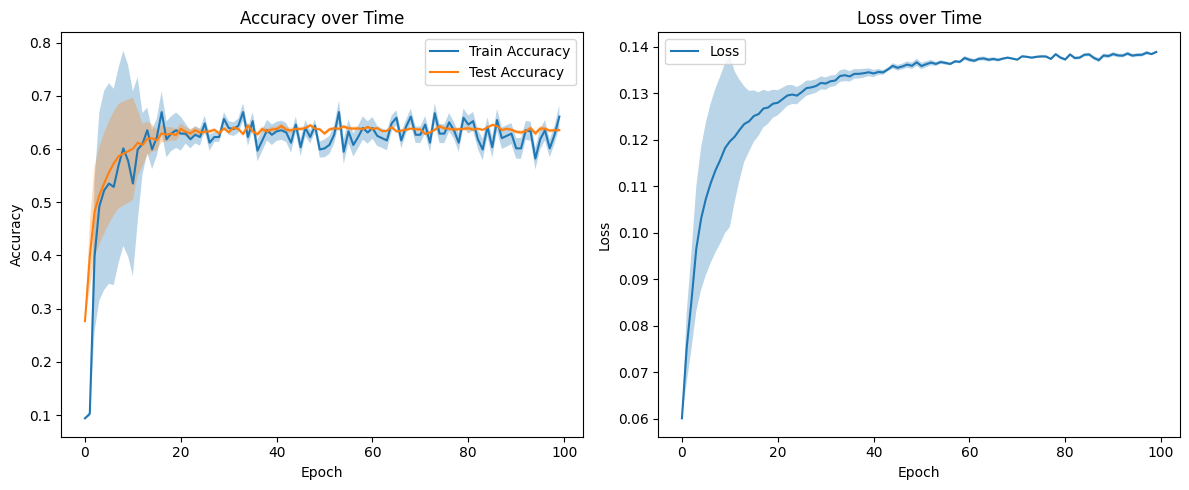

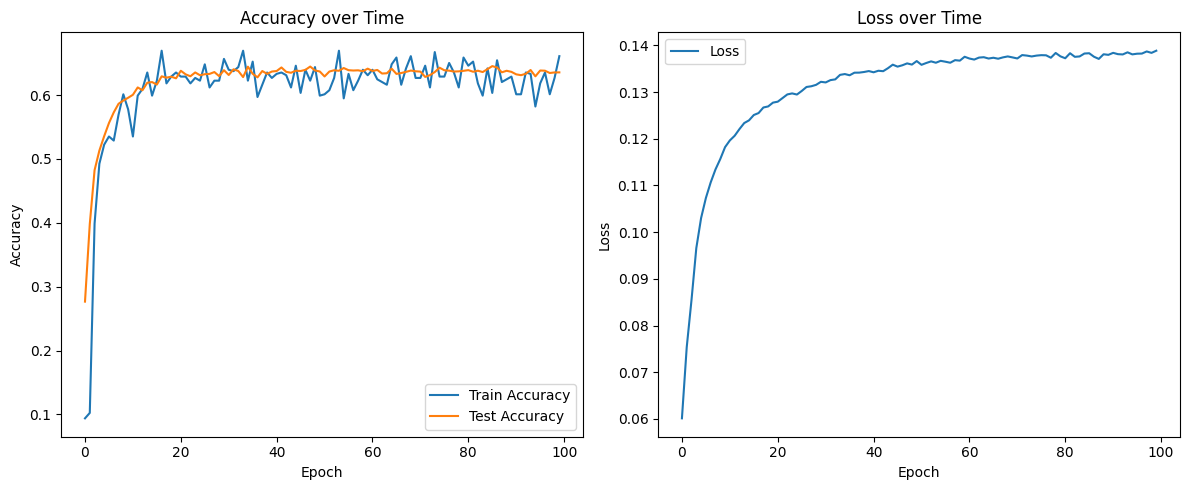

Final Train Accuracy: 0.66 ± 0.02
Final Test Accuracy: 0.64 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1723742797:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.06650166073714746
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723742797:   1%|          | 1/100 [00:04<08:08,  4.94s/it]

 Test accuracy:  0.1009

correct: 48 total: 469
loss: 0.0926478565819482
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723742797:   2%|▏         | 2/100 [00:10<08:15,  5.06s/it]

 Test accuracy:  0.1009

correct: 51 total: 469
loss: 0.09407200124154468
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1723742797:   3%|▎         | 3/100 [00:15<08:22,  5.18s/it]

 Test accuracy:  0.1135

correct: 58 total: 469
loss: 0.09495653271643338
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723742797:   4%|▍         | 4/100 [00:20<08:27,  5.29s/it]

 Test accuracy:  0.1143

correct: 60 total: 469
loss: 0.09789310880243651
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723742797:   5%|▌         | 5/100 [00:26<08:43,  5.51s/it]

 Test accuracy:  0.1184

correct: 54 total: 469
loss: 0.09810274731375769
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723742797:   6%|▌         | 6/100 [00:32<08:50,  5.64s/it]

 Test accuracy:  0.1891

correct: 64 total: 469
loss: 0.0989656666798124
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723742797:   7%|▋         | 7/100 [00:38<08:53,  5.74s/it]

 Test accuracy:  0.1394

correct: 78 total: 469
loss: 0.09979509729057995
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1723742797:   8%|▊         | 8/100 [00:44<08:54,  5.80s/it]

 Test accuracy:  0.1492

correct: 57 total: 469
loss: 0.09901370832533725
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723742797:   9%|▉         | 9/100 [00:50<08:55,  5.88s/it]

 Test accuracy:  0.1673

correct: 73 total: 469
loss: 0.09996864754063234
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1723742797:  10%|█         | 10/100 [00:56<08:51,  5.90s/it]

 Test accuracy:  0.1502

correct: 64 total: 469
loss: 0.10142399675683426
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723742797:  11%|█         | 11/100 [01:02<08:44,  5.89s/it]

 Test accuracy:  0.1605

correct: 72 total: 469
loss: 0.10263818265723267
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1723742797:  12%|█▏        | 12/100 [01:08<08:47,  6.00s/it]

 Test accuracy:  0.163

correct: 66 total: 469
loss: 0.10240018353469844
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723742797:  13%|█▎        | 13/100 [01:14<08:49,  6.09s/it]

 Test accuracy:  0.1559

correct: 69 total: 469
loss: 0.10230868260489344
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1723742797:  14%|█▍        | 14/100 [01:21<08:54,  6.22s/it]

 Test accuracy:  0.1542

correct: 64 total: 469
loss: 0.10280690993517955
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723742797:  15%|█▌        | 15/100 [01:27<08:50,  6.24s/it]

 Test accuracy:  0.1604

correct: 80 total: 469
loss: 0.10353047367352158
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723742797:  16%|█▌        | 16/100 [01:34<08:45,  6.26s/it]

 Test accuracy:  0.1712

correct: 84 total: 469
loss: 0.10452488414260117
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1723742797:  17%|█▋        | 17/100 [01:40<08:39,  6.26s/it]

 Test accuracy:  0.1763

correct: 91 total: 469
loss: 0.10501230730494457
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1723742797:  18%|█▊        | 18/100 [01:46<08:34,  6.27s/it]

 Test accuracy:  0.178

correct: 83 total: 469
loss: 0.10747299197195435
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1723742797:  19%|█▉        | 19/100 [01:53<08:35,  6.36s/it]

 Test accuracy:  0.1802

correct: 79 total: 469
loss: 0.10756512769440343
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1723742797:  20%|██        | 20/100 [01:59<08:25,  6.32s/it]

 Test accuracy:  0.1793

correct: 91 total: 469
loss: 0.1067863944401619
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1723742797:  21%|██        | 21/100 [02:05<08:18,  6.31s/it]

 Test accuracy:  0.1811

correct: 77 total: 469
loss: 0.1069656060353271
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1723742797:  22%|██▏       | 22/100 [02:12<08:12,  6.31s/it]

 Test accuracy:  0.1833

correct: 93 total: 469
loss: 0.10783140219922767
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1723742797:  23%|██▎       | 23/100 [02:18<08:06,  6.31s/it]

 Test accuracy:  0.18

correct: 95 total: 469
loss: 0.11011240277081918
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1723742797:  24%|██▍       | 24/100 [02:25<08:14,  6.51s/it]

 Test accuracy:  0.1797

correct: 86 total: 469
loss: 0.1094805898982833
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1723742797:  25%|██▌       | 25/100 [02:31<08:09,  6.53s/it]

 Test accuracy:  0.1786

correct: 88 total: 469
loss: 0.11104084703840934
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1723742797:  26%|██▌       | 26/100 [02:38<08:00,  6.50s/it]

 Test accuracy:  0.176

correct: 77 total: 469
loss: 0.1103207471369426
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1723742797:  27%|██▋       | 27/100 [02:44<07:51,  6.46s/it]

 Test accuracy:  0.1763

correct: 80 total: 469
loss: 0.1105799698975803
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723742797:  28%|██▊       | 28/100 [02:51<07:46,  6.47s/it]

 Test accuracy:  0.1753

correct: 89 total: 469
loss: 0.1113093658201476
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1723742797:  29%|██▉       | 29/100 [02:57<07:41,  6.49s/it]

 Test accuracy:  0.1755

correct: 85 total: 469
loss: 0.11160231489680215
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1723742797:  30%|███       | 30/100 [03:04<07:31,  6.45s/it]

 Test accuracy:  0.1767

correct: 76 total: 469
loss: 0.11254408996877895
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1723742797:  31%|███       | 31/100 [03:10<07:23,  6.42s/it]

 Test accuracy:  0.1742

correct: 83 total: 469
loss: 0.11205721379660849
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1723742797:  32%|███▏      | 32/100 [03:16<07:13,  6.38s/it]

 Test accuracy:  0.1736

correct: 83 total: 469
loss: 0.11227388168448832
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1723742797:  33%|███▎      | 33/100 [03:23<07:07,  6.38s/it]

 Test accuracy:  0.1728

correct: 88 total: 469
loss: 0.11213696655878888
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1723742797:  34%|███▍      | 34/100 [03:29<07:06,  6.47s/it]

 Test accuracy:  0.176

correct: 93 total: 469
loss: 0.11260303289397185
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1723742797:  35%|███▌      | 35/100 [03:36<06:59,  6.46s/it]

 Test accuracy:  0.1732

correct: 82 total: 469
loss: 0.11274151270514104
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1723742797:  36%|███▌      | 36/100 [03:42<06:54,  6.47s/it]

 Test accuracy:  0.1733

correct: 84 total: 469
loss: 0.11328898578373862
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1723742797:  37%|███▋      | 37/100 [03:49<06:47,  6.47s/it]

 Test accuracy:  0.174

correct: 81 total: 469
loss: 0.11339741486158453
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1723742797:  38%|███▊      | 38/100 [03:55<06:42,  6.49s/it]

 Test accuracy:  0.1732

correct: 68 total: 469
loss: 0.11353233469320513
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1723742797:  39%|███▉      | 39/100 [04:02<06:38,  6.54s/it]

 Test accuracy:  0.1725

correct: 78 total: 469
loss: 0.11278844151352006
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1723742797:  40%|████      | 40/100 [04:08<06:31,  6.52s/it]

 Test accuracy:  0.1734

correct: 84 total: 469
loss: 0.11395462221110553
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1723742797:  41%|████      | 41/100 [04:15<06:22,  6.49s/it]

 Test accuracy:  0.1743

correct: 82 total: 469
loss: 0.11349229536839385
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1723742797:  42%|████▏     | 42/100 [04:21<06:14,  6.46s/it]

 Test accuracy:  0.1732

correct: 79 total: 469
loss: 0.11355477784361158
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1723742797:  43%|████▎     | 43/100 [04:28<06:11,  6.52s/it]

 Test accuracy:  0.1726

correct: 82 total: 469
loss: 0.11344091805504329
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1723742797:  44%|████▍     | 44/100 [04:34<06:04,  6.51s/it]

 Test accuracy:  0.1747

correct: 84 total: 469
loss: 0.11349870722049843
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1723742797:  45%|████▌     | 45/100 [04:41<05:57,  6.51s/it]

 Test accuracy:  0.1723

correct: 91 total: 469
loss: 0.11417996279720559
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1723742797:  46%|████▌     | 46/100 [04:47<05:50,  6.48s/it]

 Test accuracy:  0.1739

correct: 81 total: 469
loss: 0.11483771021940561
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1723742797:  47%|████▋     | 47/100 [04:54<05:43,  6.48s/it]

 Test accuracy:  0.1743

correct: 82 total: 469
loss: 0.11360974323902048
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1723742797:  48%|████▊     | 48/100 [05:00<05:38,  6.50s/it]

 Test accuracy:  0.1717

correct: 74 total: 469
loss: 0.11326852669593876
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723742797:  49%|████▉     | 49/100 [05:07<05:31,  6.51s/it]

 Test accuracy:  0.1718

correct: 99 total: 469
loss: 0.11478872200065075
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1723742797:  50%|█████     | 50/100 [05:13<05:25,  6.52s/it]

 Test accuracy:  0.1725

correct: 77 total: 469
loss: 0.11546359408194068
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1723742797:  51%|█████     | 51/100 [05:20<05:18,  6.50s/it]

 Test accuracy:  0.1731

correct: 71 total: 469
loss: 0.11458139760153634
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1723742797:  52%|█████▏    | 52/100 [05:27<05:16,  6.59s/it]

 Test accuracy:  0.1746

correct: 74 total: 469
loss: 0.11406737098942941
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723742797:  53%|█████▎    | 53/100 [05:33<05:14,  6.68s/it]

 Test accuracy:  0.1726

correct: 83 total: 469
loss: 0.11466002880510237
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1723742797:  54%|█████▍    | 54/100 [05:40<05:07,  6.68s/it]

 Test accuracy:  0.1742

correct: 93 total: 469
loss: 0.11467259177076283
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1723742797:  55%|█████▌    | 55/100 [05:47<04:59,  6.66s/it]

 Test accuracy:  0.1723

correct: 88 total: 469
loss: 0.11491443586946805
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1723742797:  56%|█████▌    | 56/100 [05:53<04:52,  6.65s/it]

 Test accuracy:  0.1748

correct: 76 total: 469
loss: 0.11433404815921397
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1723742797:  57%|█████▋    | 57/100 [06:00<04:44,  6.63s/it]

 Test accuracy:  0.174

correct: 84 total: 469
loss: 0.113991323294543
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1723742797:  58%|█████▊    | 58/100 [06:07<04:39,  6.66s/it]

 Test accuracy:  0.1745

correct: 58 total: 469
loss: 0.11471142202043838
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723742797:  59%|█████▉    | 59/100 [06:13<04:32,  6.65s/it]

 Test accuracy:  0.1712

correct: 72 total: 469
loss: 0.11489124364181877
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1723742797:  60%|██████    | 60/100 [06:20<04:25,  6.63s/it]

 Test accuracy:  0.1731

correct: 81 total: 469
loss: 0.11453611829451152
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1723742797:  61%|██████    | 61/100 [06:27<04:19,  6.65s/it]

 Test accuracy:  0.1721

correct: 61 total: 469
loss: 0.1145464979858795
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723742797:  62%|██████▏   | 62/100 [06:33<04:14,  6.69s/it]

 Test accuracy:  0.1717

correct: 79 total: 469
loss: 0.11578697561899991
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1723742797:  63%|██████▎   | 63/100 [06:40<04:07,  6.69s/it]

 Test accuracy:  0.1712

correct: 79 total: 469
loss: 0.11454986906382067
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1723742797:  64%|██████▍   | 64/100 [06:47<04:05,  6.82s/it]

 Test accuracy:  0.1738

correct: 97 total: 469
loss: 0.1148338461640293
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1723742797:  65%|██████▌   | 65/100 [06:54<03:56,  6.77s/it]

 Test accuracy:  0.173

correct: 86 total: 469
loss: 0.11540428479152448
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1723742797:  66%|██████▌   | 66/100 [07:00<03:48,  6.73s/it]

 Test accuracy:  0.1723

correct: 81 total: 469
loss: 0.1150550037336502
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1723742797:  67%|██████▋   | 67/100 [07:07<03:43,  6.77s/it]

 Test accuracy:  0.1733

correct: 87 total: 469
loss: 0.11576380289948063
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1723742797:  68%|██████▊   | 68/100 [07:14<03:35,  6.73s/it]

 Test accuracy:  0.1743

correct: 77 total: 469
loss: 0.11497493045352923
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1723742797:  69%|██████▉   | 69/100 [07:21<03:30,  6.80s/it]

 Test accuracy:  0.1711

correct: 81 total: 469
loss: 0.11423641802278409
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1723742797:  70%|███████   | 70/100 [07:28<03:24,  6.83s/it]

 Test accuracy:  0.1721

correct: 73 total: 469
loss: 0.11566500767652414
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1723742797:  71%|███████   | 71/100 [07:35<03:18,  6.83s/it]

 Test accuracy:  0.1737

correct: 71 total: 469
loss: 0.11451573738220658
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1723742797:  72%|███████▏  | 72/100 [07:42<03:13,  6.90s/it]

 Test accuracy:  0.1723

correct: 80 total: 469
loss: 0.11500253056539401
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723742797:  73%|███████▎  | 73/100 [07:49<03:06,  6.90s/it]

 Test accuracy:  0.1741

correct: 87 total: 469
loss: 0.11546530846212465
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1723742797:  74%|███████▍  | 74/100 [07:55<02:58,  6.87s/it]

 Test accuracy:  0.1732

correct: 74 total: 469
loss: 0.11458552401584349
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723742797:  75%|███████▌  | 75/100 [08:02<02:51,  6.86s/it]

 Test accuracy:  0.1731

correct: 92 total: 469
loss: 0.1152560599068843
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1723742797:  76%|███████▌  | 76/100 [08:09<02:46,  6.95s/it]

 Test accuracy:  0.1749

correct: 68 total: 469
loss: 0.11449448819925535
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1723742797:  77%|███████▋  | 77/100 [08:16<02:39,  6.94s/it]

 Test accuracy:  0.1725

correct: 71 total: 469
loss: 0.11552711565103103
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1723742797:  78%|███████▊  | 78/100 [08:23<02:32,  6.94s/it]

 Test accuracy:  0.175

correct: 99 total: 469
loss: 0.11508537048914794
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1723742797:  79%|███████▉  | 79/100 [08:30<02:27,  7.01s/it]

 Test accuracy:  0.1737

correct: 75 total: 469
loss: 0.11485000706112969
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723742797:  80%|████████  | 80/100 [08:37<02:19,  7.00s/it]

 Test accuracy:  0.1745

correct: 66 total: 469
loss: 0.11465607127591745
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723742797:  81%|████████  | 81/100 [08:45<02:14,  7.08s/it]

 Test accuracy:  0.1739

correct: 96 total: 469
loss: 0.11487182097902685
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1723742797:  82%|████████▏ | 82/100 [08:52<02:07,  7.09s/it]

 Test accuracy:  0.1696

correct: 73 total: 469
loss: 0.11577988697140455
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1723742797:  83%|████████▎ | 83/100 [08:59<02:00,  7.09s/it]

 Test accuracy:  0.1712

correct: 78 total: 469
loss: 0.11588672349956244
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1723742797:  84%|████████▍ | 84/100 [09:06<01:52,  7.04s/it]

 Test accuracy:  0.1719

correct: 74 total: 469
loss: 0.11540854660305641
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723742797:  85%|████████▌ | 85/100 [09:13<01:45,  7.06s/it]

 Test accuracy:  0.1746

correct: 77 total: 469
loss: 0.11604950799426036
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1723742797:  86%|████████▌ | 86/100 [09:20<01:38,  7.02s/it]

 Test accuracy:  0.1745

correct: 90 total: 469
loss: 0.11612988223653359
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1723742797:  87%|████████▋ | 87/100 [09:27<01:31,  7.03s/it]

 Test accuracy:  0.1738

correct: 84 total: 469
loss: 0.11591071654548014
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1723742797:  88%|████████▊ | 88/100 [09:34<01:24,  7.01s/it]

 Test accuracy:  0.1738

correct: 74 total: 469
loss: 0.1155970607167368
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723742797:  89%|████████▉ | 89/100 [09:41<01:16,  6.99s/it]

 Test accuracy:  0.1734

correct: 72 total: 469
loss: 0.11490868537156566
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1723742797:  90%|█████████ | 90/100 [09:48<01:10,  7.05s/it]

 Test accuracy:  0.1715

correct: 70 total: 469
loss: 0.116171850387984
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1723742797:  91%|█████████ | 91/100 [09:55<01:03,  7.07s/it]

 Test accuracy:  0.1723

correct: 70 total: 469
loss: 0.11514678281316879
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1723742797:  92%|█████████▏| 92/100 [10:02<00:56,  7.02s/it]

 Test accuracy:  0.174

correct: 63 total: 469
loss: 0.11461208427130286
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723742797:  93%|█████████▎| 93/100 [10:09<00:49,  7.00s/it]

 Test accuracy:  0.1714

correct: 71 total: 469
loss: 0.11485680200652018
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1723742797:  94%|█████████▍| 94/100 [10:16<00:42,  7.04s/it]

 Test accuracy:  0.173

correct: 83 total: 469
loss: 0.11574324770077968
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1723742797:  95%|█████████▌| 95/100 [10:23<00:35,  7.05s/it]

 Test accuracy:  0.174

correct: 88 total: 469
loss: 0.11477900752380713
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1723742797:  96%|█████████▌| 96/100 [10:30<00:28,  7.02s/it]

 Test accuracy:  0.1747

correct: 80 total: 469
loss: 0.11430355777809106
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723742797:  97%|█████████▋| 97/100 [10:37<00:21,  7.05s/it]

 Test accuracy:  0.1732

correct: 80 total: 469
loss: 0.11538169884097094
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723742797:  98%|█████████▊| 98/100 [10:44<00:14,  7.06s/it]

 Test accuracy:  0.1735

correct: 96 total: 469
loss: 0.11570644742453784
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1723742797:  99%|█████████▉| 99/100 [10:52<00:07,  7.21s/it]

 Test accuracy:  0.1746

correct: 73 total: 469
loss: 0.11592357594575455
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1723742797: 100%|██████████| 100/100 [10:59<00:00,  6.60s/it]

 Test accuracy:  0.1752


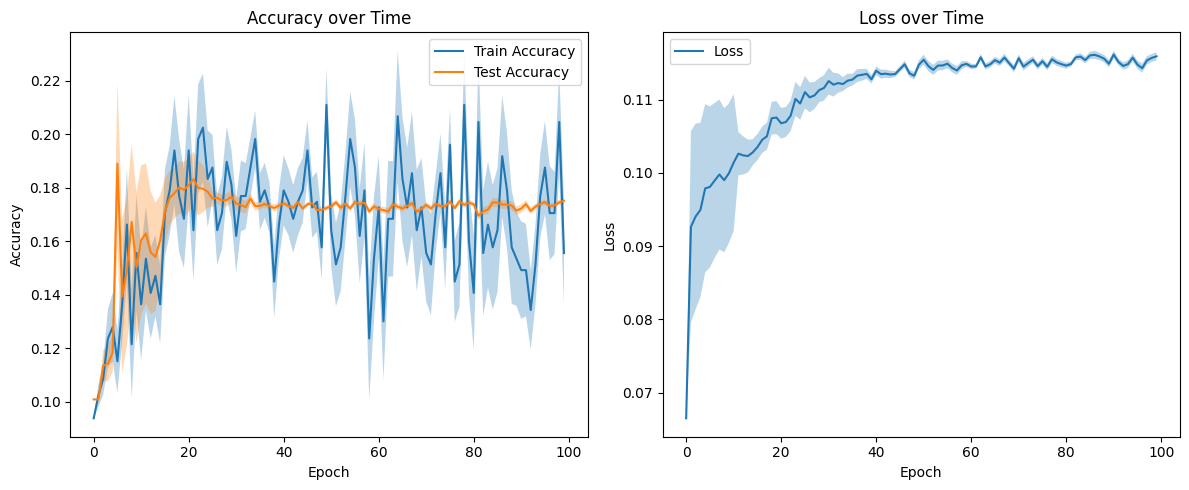

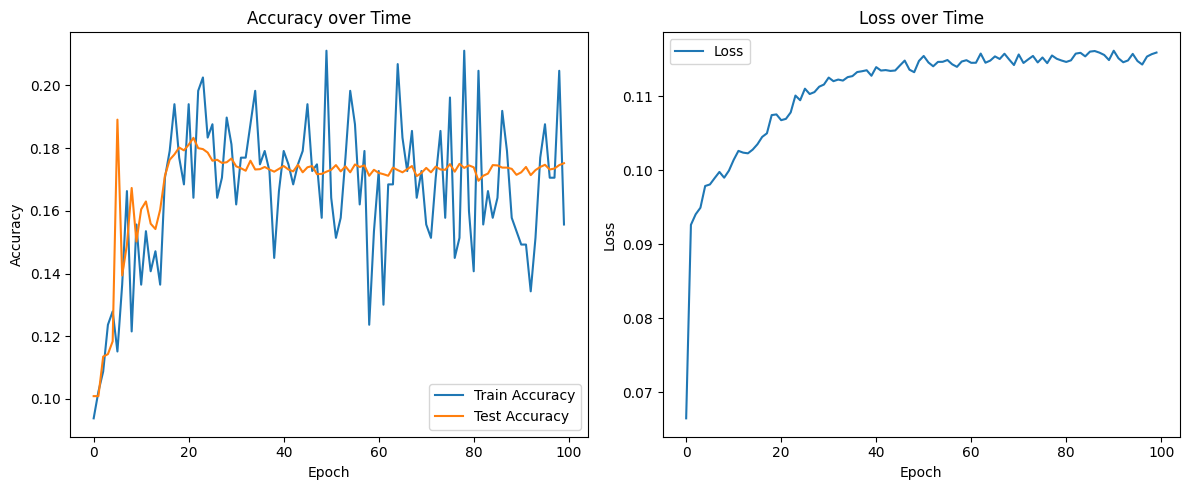

Final Train Accuracy: 0.16 ± 0.02
Final Test Accuracy: 0.18 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1723743461:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.0663925425044255
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723743461:   1%|          | 1/100 [00:05<09:24,  5.70s/it]

 Test accuracy:  0.1105

correct: 48 total: 469
loss: 0.08795485400092373
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723743461:   2%|▏         | 2/100 [00:11<09:26,  5.78s/it]

 Test accuracy:  0.1088

correct: 47 total: 469
loss: 0.0915396709018933
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723743461:   3%|▎         | 3/100 [00:17<09:38,  5.96s/it]

 Test accuracy:  0.1151

correct: 47 total: 469
loss: 0.09076574700537013
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723743461:   4%|▍         | 4/100 [00:23<09:37,  6.02s/it]

 Test accuracy:  0.1133

correct: 56 total: 469
loss: 0.09313052624209857
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723743461:   5%|▌         | 5/100 [00:29<09:32,  6.03s/it]

 Test accuracy:  0.112

correct: 53 total: 469
loss: 0.09406366335875443
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1723743461:   6%|▌         | 6/100 [00:35<09:19,  5.96s/it]

 Test accuracy:  0.1133

correct: 49 total: 469
loss: 0.09481598312920853
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1723743461:   7%|▋         | 7/100 [00:41<09:17,  6.00s/it]

 Test accuracy:  0.115

correct: 48 total: 469
loss: 0.094589496345154
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723743461:   8%|▊         | 8/100 [00:47<09:15,  6.04s/it]

 Test accuracy:  0.1148

correct: 58 total: 469
loss: 0.0951464310892101
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723743461:   9%|▉         | 9/100 [00:53<09:07,  6.01s/it]

 Test accuracy:  0.1164

correct: 61 total: 469
loss: 0.0964060054182498
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723743461:  10%|█         | 10/100 [00:59<09:02,  6.03s/it]

 Test accuracy:  0.1159

correct: 48 total: 469
loss: 0.09658187236994314
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723743461:  11%|█         | 11/100 [01:06<09:04,  6.12s/it]

 Test accuracy:  0.1107

correct: 57 total: 469
loss: 0.09716747747237749
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723743461:  12%|█▏        | 12/100 [01:12<08:57,  6.11s/it]

 Test accuracy:  0.1146

correct: 49 total: 469
loss: 0.09713435266762654
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1723743461:  13%|█▎        | 13/100 [01:18<08:51,  6.11s/it]

 Test accuracy:  0.1169

correct: 41 total: 469
loss: 0.09588405138838774
 Train accuracy:  0.08742004264392324 | 


MLP_MNIST_0_1723743461:  14%|█▍        | 14/100 [01:24<08:42,  6.07s/it]

 Test accuracy:  0.1134

correct: 60 total: 469
loss: 0.09647382729089082
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723743461:  15%|█▌        | 15/100 [01:30<08:37,  6.09s/it]

 Test accuracy:  0.1162

correct: 65 total: 469
loss: 0.09693679534423072
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723743461:  16%|█▌        | 16/100 [01:36<08:27,  6.04s/it]

 Test accuracy:  0.1159

correct: 56 total: 469
loss: 0.09750740272975934
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723743461:  17%|█▋        | 17/100 [01:42<08:19,  6.02s/it]

 Test accuracy:  0.1197

correct: 51 total: 469
loss: 0.09699107898768586
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1723743461:  18%|█▊        | 18/100 [01:48<08:16,  6.05s/it]

 Test accuracy:  0.1171

correct: 60 total: 469
loss: 0.09879256956485798
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723743461:  19%|█▉        | 19/100 [01:54<08:13,  6.09s/it]

 Test accuracy:  0.1187

correct: 53 total: 469
loss: 0.09821237992249064
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1723743461:  20%|██        | 20/100 [02:00<08:06,  6.08s/it]

 Test accuracy:  0.116

correct: 57 total: 469
loss: 0.09791731780398884
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723743461:  21%|██        | 21/100 [02:06<08:00,  6.08s/it]

 Test accuracy:  0.1213

correct: 53 total: 469
loss: 0.09740517874643492
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1723743461:  22%|██▏       | 22/100 [02:12<07:53,  6.07s/it]

 Test accuracy:  0.1198

correct: 54 total: 469
loss: 0.09754563283437351
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723743461:  23%|██▎       | 23/100 [02:19<07:54,  6.17s/it]

 Test accuracy:  0.1193

correct: 59 total: 469
loss: 0.0984235727615448
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723743461:  24%|██▍       | 24/100 [02:26<08:01,  6.34s/it]

 Test accuracy:  0.1202

correct: 65 total: 469
loss: 0.09882075220409996
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723743461:  25%|██▌       | 25/100 [02:32<07:51,  6.28s/it]

 Test accuracy:  0.1185

correct: 52 total: 469
loss: 0.09946086141727627
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1723743461:  26%|██▌       | 26/100 [02:38<07:45,  6.29s/it]

 Test accuracy:  0.1218

correct: 66 total: 469
loss: 0.09837771191208093
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723743461:  27%|██▋       | 27/100 [02:44<07:41,  6.32s/it]

 Test accuracy:  0.119

correct: 54 total: 469
loss: 0.09900911041160128
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723743461:  28%|██▊       | 28/100 [02:51<07:34,  6.31s/it]

 Test accuracy:  0.1167

correct: 60 total: 469
loss: 0.09890710967563109
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723743461:  29%|██▉       | 29/100 [02:57<07:30,  6.35s/it]

 Test accuracy:  0.1195

correct: 56 total: 469
loss: 0.0991955023330412
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723743461:  30%|███       | 30/100 [03:03<07:20,  6.30s/it]

 Test accuracy:  0.1217

correct: 52 total: 469
loss: 0.09964450231111889
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1723743461:  31%|███       | 31/100 [03:10<07:13,  6.28s/it]

 Test accuracy:  0.1214

correct: 70 total: 469
loss: 0.09998368509987524
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1723743461:  32%|███▏      | 32/100 [03:16<07:04,  6.24s/it]

 Test accuracy:  0.1207

correct: 64 total: 469
loss: 0.10004968817300125
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723743461:  33%|███▎      | 33/100 [03:22<06:59,  6.26s/it]

 Test accuracy:  0.1195

correct: 58 total: 469
loss: 0.09926199596891525
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723743461:  34%|███▍      | 34/100 [03:28<06:55,  6.30s/it]

 Test accuracy:  0.121

correct: 65 total: 469
loss: 0.10040614309150782
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723743461:  35%|███▌      | 35/100 [03:35<06:46,  6.25s/it]

 Test accuracy:  0.1228

correct: 64 total: 469
loss: 0.10064092680398844
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723743461:  36%|███▌      | 36/100 [03:41<06:35,  6.18s/it]

 Test accuracy:  0.1204

correct: 47 total: 469
loss: 0.1007748323399375
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723743461:  37%|███▋      | 37/100 [03:47<06:30,  6.20s/it]

 Test accuracy:  0.1195

correct: 56 total: 469
loss: 0.10146128676974697
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723743461:  38%|███▊      | 38/100 [03:53<06:23,  6.18s/it]

 Test accuracy:  0.1176

correct: 51 total: 469
loss: 0.10055435976303463
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1723743461:  39%|███▉      | 39/100 [03:59<06:17,  6.19s/it]

 Test accuracy:  0.1162

correct: 55 total: 469
loss: 0.09969607114728325
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1723743461:  40%|████      | 40/100 [04:05<06:10,  6.18s/it]

 Test accuracy:  0.1219

correct: 54 total: 469
loss: 0.10090801269133716
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723743461:  41%|████      | 41/100 [04:11<06:03,  6.17s/it]

 Test accuracy:  0.1208

correct: 62 total: 469
loss: 0.10040505239958449
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1723743461:  42%|████▏     | 42/100 [04:18<05:56,  6.15s/it]

 Test accuracy:  0.121

correct: 53 total: 469
loss: 0.10035444365572065
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1723743461:  43%|████▎     | 43/100 [04:24<05:52,  6.19s/it]

 Test accuracy:  0.1188

correct: 54 total: 469
loss: 0.09992507800682267
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723743461:  44%|████▍     | 44/100 [04:30<05:49,  6.23s/it]

 Test accuracy:  0.1189

correct: 58 total: 469
loss: 0.10051131065783979
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723743461:  45%|████▌     | 45/100 [04:36<05:43,  6.24s/it]

 Test accuracy:  0.116

correct: 69 total: 469
loss: 0.10126060716061196
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1723743461:  46%|████▌     | 46/100 [04:43<05:38,  6.26s/it]

 Test accuracy:  0.1208

correct: 48 total: 469
loss: 0.10095597444566837
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723743461:  47%|████▋     | 47/100 [04:49<05:30,  6.23s/it]

 Test accuracy:  0.1187

correct: 57 total: 469
loss: 0.10025606903313065
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723743461:  48%|████▊     | 48/100 [04:55<05:23,  6.22s/it]

 Test accuracy:  0.1151

correct: 56 total: 469
loss: 0.10016526151567634
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723743461:  49%|████▉     | 49/100 [05:02<05:28,  6.44s/it]

 Test accuracy:  0.1184

correct: 58 total: 469
loss: 0.1009429959473071
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723743461:  50%|█████     | 50/100 [05:08<05:20,  6.41s/it]

 Test accuracy:  0.1196

correct: 59 total: 469
loss: 0.1022348845246504
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723743461:  51%|█████     | 51/100 [05:15<05:12,  6.37s/it]

 Test accuracy:  0.1227

correct: 52 total: 469
loss: 0.10149663831315824
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1723743461:  52%|█████▏    | 52/100 [05:21<05:05,  6.36s/it]

 Test accuracy:  0.1209

correct: 60 total: 469
loss: 0.1012701417909248
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723743461:  53%|█████▎    | 53/100 [05:27<04:56,  6.31s/it]

 Test accuracy:  0.1191

correct: 61 total: 469
loss: 0.1006516287607679
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723743461:  54%|█████▍    | 54/100 [05:34<04:51,  6.34s/it]

 Test accuracy:  0.1198

correct: 63 total: 469
loss: 0.10157027216290614
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723743461:  55%|█████▌    | 55/100 [05:40<04:42,  6.29s/it]

 Test accuracy:  0.1187

correct: 64 total: 469
loss: 0.10133214347334558
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723743461:  56%|█████▌    | 56/100 [05:46<04:35,  6.26s/it]

 Test accuracy:  0.1201

correct: 54 total: 469
loss: 0.10097717971944098
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723743461:  57%|█████▋    | 57/100 [05:52<04:28,  6.24s/it]

 Test accuracy:  0.121

correct: 65 total: 469
loss: 0.10170709159074308
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723743461:  58%|█████▊    | 58/100 [05:58<04:20,  6.21s/it]

 Test accuracy:  0.1202

correct: 42 total: 469
loss: 0.10012669128967501
 Train accuracy:  0.08955223880597014 | 


MLP_MNIST_0_1723743461:  59%|█████▉    | 59/100 [06:05<04:14,  6.21s/it]

 Test accuracy:  0.1208

correct: 46 total: 469
loss: 0.10152829930917032
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1723743461:  60%|██████    | 60/100 [06:11<04:07,  6.20s/it]

 Test accuracy:  0.1189

correct: 61 total: 469
loss: 0.10076179776364552
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723743461:  61%|██████    | 61/100 [06:17<04:00,  6.18s/it]

 Test accuracy:  0.1175

correct: 37 total: 469
loss: 0.10165167504599862
 Train accuracy:  0.07889125799573561 | 


MLP_MNIST_0_1723743461:  62%|██████▏   | 62/100 [06:23<03:54,  6.17s/it]

 Test accuracy:  0.1191

correct: 56 total: 469
loss: 0.10175177439062326
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723743461:  63%|██████▎   | 63/100 [06:29<03:49,  6.20s/it]

 Test accuracy:  0.1234

correct: 61 total: 469
loss: 0.10015104215409455
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723743461:  64%|██████▍   | 64/100 [06:36<03:43,  6.22s/it]

 Test accuracy:  0.1206

correct: 56 total: 469
loss: 0.10123471184961323
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723743461:  65%|██████▌   | 65/100 [06:42<03:37,  6.22s/it]

 Test accuracy:  0.1186

correct: 52 total: 469
loss: 0.10113661629813057
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1723743461:  66%|██████▌   | 66/100 [06:48<03:31,  6.22s/it]

 Test accuracy:  0.1236

correct: 61 total: 469
loss: 0.10084748496887272
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723743461:  67%|██████▋   | 67/100 [06:54<03:25,  6.22s/it]

 Test accuracy:  0.1237

correct: 61 total: 469
loss: 0.10219874609507985
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723743461:  68%|██████▊   | 68/100 [07:01<03:20,  6.26s/it]

 Test accuracy:  0.118

correct: 56 total: 469
loss: 0.1016173793562948
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723743461:  69%|██████▉   | 69/100 [07:07<03:16,  6.33s/it]

 Test accuracy:  0.1202

correct: 63 total: 469
loss: 0.10121036433716064
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723743461:  70%|███████   | 70/100 [07:13<03:09,  6.31s/it]

 Test accuracy:  0.1227

correct: 63 total: 469
loss: 0.10147757113361155
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723743461:  71%|███████   | 71/100 [07:20<03:02,  6.28s/it]

 Test accuracy:  0.1191

correct: 49 total: 469
loss: 0.10092596601702765
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1723743461:  72%|███████▏  | 72/100 [07:26<02:55,  6.26s/it]

 Test accuracy:  0.1203

correct: 54 total: 469
loss: 0.10100084139721226
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723743461:  73%|███████▎  | 73/100 [07:32<02:49,  6.27s/it]

 Test accuracy:  0.1235

correct: 59 total: 469
loss: 0.10178243665934117
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723743461:  74%|███████▍  | 74/100 [07:39<02:44,  6.34s/it]

 Test accuracy:  0.122

correct: 52 total: 469
loss: 0.1014760431768035
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1723743461:  75%|███████▌  | 75/100 [07:45<02:38,  6.34s/it]

 Test accuracy:  0.118

correct: 54 total: 469
loss: 0.1011701570009626
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723743461:  76%|███████▌  | 76/100 [07:51<02:31,  6.32s/it]

 Test accuracy:  0.1172

correct: 59 total: 469
loss: 0.10000727068323062
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723743461:  77%|███████▋  | 77/100 [07:57<02:25,  6.31s/it]

 Test accuracy:  0.1197

correct: 50 total: 469
loss: 0.10167238978879538
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1723743461:  78%|███████▊  | 78/100 [08:04<02:18,  6.32s/it]

 Test accuracy:  0.1223

correct: 57 total: 469
loss: 0.10135714550897765
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723743461:  79%|███████▉  | 79/100 [08:10<02:14,  6.40s/it]

 Test accuracy:  0.1204

correct: 58 total: 469
loss: 0.10089720888877474
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723743461:  80%|████████  | 80/100 [08:17<02:08,  6.43s/it]

 Test accuracy:  0.1186

correct: 49 total: 469
loss: 0.10077838664814862
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1723743461:  81%|████████  | 81/100 [08:23<02:00,  6.37s/it]

 Test accuracy:  0.1209

correct: 52 total: 469
loss: 0.10051957090526248
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1723743461:  82%|████████▏ | 82/100 [08:29<01:54,  6.34s/it]

 Test accuracy:  0.1195

correct: 47 total: 469
loss: 0.10196367600388619
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723743461:  83%|████████▎ | 83/100 [08:36<01:47,  6.33s/it]

 Test accuracy:  0.1203

correct: 57 total: 469
loss: 0.10182215918355914
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723743461:  84%|████████▍ | 84/100 [08:42<01:41,  6.36s/it]

 Test accuracy:  0.1186

correct: 54 total: 469
loss: 0.10123313037253646
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723743461:  85%|████████▌ | 85/100 [08:48<01:35,  6.36s/it]

 Test accuracy:  0.1207

correct: 59 total: 469
loss: 0.10139340340201534
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723743461:  86%|████████▌ | 86/100 [08:55<01:28,  6.34s/it]

 Test accuracy:  0.1193

correct: 51 total: 469
loss: 0.10124201114688601
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1723743461:  87%|████████▋ | 87/100 [09:01<01:22,  6.32s/it]

 Test accuracy:  0.1239

correct: 57 total: 469
loss: 0.1020437233261208
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723743461:  88%|████████▊ | 88/100 [09:07<01:16,  6.34s/it]

 Test accuracy:  0.1212

correct: 51 total: 469
loss: 0.10149550426806976
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1723743461:  89%|████████▉ | 89/100 [09:14<01:10,  6.37s/it]

 Test accuracy:  0.1162

correct: 65 total: 469
loss: 0.10087585886086482
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723743461:  90%|█████████ | 90/100 [09:20<01:04,  6.41s/it]

 Test accuracy:  0.1184

correct: 47 total: 469
loss: 0.10188920686303425
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723743461:  91%|█████████ | 91/100 [09:27<00:57,  6.43s/it]

 Test accuracy:  0.1162

correct: 64 total: 469
loss: 0.10085918865541914
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723743461:  92%|█████████▏| 92/100 [09:33<00:51,  6.42s/it]

 Test accuracy:  0.1176

correct: 53 total: 469
loss: 0.10103399513055013
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1723743461:  93%|█████████▎| 93/100 [09:40<00:44,  6.42s/it]

 Test accuracy:  0.1178

correct: 65 total: 469
loss: 0.10012572090318209
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723743461:  94%|█████████▍| 94/100 [09:46<00:39,  6.51s/it]

 Test accuracy:  0.12

correct: 62 total: 469
loss: 0.10149949955851284
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1723743461:  95%|█████████▌| 95/100 [09:53<00:33,  6.64s/it]

 Test accuracy:  0.1226

correct: 53 total: 469
loss: 0.10090795583498757
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1723743461:  96%|█████████▌| 96/100 [10:00<00:26,  6.56s/it]

 Test accuracy:  0.1169

correct: 49 total: 469
loss: 0.10066139427964875
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1723743461:  97%|█████████▋| 97/100 [10:06<00:19,  6.52s/it]

 Test accuracy:  0.1205

correct: 67 total: 469
loss: 0.10115079322794099
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1723743461:  98%|█████████▊| 98/100 [10:13<00:12,  6.49s/it]

 Test accuracy:  0.1206

correct: 56 total: 469
loss: 0.10007375105421172
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723743461:  99%|█████████▉| 99/100 [10:19<00:06,  6.53s/it]

 Test accuracy:  0.119

correct: 59 total: 469
loss: 0.10176613162766134
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723743461: 100%|██████████| 100/100 [10:26<00:00,  6.26s/it]

 Test accuracy:  0.1202


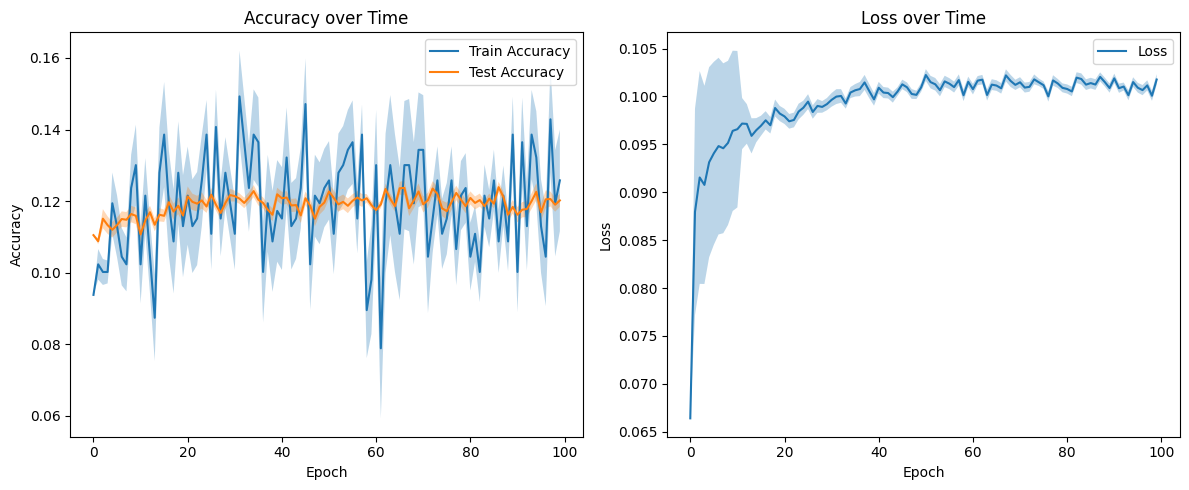

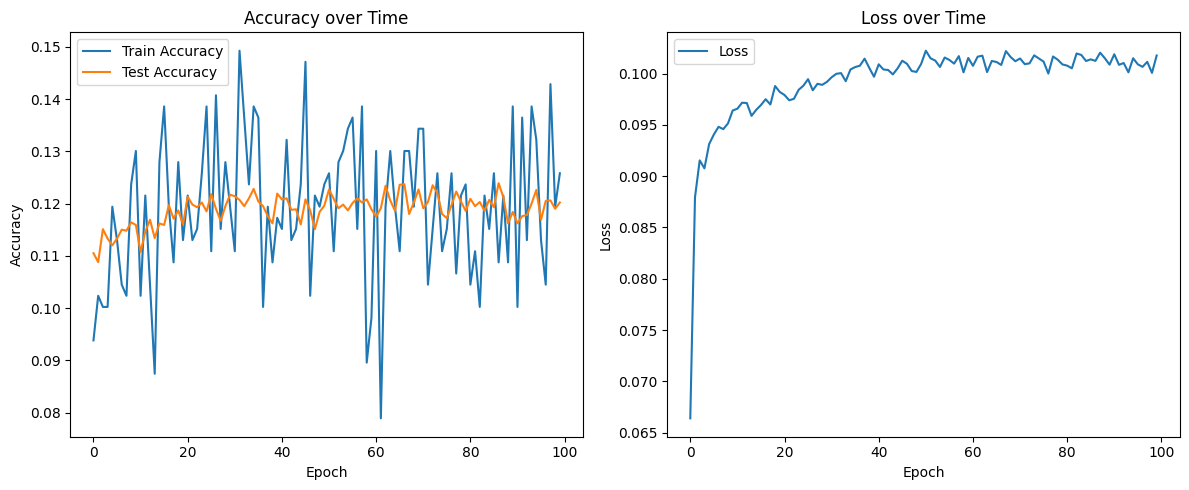

Final Train Accuracy: 0.13 ± 0.01
Final Test Accuracy: 0.12 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1723744092:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.05944644697884253
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723744092:   1%|          | 1/100 [00:04<08:04,  4.89s/it]

 Test accuracy:  0.1052

correct: 48 total: 469
loss: 0.12066578421829098
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723744092:   2%|▏         | 2/100 [00:10<08:13,  5.03s/it]

 Test accuracy:  0.1061

correct: 51 total: 469
loss: 0.1130543668418805
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1723744092:   3%|▎         | 3/100 [00:15<08:10,  5.06s/it]

 Test accuracy:  0.1063

correct: 50 total: 469
loss: 0.09810474178175936
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1723744092:   4%|▍         | 4/100 [00:20<08:17,  5.18s/it]

 Test accuracy:  0.112

correct: 47 total: 469
loss: 0.1091865269916017
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723744092:   5%|▌         | 5/100 [00:25<08:09,  5.15s/it]

 Test accuracy:  0.1123

correct: 37 total: 469
loss: 0.11077541116077
 Train accuracy:  0.07889125799573561 | 


MLP_MNIST_0_1723744092:   6%|▌         | 6/100 [00:30<08:04,  5.15s/it]

 Test accuracy:  0.1111

correct: 42 total: 469
loss: 0.1001580595366482
 Train accuracy:  0.08955223880597014 | 


MLP_MNIST_0_1723744092:   7%|▋         | 7/100 [00:35<08:01,  5.18s/it]

 Test accuracy:  0.1113

correct: 42 total: 469
loss: 0.09777559039752874
 Train accuracy:  0.08955223880597014 | 


MLP_MNIST_0_1723744092:   8%|▊         | 8/100 [00:41<08:00,  5.22s/it]

 Test accuracy:  0.1057

correct: 56 total: 469
loss: 0.09413250367333895
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723744092:   9%|▉         | 9/100 [00:46<07:56,  5.23s/it]

 Test accuracy:  0.1075

correct: 43 total: 469
loss: 0.0944708728237447
 Train accuracy:  0.09168443496801706 | 


MLP_MNIST_0_1723744092:  10%|█         | 10/100 [00:51<07:52,  5.25s/it]

 Test accuracy:  0.1107

correct: 44 total: 469
loss: 0.09823221389228093
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723744092:  11%|█         | 11/100 [00:57<07:47,  5.25s/it]

 Test accuracy:  0.1074

correct: 51 total: 469
loss: 0.09376648641916226
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1723744092:  12%|█▏        | 12/100 [01:02<07:41,  5.25s/it]

 Test accuracy:  0.1136

correct: 61 total: 469
loss: 0.09447504969230339
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723744092:  13%|█▎        | 13/100 [01:07<07:37,  5.26s/it]

 Test accuracy:  0.1094

correct: 57 total: 469
loss: 0.09543435019788457
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723744092:  14%|█▍        | 14/100 [01:12<07:34,  5.28s/it]

 Test accuracy:  0.1092

correct: 41 total: 469
loss: 0.09720330561465546
 Train accuracy:  0.08742004264392324 | 


MLP_MNIST_0_1723744092:  15%|█▌        | 15/100 [01:18<07:28,  5.28s/it]

 Test accuracy:  0.1114

correct: 55 total: 469
loss: 0.09549440143268499
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1723744092:  16%|█▌        | 16/100 [01:23<07:26,  5.31s/it]

 Test accuracy:  0.1085

correct: 56 total: 469
loss: 0.09718524763134243
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723744092:  17%|█▋        | 17/100 [01:28<07:20,  5.31s/it]

 Test accuracy:  0.1114

correct: 44 total: 469
loss: 0.0956800142839265
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723744092:  18%|█▊        | 18/100 [01:34<07:11,  5.26s/it]

 Test accuracy:  0.1097

correct: 50 total: 469
loss: 0.09475979272490626
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1723744092:  19%|█▉        | 19/100 [01:39<07:05,  5.25s/it]

 Test accuracy:  0.1095

correct: 53 total: 469
loss: 0.09539838853294152
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1723744092:  20%|██        | 20/100 [01:44<06:59,  5.24s/it]

 Test accuracy:  0.1073

correct: 56 total: 469
loss: 0.095825075070614
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723744092:  21%|██        | 21/100 [01:49<06:56,  5.27s/it]

 Test accuracy:  0.1123

correct: 50 total: 469
loss: 0.09567600291675088
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1723744092:  22%|██▏       | 22/100 [01:55<06:58,  5.37s/it]

 Test accuracy:  0.1089

correct: 43 total: 469
loss: 0.09640367630956524
 Train accuracy:  0.09168443496801706 | 


MLP_MNIST_0_1723744092:  23%|██▎       | 23/100 [02:00<06:53,  5.37s/it]

 Test accuracy:  0.1127

correct: 62 total: 469
loss: 0.09756630900572104
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1723744092:  24%|██▍       | 24/100 [02:06<06:48,  5.37s/it]

 Test accuracy:  0.1096

correct: 55 total: 469
loss: 0.0986434225080364
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1723744092:  25%|██▌       | 25/100 [02:11<06:42,  5.36s/it]

 Test accuracy:  0.1072

correct: 57 total: 469
loss: 0.09886710072504178
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723744092:  26%|██▌       | 26/100 [02:16<06:37,  5.37s/it]

 Test accuracy:  0.1113

correct: 46 total: 469
loss: 0.09752931496672539
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1723744092:  27%|██▋       | 27/100 [02:22<06:32,  5.37s/it]

 Test accuracy:  0.1119

correct: 49 total: 469
loss: 0.0995420244202685
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1723744092:  28%|██▊       | 28/100 [02:27<06:31,  5.43s/it]

 Test accuracy:  0.1095

correct: 47 total: 469
loss: 0.09996092527596427
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723744092:  29%|██▉       | 29/100 [02:33<06:24,  5.41s/it]

 Test accuracy:  0.1097

correct: 52 total: 469
loss: 0.09965697183474295
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1723744092:  30%|███       | 30/100 [02:38<06:18,  5.40s/it]

 Test accuracy:  0.1153

correct: 63 total: 469
loss: 0.10215455141148842
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723744092:  31%|███       | 31/100 [02:44<06:16,  5.46s/it]

 Test accuracy:  0.1165

correct: 54 total: 469
loss: 0.10177740561110633
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723744092:  32%|███▏      | 32/100 [02:49<06:12,  5.48s/it]

 Test accuracy:  0.1108

correct: 48 total: 469
loss: 0.10149432623437218
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723744092:  33%|███▎      | 33/100 [02:55<06:08,  5.50s/it]

 Test accuracy:  0.1117

correct: 53 total: 469
loss: 0.10501237412187844
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1723744092:  34%|███▍      | 34/100 [03:00<06:03,  5.51s/it]

 Test accuracy:  0.1072

correct: 52 total: 469
loss: 0.10425210094401069
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1723744092:  35%|███▌      | 35/100 [03:06<05:57,  5.50s/it]

 Test accuracy:  0.1144

correct: 43 total: 469
loss: 0.1056293915710978
 Train accuracy:  0.09168443496801706 | 


MLP_MNIST_0_1723744092:  36%|███▌      | 36/100 [03:11<05:52,  5.51s/it]

 Test accuracy:  0.1147

correct: 53 total: 469
loss: 0.10595656791602624
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1723744092:  37%|███▋      | 37/100 [03:17<05:50,  5.57s/it]

 Test accuracy:  0.1137

correct: 51 total: 469
loss: 0.11026863933308546
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1723744092:  38%|███▊      | 38/100 [03:22<05:41,  5.51s/it]

 Test accuracy:  0.1117

correct: 49 total: 469
loss: 0.10269963417226063
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1723744092:  39%|███▉      | 39/100 [03:28<05:37,  5.53s/it]

 Test accuracy:  0.1124

correct: 47 total: 469
loss: 0.10944594779629697
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723744092:  40%|████      | 40/100 [03:34<05:32,  5.54s/it]

 Test accuracy:  0.1069

correct: 43 total: 469
loss: 0.10844426187497974
 Train accuracy:  0.09168443496801706 | 


MLP_MNIST_0_1723744092:  41%|████      | 41/100 [03:39<05:24,  5.50s/it]

 Test accuracy:  0.1153

correct: 58 total: 469
loss: 0.10794115973624593
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723744092:  42%|████▏     | 42/100 [03:44<05:16,  5.46s/it]

 Test accuracy:  0.1105

correct: 48 total: 469
loss: 0.10911641830701564
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723744092:  43%|████▎     | 43/100 [03:50<05:11,  5.47s/it]

 Test accuracy:  0.1114

correct: 50 total: 469
loss: 0.10445569449269188
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1723744092:  44%|████▍     | 44/100 [03:55<05:04,  5.44s/it]

 Test accuracy:  0.1144

correct: 43 total: 469
loss: 0.1077781863558267
 Train accuracy:  0.09168443496801706 | 


MLP_MNIST_0_1723744092:  45%|████▌     | 45/100 [04:01<05:03,  5.52s/it]

 Test accuracy:  0.1187

correct: 45 total: 469
loss: 0.10668319031627956
 Train accuracy:  0.09594882729211088 | 


MLP_MNIST_0_1723744092:  46%|████▌     | 46/100 [04:06<04:57,  5.51s/it]

 Test accuracy:  0.1213

correct: 54 total: 469
loss: 0.10544305089821439
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723744092:  47%|████▋     | 47/100 [04:12<04:50,  5.47s/it]

 Test accuracy:  0.1137

correct: 48 total: 469
loss: 0.10830713147674796
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723744092:  48%|████▊     | 48/100 [04:17<04:45,  5.50s/it]

 Test accuracy:  0.1142

correct: 52 total: 469
loss: 0.10703846046538242
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1723744092:  49%|████▉     | 49/100 [04:23<04:47,  5.63s/it]

 Test accuracy:  0.1065

correct: 51 total: 469
loss: 0.11052804475209352
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1723744092:  50%|█████     | 50/100 [04:29<04:39,  5.60s/it]

 Test accuracy:  0.114

correct: 46 total: 469
loss: 0.11265082811432353
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1723744092:  51%|█████     | 51/100 [04:34<04:33,  5.59s/it]

 Test accuracy:  0.1118

correct: 46 total: 469
loss: 0.10968901393319498
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1723744092:  52%|█████▏    | 52/100 [04:40<04:28,  5.60s/it]

 Test accuracy:  0.1101

correct: 50 total: 469
loss: 0.10978482617561751
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1723744092:  53%|█████▎    | 53/100 [04:45<04:21,  5.56s/it]

 Test accuracy:  0.1109

correct: 47 total: 469
loss: 0.11174871821774603
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723744092:  54%|█████▍    | 54/100 [04:51<04:14,  5.54s/it]

 Test accuracy:  0.1099

correct: 55 total: 469
loss: 0.10976605544657086
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1723744092:  55%|█████▌    | 55/100 [04:56<04:08,  5.52s/it]

 Test accuracy:  0.1103

correct: 59 total: 469
loss: 0.1104457530258561
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723744092:  56%|█████▌    | 56/100 [05:02<04:03,  5.54s/it]

 Test accuracy:  0.1073

correct: 40 total: 469
loss: 0.11137404099011472
 Train accuracy:  0.08528784648187633 | 


MLP_MNIST_0_1723744092:  57%|█████▋    | 57/100 [05:08<03:58,  5.54s/it]

 Test accuracy:  0.1089

correct: 51 total: 469
loss: 0.11507508643209807
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1723744092:  58%|█████▊    | 58/100 [05:13<03:52,  5.53s/it]

 Test accuracy:  0.1099

correct: 46 total: 469
loss: 0.1126125799472144
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1723744092:  59%|█████▉    | 59/100 [05:19<03:47,  5.55s/it]

 Test accuracy:  0.1099

correct: 63 total: 469
loss: 0.11202839037566296
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723744092:  60%|██████    | 60/100 [05:24<03:41,  5.53s/it]

 Test accuracy:  0.1107

correct: 49 total: 469
loss: 0.11740822810481098
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1723744092:  61%|██████    | 61/100 [05:30<03:35,  5.53s/it]

 Test accuracy:  0.1151

correct: 47 total: 469
loss: 0.11484132543492165
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723744092:  62%|██████▏   | 62/100 [05:35<03:30,  5.54s/it]

 Test accuracy:  0.1086

correct: 54 total: 469
loss: 0.10923939751091796
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723744092:  63%|██████▎   | 63/100 [05:41<03:24,  5.52s/it]

 Test accuracy:  0.1136

correct: 50 total: 469
loss: 0.10988087208667544
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1723744092:  64%|██████▍   | 64/100 [05:46<03:18,  5.51s/it]

 Test accuracy:  0.1108

correct: 55 total: 469
loss: 0.11206569857815944
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1723744092:  65%|██████▌   | 65/100 [05:52<03:14,  5.54s/it]

 Test accuracy:  0.1044

correct: 41 total: 469
loss: 0.1104906224874037
 Train accuracy:  0.08742004264392324 | 


MLP_MNIST_0_1723744092:  66%|██████▌   | 66/100 [05:57<03:08,  5.54s/it]

 Test accuracy:  0.1146

correct: 56 total: 469
loss: 0.11395734526328187
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723744092:  67%|██████▋   | 67/100 [06:03<03:03,  5.55s/it]

 Test accuracy:  0.1125

correct: 46 total: 469
loss: 0.1108946887446619
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1723744092:  68%|██████▊   | 68/100 [06:08<02:57,  5.56s/it]

 Test accuracy:  0.1137

correct: 43 total: 469
loss: 0.10918648464720386
 Train accuracy:  0.09168443496801706 | 


MLP_MNIST_0_1723744092:  69%|██████▉   | 69/100 [06:14<02:51,  5.52s/it]

 Test accuracy:  0.1121

correct: 56 total: 469
loss: 0.11046863388595805
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723744092:  70%|███████   | 70/100 [06:19<02:45,  5.51s/it]

 Test accuracy:  0.1136

correct: 48 total: 469
loss: 0.11134012559774334
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723744092:  71%|███████   | 71/100 [06:25<02:39,  5.49s/it]

 Test accuracy:  0.1104

correct: 53 total: 469
loss: 0.10942831367000079
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1723744092:  72%|███████▏  | 72/100 [06:30<02:34,  5.53s/it]

 Test accuracy:  0.1125

correct: 48 total: 469
loss: 0.11139352332109581
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723744092:  73%|███████▎  | 73/100 [06:36<02:30,  5.58s/it]

 Test accuracy:  0.111

correct: 47 total: 469
loss: 0.11080187881615625
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723744092:  74%|███████▍  | 74/100 [06:42<02:26,  5.62s/it]

 Test accuracy:  0.1141

correct: 58 total: 469
loss: 0.1115168230747109
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723744092:  75%|███████▌  | 75/100 [06:48<02:20,  5.64s/it]

 Test accuracy:  0.1142

correct: 64 total: 469
loss: 0.11201914965407427
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723744092:  76%|███████▌  | 76/100 [06:53<02:15,  5.64s/it]

 Test accuracy:  0.109

correct: 53 total: 469
loss: 0.10981096683153466
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1723744092:  77%|███████▋  | 77/100 [06:59<02:09,  5.65s/it]

 Test accuracy:  0.1138

correct: 43 total: 469
loss: 0.11159482375899357
 Train accuracy:  0.09168443496801706 | 


MLP_MNIST_0_1723744092:  78%|███████▊  | 78/100 [07:05<02:04,  5.67s/it]

 Test accuracy:  0.1148

correct: 65 total: 469
loss: 0.10872074354813298
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723744092:  79%|███████▉  | 79/100 [07:11<02:01,  5.79s/it]

 Test accuracy:  0.1117

correct: 51 total: 469
loss: 0.11380303692398296
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1723744092:  80%|████████  | 80/100 [07:16<01:55,  5.78s/it]

 Test accuracy:  0.1096

correct: 49 total: 469
loss: 0.11252356768607585
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1723744092:  81%|████████  | 81/100 [07:22<01:49,  5.77s/it]

 Test accuracy:  0.1058

correct: 61 total: 469
loss: 0.11541200966151284
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723744092:  82%|████████▏ | 82/100 [07:28<01:43,  5.75s/it]

 Test accuracy:  0.1115

correct: 62 total: 469
loss: 0.11354650620585566
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1723744092:  83%|████████▎ | 83/100 [07:34<01:37,  5.72s/it]

 Test accuracy:  0.1127

correct: 44 total: 469
loss: 0.1166509225138469
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723744092:  84%|████████▍ | 84/100 [07:39<01:31,  5.74s/it]

 Test accuracy:  0.1105

correct: 48 total: 469
loss: 0.11713556967564483
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723744092:  85%|████████▌ | 85/100 [07:45<01:26,  5.75s/it]

 Test accuracy:  0.1121

correct: 50 total: 469
loss: 0.11429974980064547
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1723744092:  86%|████████▌ | 86/100 [07:51<01:20,  5.73s/it]

 Test accuracy:  0.1149

correct: 65 total: 469
loss: 0.11152235394728972
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723744092:  87%|████████▋ | 87/100 [07:57<01:14,  5.74s/it]

 Test accuracy:  0.1148

correct: 60 total: 469
loss: 0.11859540817643534
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723744092:  88%|████████▊ | 88/100 [08:02<01:09,  5.76s/it]

 Test accuracy:  0.1048

correct: 44 total: 469
loss: 0.11338116740112875
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723744092:  89%|████████▉ | 89/100 [08:08<01:03,  5.77s/it]

 Test accuracy:  0.1171

correct: 59 total: 469
loss: 0.11437119851742726
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723744092:  90%|█████████ | 90/100 [08:14<00:58,  5.82s/it]

 Test accuracy:  0.1093

correct: 71 total: 469
loss: 0.11239258273006249
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1723744092:  91%|█████████ | 91/100 [08:20<00:52,  5.82s/it]

 Test accuracy:  0.1113

correct: 58 total: 469
loss: 0.11277251750993322
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723744092:  92%|█████████▏| 92/100 [08:26<00:46,  5.81s/it]

 Test accuracy:  0.1057

correct: 54 total: 469
loss: 0.1111775994904514
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723744092:  93%|█████████▎| 93/100 [08:31<00:40,  5.82s/it]

 Test accuracy:  0.1133

correct: 53 total: 469
loss: 0.11306604383978
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1723744092:  94%|█████████▍| 94/100 [08:37<00:34,  5.83s/it]

 Test accuracy:  0.1157

correct: 54 total: 469
loss: 0.11422262871379792
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1723744092:  95%|█████████▌| 95/100 [08:44<00:30,  6.00s/it]

 Test accuracy:  0.1086

correct: 50 total: 469
loss: 0.11369650844317764
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1723744092:  96%|█████████▌| 96/100 [08:50<00:23,  5.97s/it]

 Test accuracy:  0.116

correct: 41 total: 469
loss: 0.11288959353463228
 Train accuracy:  0.08742004264392324 | 


MLP_MNIST_0_1723744092:  97%|█████████▋| 97/100 [08:55<00:17,  5.91s/it]

 Test accuracy:  0.1135

correct: 50 total: 469
loss: 0.1119835177686677
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1723744092:  98%|█████████▊| 98/100 [09:01<00:11,  5.87s/it]

 Test accuracy:  0.1082

correct: 50 total: 469
loss: 0.11441829717998057
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1723744092:  99%|█████████▉| 99/100 [09:07<00:05,  5.88s/it]

 Test accuracy:  0.1123

correct: 47 total: 469
loss: 0.11358605677893421
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723744092: 100%|██████████| 100/100 [09:13<00:00,  5.54s/it]

 Test accuracy:  0.1093


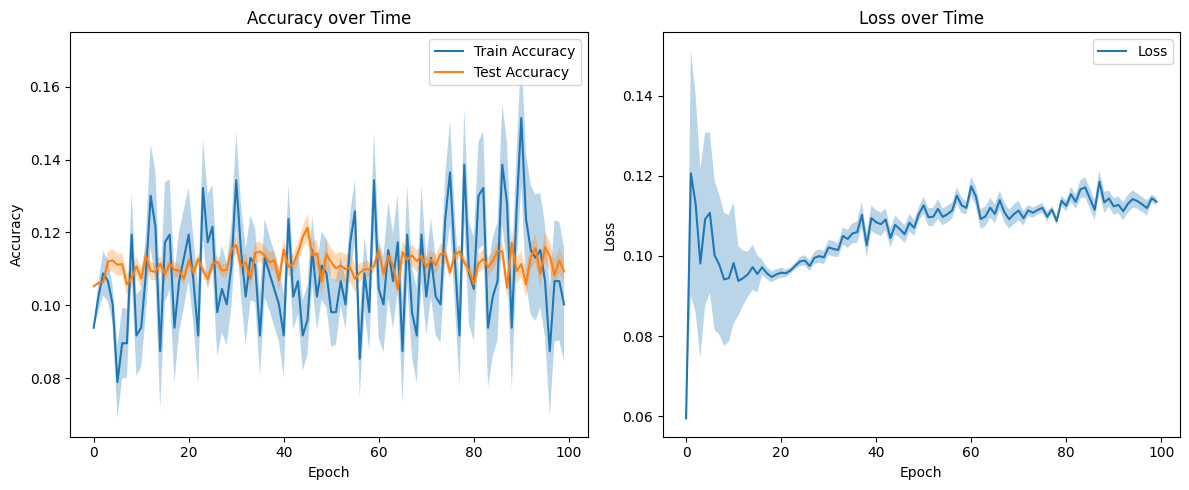

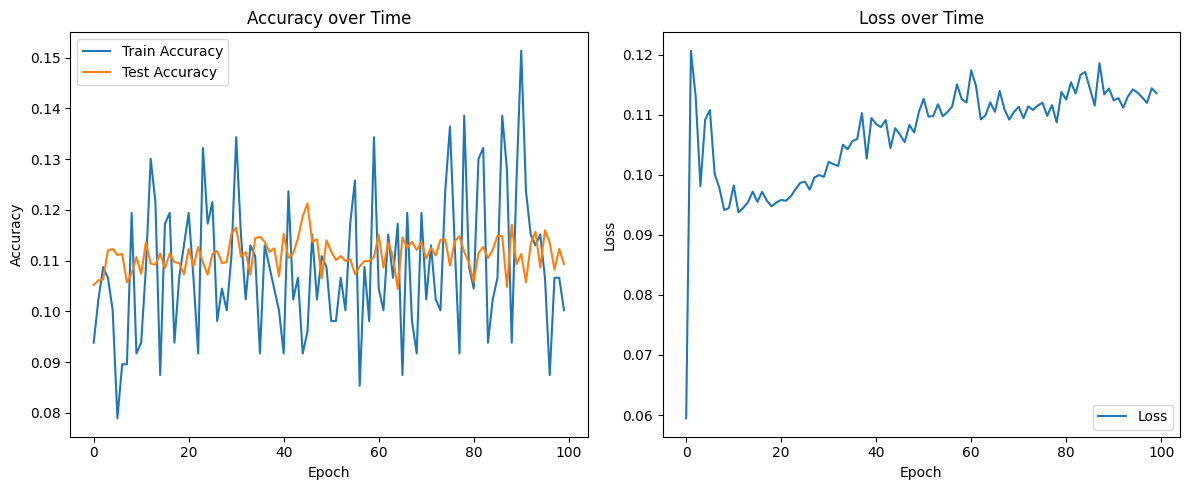

Final Train Accuracy: 0.10 ± 0.02
Final Test Accuracy: 0.11 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1723744649:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.05104286920255435
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723744649:   1%|          | 1/100 [00:04<07:53,  4.78s/it]

 Test accuracy:  0.1024

correct: 48 total: 469
loss: 0.06660995092282672
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723744649:   2%|▏         | 2/100 [00:09<08:04,  4.94s/it]

 Test accuracy:  0.1134

correct: 47 total: 469
loss: 0.07136988931341466
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1723744649:   3%|▎         | 3/100 [00:14<08:05,  5.00s/it]

 Test accuracy:  0.1148

correct: 52 total: 469
loss: 0.07549183056362148
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1723744649:   4%|▍         | 4/100 [00:20<08:08,  5.09s/it]

 Test accuracy:  0.121

correct: 57 total: 469
loss: 0.07773294557195737
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723744649:   5%|▌         | 5/100 [00:25<08:05,  5.11s/it]

 Test accuracy:  0.1358

correct: 65 total: 469
loss: 0.08031596335520877
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723744649:   6%|▌         | 6/100 [00:30<08:13,  5.25s/it]

 Test accuracy:  0.1262

correct: 66 total: 469
loss: 0.08324160263228264
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723744649:   7%|▋         | 7/100 [00:36<08:12,  5.30s/it]

 Test accuracy:  0.1277

correct: 69 total: 469
loss: 0.08471485017649909
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1723744649:   8%|▊         | 8/100 [00:41<08:07,  5.29s/it]

 Test accuracy:  0.1417

correct: 75 total: 469
loss: 0.08654622228415028
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723744649:   9%|▉         | 9/100 [00:46<08:01,  5.29s/it]

 Test accuracy:  0.1378

correct: 65 total: 469
loss: 0.08879749951904008
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723744649:  10%|█         | 10/100 [00:52<07:59,  5.33s/it]

 Test accuracy:  0.1367

correct: 61 total: 469
loss: 0.09021359159430462
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723744649:  11%|█         | 11/100 [00:57<07:53,  5.33s/it]

 Test accuracy:  0.1443

correct: 75 total: 469
loss: 0.0914686400054106
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723744649:  12%|█▏        | 12/100 [01:03<07:54,  5.39s/it]

 Test accuracy:  0.1371

correct: 66 total: 469
loss: 0.09274591864553342
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723744649:  13%|█▎        | 13/100 [01:08<07:46,  5.36s/it]

 Test accuracy:  0.1479

correct: 62 total: 469
loss: 0.09323148580311712
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1723744649:  14%|█▍        | 14/100 [01:13<07:41,  5.37s/it]

 Test accuracy:  0.1528

correct: 57 total: 469
loss: 0.09464225627338962
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723744649:  15%|█▌        | 15/100 [01:19<07:39,  5.41s/it]

 Test accuracy:  0.1429

correct: 56 total: 469
loss: 0.09434266026213226
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723744649:  16%|█▌        | 16/100 [01:24<07:37,  5.44s/it]

 Test accuracy:  0.1429

correct: 81 total: 469
loss: 0.09548976412142264
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1723744649:  17%|█▋        | 17/100 [01:30<07:32,  5.45s/it]

 Test accuracy:  0.1465

correct: 79 total: 469
loss: 0.09682324190320236
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1723744649:  18%|█▊        | 18/100 [01:35<07:31,  5.50s/it]

 Test accuracy:  0.144

correct: 78 total: 469
loss: 0.09768225114419261
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1723744649:  19%|█▉        | 19/100 [01:41<07:28,  5.54s/it]

 Test accuracy:  0.1504

correct: 72 total: 469
loss: 0.09926757014700091
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1723744649:  20%|██        | 20/100 [01:46<07:19,  5.50s/it]

 Test accuracy:  0.1546

correct: 59 total: 469
loss: 0.09905717142228125
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723744649:  21%|██        | 21/100 [01:52<07:10,  5.45s/it]

 Test accuracy:  0.1487

correct: 65 total: 469
loss: 0.09889378060282929
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723744649:  22%|██▏       | 22/100 [01:57<07:04,  5.44s/it]

 Test accuracy:  0.1516

correct: 67 total: 469
loss: 0.09969325960953353
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1723744649:  23%|██▎       | 23/100 [02:03<07:00,  5.46s/it]

 Test accuracy:  0.1482

correct: 77 total: 469
loss: 0.09972401435123578
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1723744649:  24%|██▍       | 24/100 [02:08<06:51,  5.42s/it]

 Test accuracy:  0.1523

correct: 63 total: 469
loss: 0.1003558779798591
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723744649:  25%|██▌       | 25/100 [02:13<06:44,  5.39s/it]

 Test accuracy:  0.1471

correct: 80 total: 469
loss: 0.10142904574047527
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723744649:  26%|██▌       | 26/100 [02:19<06:38,  5.39s/it]

 Test accuracy:  0.1523

correct: 81 total: 469
loss: 0.1008463814886394
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1723744649:  27%|██▋       | 27/100 [02:24<06:36,  5.43s/it]

 Test accuracy:  0.1498

correct: 78 total: 469
loss: 0.10183282234648397
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1723744649:  28%|██▊       | 28/100 [02:30<06:32,  5.46s/it]

 Test accuracy:  0.1511

correct: 66 total: 469
loss: 0.10253051905108414
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723744649:  29%|██▉       | 29/100 [02:35<06:32,  5.53s/it]

 Test accuracy:  0.1448

correct: 75 total: 469
loss: 0.1026657813870068
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1723744649:  30%|███       | 30/100 [02:41<06:26,  5.52s/it]

 Test accuracy:  0.1457

correct: 82 total: 469
loss: 0.10289132366302425
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1723744649:  31%|███       | 31/100 [02:46<06:19,  5.51s/it]

 Test accuracy:  0.152

correct: 64 total: 469
loss: 0.10334280638425335
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723744649:  32%|███▏      | 32/100 [02:52<06:12,  5.48s/it]

 Test accuracy:  0.1477

correct: 73 total: 469
loss: 0.10412707848589557
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1723744649:  33%|███▎      | 33/100 [02:57<06:06,  5.48s/it]

 Test accuracy:  0.1503

correct: 68 total: 469
loss: 0.10357289929697508
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1723744649:  34%|███▍      | 34/100 [03:03<05:59,  5.45s/it]

 Test accuracy:  0.1519

correct: 66 total: 469
loss: 0.10431213143156536
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723744649:  35%|███▌      | 35/100 [03:08<05:55,  5.48s/it]

 Test accuracy:  0.1504

correct: 68 total: 469
loss: 0.10381750811709524
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1723744649:  36%|███▌      | 36/100 [03:14<05:48,  5.44s/it]

 Test accuracy:  0.1574

correct: 63 total: 469
loss: 0.10496467270894345
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723744649:  37%|███▋      | 37/100 [03:19<05:42,  5.44s/it]

 Test accuracy:  0.1443

correct: 74 total: 469
loss: 0.10519525645447693
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723744649:  38%|███▊      | 38/100 [03:24<05:34,  5.40s/it]

 Test accuracy:  0.1496

correct: 70 total: 469
loss: 0.10428517864647704
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1723744649:  39%|███▉      | 39/100 [03:30<05:29,  5.40s/it]

 Test accuracy:  0.1528

correct: 62 total: 469
loss: 0.10516078245919397
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1723744649:  40%|████      | 40/100 [03:35<05:26,  5.44s/it]

 Test accuracy:  0.149

correct: 66 total: 469
loss: 0.10504223857480072
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723744649:  41%|████      | 41/100 [03:41<05:23,  5.48s/it]

 Test accuracy:  0.1499

correct: 78 total: 469
loss: 0.10473742852333004
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1723744649:  42%|████▏     | 42/100 [03:46<05:16,  5.45s/it]

 Test accuracy:  0.1537

correct: 80 total: 469
loss: 0.10540647946123376
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723744649:  43%|████▎     | 43/100 [03:52<05:09,  5.43s/it]

 Test accuracy:  0.1471

correct: 77 total: 469
loss: 0.10580379708108109
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1723744649:  44%|████▍     | 44/100 [03:57<05:03,  5.42s/it]

 Test accuracy:  0.1493

correct: 57 total: 469
loss: 0.10534577904098323
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723744649:  45%|████▌     | 45/100 [04:02<04:57,  5.40s/it]

 Test accuracy:  0.1489

correct: 61 total: 469
loss: 0.10589801858483093
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723744649:  46%|████▌     | 46/100 [04:08<04:51,  5.39s/it]

 Test accuracy:  0.1493

correct: 59 total: 469
loss: 0.1057944357045678
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723744649:  47%|████▋     | 47/100 [04:13<04:49,  5.46s/it]

 Test accuracy:  0.1501

correct: 62 total: 469
loss: 0.10527557439641404
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1723744649:  48%|████▊     | 48/100 [04:19<04:43,  5.45s/it]

 Test accuracy:  0.1507

correct: 86 total: 469
loss: 0.10593142319144978
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1723744649:  49%|████▉     | 49/100 [04:24<04:36,  5.42s/it]

 Test accuracy:  0.1491

correct: 59 total: 469
loss: 0.1065270587134717
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723744649:  50%|█████     | 50/100 [04:30<04:37,  5.56s/it]

 Test accuracy:  0.1531

correct: 60 total: 469
loss: 0.10653202102255466
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723744649:  51%|█████     | 51/100 [04:35<04:31,  5.53s/it]

 Test accuracy:  0.1442

correct: 74 total: 469
loss: 0.10539132583814897
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723744649:  52%|█████▏    | 52/100 [04:41<04:26,  5.56s/it]

 Test accuracy:  0.1563

correct: 67 total: 469
loss: 0.1061613469648717
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1723744649:  53%|█████▎    | 53/100 [04:47<04:21,  5.57s/it]

 Test accuracy:  0.1505

correct: 68 total: 469
loss: 0.1068999418127003
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1723744649:  54%|█████▍    | 54/100 [04:52<04:16,  5.58s/it]

 Test accuracy:  0.1484

correct: 71 total: 469
loss: 0.10641509766327038
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1723744649:  55%|█████▌    | 55/100 [04:58<04:10,  5.57s/it]

 Test accuracy:  0.151

correct: 76 total: 469
loss: 0.10571385989946597
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1723744649:  56%|█████▌    | 56/100 [05:03<04:03,  5.54s/it]

 Test accuracy:  0.148

correct: 64 total: 469
loss: 0.1061760677394074
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723744649:  57%|█████▋    | 57/100 [05:09<03:58,  5.55s/it]

 Test accuracy:  0.1455

correct: 65 total: 469
loss: 0.10714879662179744
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1723744649:  58%|█████▊    | 58/100 [05:15<03:55,  5.60s/it]

 Test accuracy:  0.1505

correct: 67 total: 469
loss: 0.10675346479614152
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1723744649:  59%|█████▉    | 59/100 [05:20<03:48,  5.57s/it]

 Test accuracy:  0.1441

correct: 60 total: 469
loss: 0.1064571639749287
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723744649:  60%|██████    | 60/100 [05:25<03:41,  5.53s/it]

 Test accuracy:  0.152

correct: 62 total: 469
loss: 0.10693736966929711
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1723744649:  61%|██████    | 61/100 [05:31<03:35,  5.53s/it]

 Test accuracy:  0.1522

correct: 70 total: 469
loss: 0.10568042425140897
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1723744649:  62%|██████▏   | 62/100 [05:36<03:29,  5.50s/it]

 Test accuracy:  0.1542

correct: 70 total: 469
loss: 0.1065860489474685
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1723744649:  63%|██████▎   | 63/100 [05:42<03:23,  5.49s/it]

 Test accuracy:  0.1484

correct: 92 total: 469
loss: 0.10758877964988192
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1723744649:  64%|██████▍   | 64/100 [05:48<03:19,  5.55s/it]

 Test accuracy:  0.1419

correct: 60 total: 469
loss: 0.10735240793113769
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1723744649:  65%|██████▌   | 65/100 [05:53<03:13,  5.53s/it]

 Test accuracy:  0.15

correct: 72 total: 469
loss: 0.10692721635484492
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1723744649:  66%|██████▌   | 66/100 [05:59<03:07,  5.53s/it]

 Test accuracy:  0.1539

correct: 99 total: 469
loss: 0.1072768490991867
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1723744649:  67%|██████▋   | 67/100 [06:04<03:02,  5.53s/it]

 Test accuracy:  0.1472

correct: 69 total: 469
loss: 0.10752482419964601
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1723744649:  68%|██████▊   | 68/100 [06:10<02:56,  5.52s/it]

 Test accuracy:  0.1462

correct: 58 total: 469
loss: 0.10733708945799993
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1723744649:  69%|██████▉   | 69/100 [06:15<02:51,  5.52s/it]

 Test accuracy:  0.1505

correct: 66 total: 469
loss: 0.10689529347648499
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723744649:  70%|███████   | 70/100 [06:21<02:45,  5.51s/it]

 Test accuracy:  0.151

correct: 69 total: 469
loss: 0.10777718708840514
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1723744649:  71%|███████   | 71/100 [06:26<02:39,  5.51s/it]

 Test accuracy:  0.1488

correct: 74 total: 469
loss: 0.10820649542025666
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723744649:  72%|███████▏  | 72/100 [06:32<02:34,  5.53s/it]

 Test accuracy:  0.146

correct: 71 total: 469
loss: 0.10770183367960488
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1723744649:  73%|███████▎  | 73/100 [06:37<02:30,  5.58s/it]

 Test accuracy:  0.1435

correct: 61 total: 469
loss: 0.10734878828339993
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723744649:  74%|███████▍  | 74/100 [06:43<02:25,  5.61s/it]

 Test accuracy:  0.1538

correct: 79 total: 469
loss: 0.10799662385985795
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1723744649:  75%|███████▌  | 75/100 [06:49<02:21,  5.66s/it]

 Test accuracy:  0.1502

correct: 73 total: 469
loss: 0.10800967095439622
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1723744649:  76%|███████▌  | 76/100 [06:54<02:15,  5.64s/it]

 Test accuracy:  0.1537

correct: 80 total: 469
loss: 0.10803093559452212
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723744649:  77%|███████▋  | 77/100 [07:00<02:09,  5.65s/it]

 Test accuracy:  0.1526

correct: 79 total: 469
loss: 0.10869465002627261
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1723744649:  78%|███████▊  | 78/100 [07:06<02:03,  5.63s/it]

 Test accuracy:  0.1562

correct: 62 total: 469
loss: 0.10827840321353757
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1723744649:  79%|███████▉  | 79/100 [07:11<01:58,  5.65s/it]

 Test accuracy:  0.1579

correct: 66 total: 469
loss: 0.1074648956055326
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1723744649:  80%|████████  | 80/100 [07:17<01:52,  5.64s/it]

 Test accuracy:  0.1519

correct: 86 total: 469
loss: 0.10825835154064174
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1723744649:  81%|████████  | 81/100 [07:23<01:48,  5.69s/it]

 Test accuracy:  0.1503

correct: 72 total: 469
loss: 0.10761597290285614
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1723744649:  82%|████████▏ | 82/100 [07:29<01:43,  5.73s/it]

 Test accuracy:  0.1526

correct: 69 total: 469
loss: 0.1081204998817271
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1723744649:  83%|████████▎ | 83/100 [07:34<01:37,  5.73s/it]

 Test accuracy:  0.1525

correct: 73 total: 469
loss: 0.10791349517447608
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1723744649:  84%|████████▍ | 84/100 [07:40<01:31,  5.72s/it]

 Test accuracy:  0.1519

correct: 76 total: 469
loss: 0.10880151408504067
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1723744649:  85%|████████▌ | 85/100 [07:46<01:26,  5.75s/it]

 Test accuracy:  0.1543

correct: 70 total: 469
loss: 0.10908139187262765
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1723744649:  86%|████████▌ | 86/100 [07:52<01:20,  5.75s/it]

 Test accuracy:  0.1567

correct: 72 total: 469
loss: 0.10698408568337528
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1723744649:  87%|████████▋ | 87/100 [07:57<01:14,  5.72s/it]

 Test accuracy:  0.1454

correct: 74 total: 469
loss: 0.10886372762448243
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1723744649:  88%|████████▊ | 88/100 [08:03<01:09,  5.78s/it]

 Test accuracy:  0.1509

correct: 56 total: 469
loss: 0.10894251797499178
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1723744649:  89%|████████▉ | 89/100 [08:09<01:03,  5.76s/it]

 Test accuracy:  0.1436

correct: 63 total: 469
loss: 0.10829526101793054
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1723744649:  90%|█████████ | 90/100 [08:15<00:58,  5.81s/it]

 Test accuracy:  0.1531

correct: 86 total: 469
loss: 0.10831929625732813
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1723744649:  91%|█████████ | 91/100 [08:21<00:52,  5.84s/it]

 Test accuracy:  0.1518

correct: 57 total: 469
loss: 0.10803455849891024
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1723744649:  92%|█████████▏| 92/100 [08:27<00:46,  5.85s/it]

 Test accuracy:  0.1499

correct: 81 total: 469
loss: 0.10839625044481586
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1723744649:  93%|█████████▎| 93/100 [08:33<00:41,  5.86s/it]

 Test accuracy:  0.1527

correct: 71 total: 469
loss: 0.1084459914263886
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1723744649:  94%|█████████▍| 94/100 [08:38<00:35,  5.87s/it]

 Test accuracy:  0.1514

correct: 80 total: 469
loss: 0.10869948710523435
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1723744649:  95%|█████████▌| 95/100 [08:44<00:29,  5.89s/it]

 Test accuracy:  0.1528

correct: 71 total: 469
loss: 0.10766048098741564
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1723744649:  96%|█████████▌| 96/100 [08:50<00:23,  5.87s/it]

 Test accuracy:  0.1534

correct: 64 total: 469
loss: 0.10939564279465279
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1723744649:  97%|█████████▋| 97/100 [08:57<00:18,  6.08s/it]

 Test accuracy:  0.1506

correct: 59 total: 469
loss: 0.10890621841271549
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1723744649:  98%|█████████▊| 98/100 [09:03<00:11,  5.97s/it]

 Test accuracy:  0.1509

correct: 61 total: 469
loss: 0.10740513810470922
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1723744649:  99%|█████████▉| 99/100 [09:08<00:05,  5.90s/it]

 Test accuracy:  0.1482

correct: 78 total: 469
loss: 0.10856937491563337
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1723744649: 100%|██████████| 100/100 [09:14<00:00,  5.55s/it]

 Test accuracy:  0.1445


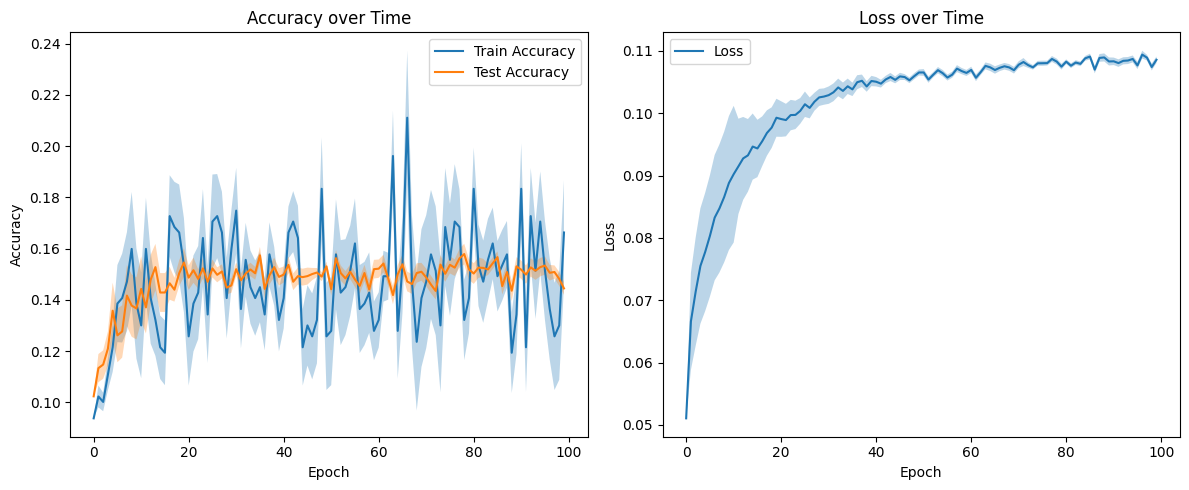

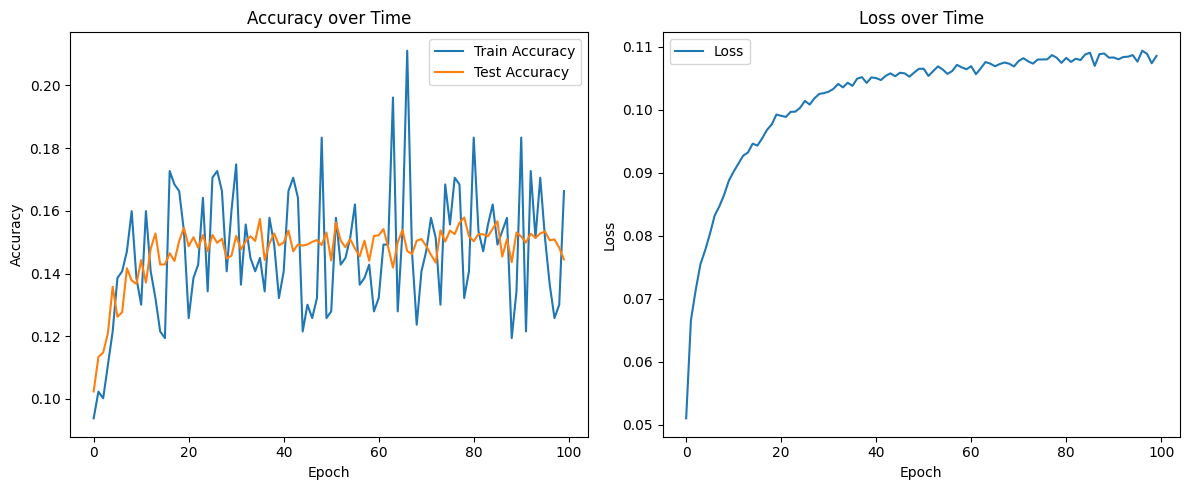

Final Train Accuracy: 0.17 ± 0.02
Final Test Accuracy: 0.14 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1723745208:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.05969788554285381
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723745208:   1%|          | 1/100 [00:04<07:58,  4.84s/it]

 Test accuracy:  0.2619

correct: 48 total: 469
loss: 0.07689914580728453
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723745208:   2%|▏         | 2/100 [00:10<08:18,  5.09s/it]

 Test accuracy:  0.3543

correct: 186 total: 469
loss: 0.0872979339347211
 Train accuracy:  0.39658848614072495 | 


MLP_MNIST_0_1723745208:   3%|▎         | 3/100 [00:15<08:15,  5.11s/it]

 Test accuracy:  0.4532

correct: 194 total: 469
loss: 0.09598941544988263
 Train accuracy:  0.4136460554371002 | 


MLP_MNIST_0_1723745208:   4%|▍         | 4/100 [00:20<08:12,  5.13s/it]

 Test accuracy:  0.4902

correct: 229 total: 469
loss: 0.10174544849820229
 Train accuracy:  0.488272921108742 | 


MLP_MNIST_0_1723745208:   5%|▌         | 5/100 [00:25<08:08,  5.14s/it]

 Test accuracy:  0.5056

correct: 237 total: 469
loss: 0.10607278491578885
 Train accuracy:  0.5053304904051172 | 


MLP_MNIST_0_1723745208:   6%|▌         | 6/100 [00:31<08:14,  5.26s/it]

 Test accuracy:  0.5119

correct: 234 total: 469
loss: 0.10976209720251148
 Train accuracy:  0.4989339019189765 | 


MLP_MNIST_0_1723745208:   7%|▋         | 7/100 [00:36<08:15,  5.33s/it]

 Test accuracy:  0.5276

correct: 246 total: 469
loss: 0.11257024056939428
 Train accuracy:  0.5245202558635395 | 


MLP_MNIST_0_1723745208:   8%|▊         | 8/100 [00:42<08:23,  5.48s/it]

 Test accuracy:  0.5433

correct: 251 total: 469
loss: 0.11488232469317247
 Train accuracy:  0.535181236673774 | 


MLP_MNIST_0_1723745208:   9%|▉         | 9/100 [00:47<08:20,  5.50s/it]

 Test accuracy:  0.556

correct: 245 total: 469
loss: 0.11780275418750767
 Train accuracy:  0.5223880597014925 | 


MLP_MNIST_0_1723745208:  10%|█         | 10/100 [00:53<08:17,  5.53s/it]

 Test accuracy:  0.5595

correct: 250 total: 469
loss: 0.11945715923108526
 Train accuracy:  0.5330490405117271 | 


MLP_MNIST_0_1723745208:  11%|█         | 11/100 [00:59<08:12,  5.53s/it]

 Test accuracy:  0.5633

correct: 257 total: 469
loss: 0.12106241770326964
 Train accuracy:  0.5479744136460555 | 


MLP_MNIST_0_1723745208:  12%|█▏        | 12/100 [01:04<08:16,  5.64s/it]

 Test accuracy:  0.5671

correct: 269 total: 469
loss: 0.12308201376499651
 Train accuracy:  0.5735607675906184 | 


MLP_MNIST_0_1723745208:  13%|█▎        | 13/100 [01:10<08:18,  5.73s/it]

 Test accuracy:  0.5644

correct: 268 total: 469
loss: 0.12430021954751981
 Train accuracy:  0.5714285714285714 | 


MLP_MNIST_0_1723745208:  14%|█▍        | 14/100 [01:16<08:12,  5.73s/it]

 Test accuracy:  0.5701

correct: 243 total: 469
loss: 0.12530933188667684
 Train accuracy:  0.5181236673773987 | 


MLP_MNIST_0_1723745208:  15%|█▌        | 15/100 [01:22<08:11,  5.79s/it]

 Test accuracy:  0.5717

correct: 270 total: 469
loss: 0.12597967384021674
 Train accuracy:  0.5756929637526652 | 


MLP_MNIST_0_1723745208:  16%|█▌        | 16/100 [01:28<08:09,  5.83s/it]

 Test accuracy:  0.5736

correct: 295 total: 469
loss: 0.1269676416540451
 Train accuracy:  0.6289978678038379 | 


MLP_MNIST_0_1723745208:  17%|█▋        | 17/100 [01:34<08:03,  5.83s/it]

 Test accuracy:  0.5735

correct: 265 total: 469
loss: 0.1281027825815337
 Train accuracy:  0.5650319829424307 | 


MLP_MNIST_0_1723745208:  18%|█▊        | 18/100 [01:40<07:57,  5.82s/it]

 Test accuracy:  0.5772

correct: 260 total: 469
loss: 0.12853769692721398
 Train accuracy:  0.5543710021321961 | 


MLP_MNIST_0_1723745208:  19%|█▉        | 19/100 [01:45<07:54,  5.86s/it]

 Test accuracy:  0.5834

correct: 279 total: 469
loss: 0.1289448158732101
 Train accuracy:  0.5948827292110874 | 


MLP_MNIST_0_1723745208:  20%|██        | 20/100 [01:51<07:47,  5.85s/it]

 Test accuracy:  0.578

correct: 265 total: 469
loss: 0.1294679361175118
 Train accuracy:  0.5650319829424307 | 


MLP_MNIST_0_1723745208:  21%|██        | 21/100 [01:57<07:42,  5.85s/it]

 Test accuracy:  0.58

correct: 261 total: 469
loss: 0.13003020714531574
 Train accuracy:  0.5565031982942431 | 


MLP_MNIST_0_1723745208:  22%|██▏       | 22/100 [02:03<07:37,  5.86s/it]

 Test accuracy:  0.5803

correct: 263 total: 469
loss: 0.1307309797164728
 Train accuracy:  0.5607675906183369 | 


MLP_MNIST_0_1723745208:  23%|██▎       | 23/100 [02:09<07:34,  5.90s/it]

 Test accuracy:  0.5794

correct: 270 total: 469
loss: 0.1306251756894563
 Train accuracy:  0.5756929637526652 | 


MLP_MNIST_0_1723745208:  24%|██▍       | 24/100 [02:15<07:31,  5.94s/it]

 Test accuracy:  0.5811

correct: 273 total: 469
loss: 0.13087240994167226
 Train accuracy:  0.582089552238806 | 


MLP_MNIST_0_1723745208:  25%|██▌       | 25/100 [02:21<07:27,  5.97s/it]

 Test accuracy:  0.5819

correct: 276 total: 469
loss: 0.13144819930926568
 Train accuracy:  0.5884861407249466 | 


MLP_MNIST_0_1723745208:  26%|██▌       | 26/100 [02:27<07:21,  5.96s/it]

 Test accuracy:  0.5839

correct: 261 total: 469
loss: 0.1325811798225588
 Train accuracy:  0.5565031982942431 | 


MLP_MNIST_0_1723745208:  27%|██▋       | 27/100 [02:33<07:13,  5.94s/it]

 Test accuracy:  0.5847

correct: 278 total: 469
loss: 0.13243535534341708
 Train accuracy:  0.5927505330490405 | 


MLP_MNIST_0_1723745208:  28%|██▊       | 28/100 [02:39<07:08,  5.95s/it]

 Test accuracy:  0.5889

correct: 275 total: 469
loss: 0.13250290850268753
 Train accuracy:  0.5863539445628998 | 


MLP_MNIST_0_1723745208:  29%|██▉       | 29/100 [02:45<07:04,  5.98s/it]

 Test accuracy:  0.5833

correct: 277 total: 469
loss: 0.13363360953547043
 Train accuracy:  0.5906183368869936 | 


MLP_MNIST_0_1723745208:  30%|███       | 30/100 [02:51<06:58,  5.97s/it]

 Test accuracy:  0.5854

correct: 279 total: 469
loss: 0.13329946508666854
 Train accuracy:  0.5948827292110874 | 


MLP_MNIST_0_1723745208:  31%|███       | 31/100 [02:57<06:53,  5.99s/it]

 Test accuracy:  0.5838

correct: 268 total: 469
loss: 0.13378643849765315
 Train accuracy:  0.5714285714285714 | 


MLP_MNIST_0_1723745208:  32%|███▏      | 32/100 [03:03<06:46,  5.98s/it]

 Test accuracy:  0.5879

correct: 272 total: 469
loss: 0.13441671863166507
 Train accuracy:  0.579957356076759 | 


MLP_MNIST_0_1723745208:  33%|███▎      | 33/100 [03:09<06:39,  5.96s/it]

 Test accuracy:  0.582

correct: 275 total: 469
loss: 0.1342430703167214
 Train accuracy:  0.5863539445628998 | 


MLP_MNIST_0_1723745208:  34%|███▍      | 34/100 [03:15<06:36,  6.01s/it]

 Test accuracy:  0.5837

correct: 275 total: 469
loss: 0.1346926371743684
 Train accuracy:  0.5863539445628998 | 


MLP_MNIST_0_1723745208:  35%|███▌      | 35/100 [03:21<06:32,  6.04s/it]

 Test accuracy:  0.5826

correct: 287 total: 469
loss: 0.13464372798895785
 Train accuracy:  0.6119402985074627 | 


MLP_MNIST_0_1723745208:  36%|███▌      | 36/100 [03:27<06:25,  6.02s/it]

 Test accuracy:  0.5863

correct: 251 total: 469
loss: 0.1359505500398211
 Train accuracy:  0.535181236673774 | 


MLP_MNIST_0_1723745208:  37%|███▋      | 37/100 [03:33<06:20,  6.03s/it]

 Test accuracy:  0.5825

correct: 295 total: 469
loss: 0.13585195561716043
 Train accuracy:  0.6289978678038379 | 


MLP_MNIST_0_1723745208:  38%|███▊      | 38/100 [03:39<06:12,  6.01s/it]

 Test accuracy:  0.587

correct: 274 total: 469
loss: 0.13582592122336187
 Train accuracy:  0.5842217484008528 | 


MLP_MNIST_0_1723745208:  39%|███▉      | 39/100 [03:45<06:06,  6.00s/it]

 Test accuracy:  0.5814

correct: 263 total: 469
loss: 0.13610658583356372
 Train accuracy:  0.5607675906183369 | 


MLP_MNIST_0_1723745208:  40%|████      | 40/100 [03:51<06:04,  6.08s/it]

 Test accuracy:  0.5811

correct: 272 total: 469
loss: 0.13571816614505325
 Train accuracy:  0.579957356076759 | 


MLP_MNIST_0_1723745208:  41%|████      | 41/100 [03:57<05:55,  6.03s/it]

 Test accuracy:  0.5832

correct: 274 total: 469
loss: 0.13556230392283214
 Train accuracy:  0.5842217484008528 | 


MLP_MNIST_0_1723745208:  42%|████▏     | 42/100 [04:03<05:49,  6.03s/it]

 Test accuracy:  0.5862

correct: 283 total: 469
loss: 0.13577863539078597
 Train accuracy:  0.603411513859275 | 


MLP_MNIST_0_1723745208:  43%|████▎     | 43/100 [04:09<05:44,  6.05s/it]

 Test accuracy:  0.5802

correct: 271 total: 469
loss: 0.13573106916855648
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1723745208:  44%|████▍     | 44/100 [04:15<05:38,  6.05s/it]

 Test accuracy:  0.5874

correct: 287 total: 469
loss: 0.13669865765868983
 Train accuracy:  0.6119402985074627 | 


MLP_MNIST_0_1723745208:  45%|████▌     | 45/100 [04:22<05:34,  6.09s/it]

 Test accuracy:  0.5859

correct: 254 total: 469
loss: 0.1358401493064122
 Train accuracy:  0.5415778251599147 | 


MLP_MNIST_0_1723745208:  46%|████▌     | 46/100 [04:28<05:26,  6.05s/it]

 Test accuracy:  0.5857

correct: 280 total: 469
loss: 0.1367172698921232
 Train accuracy:  0.5970149253731343 | 


MLP_MNIST_0_1723745208:  47%|████▋     | 47/100 [04:34<05:19,  6.03s/it]

 Test accuracy:  0.5855

correct: 270 total: 469
loss: 0.1366766854199265
 Train accuracy:  0.5756929637526652 | 


MLP_MNIST_0_1723745208:  48%|████▊     | 48/100 [04:40<05:13,  6.02s/it]

 Test accuracy:  0.5765

correct: 268 total: 469
loss: 0.13681447861799553
 Train accuracy:  0.5714285714285714 | 


MLP_MNIST_0_1723745208:  49%|████▉     | 49/100 [04:46<05:07,  6.04s/it]

 Test accuracy:  0.5862

correct: 261 total: 469
loss: 0.1369461763197425
 Train accuracy:  0.5565031982942431 | 


MLP_MNIST_0_1723745208:  50%|█████     | 50/100 [04:52<05:07,  6.14s/it]

 Test accuracy:  0.5845

correct: 269 total: 469
loss: 0.13673949940626556
 Train accuracy:  0.5735607675906184 | 


MLP_MNIST_0_1723745208:  51%|█████     | 51/100 [04:58<05:00,  6.12s/it]

 Test accuracy:  0.5849

correct: 264 total: 469
loss: 0.13727489860454348
 Train accuracy:  0.5628997867803838 | 


MLP_MNIST_0_1723745208:  52%|█████▏    | 52/100 [05:05<04:59,  6.25s/it]

 Test accuracy:  0.5819

correct: 274 total: 469
loss: 0.1373609490613185
 Train accuracy:  0.5842217484008528 | 


MLP_MNIST_0_1723745208:  53%|█████▎    | 53/100 [05:11<04:51,  6.21s/it]

 Test accuracy:  0.581

correct: 286 total: 469
loss: 0.13753150811772358
 Train accuracy:  0.6098081023454158 | 


MLP_MNIST_0_1723745208:  54%|█████▍    | 54/100 [05:17<04:43,  6.16s/it]

 Test accuracy:  0.5841

correct: 258 total: 469
loss: 0.1376775589737811
 Train accuracy:  0.5501066098081023 | 


MLP_MNIST_0_1723745208:  55%|█████▌    | 55/100 [05:23<04:39,  6.21s/it]

 Test accuracy:  0.5852

correct: 278 total: 469
loss: 0.1371083103581024
 Train accuracy:  0.5927505330490405 | 


MLP_MNIST_0_1723745208:  56%|█████▌    | 56/100 [05:29<04:31,  6.17s/it]

 Test accuracy:  0.5819

correct: 270 total: 469
loss: 0.13710884708585516
 Train accuracy:  0.5756929637526652 | 


MLP_MNIST_0_1723745208:  57%|█████▋    | 57/100 [05:35<04:23,  6.13s/it]

 Test accuracy:  0.5845

correct: 261 total: 469
loss: 0.13805704756077927
 Train accuracy:  0.5565031982942431 | 


MLP_MNIST_0_1723745208:  58%|█████▊    | 58/100 [05:41<04:18,  6.14s/it]

 Test accuracy:  0.5763

correct: 271 total: 469
loss: 0.1376989729114687
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1723745208:  59%|█████▉    | 59/100 [05:47<04:11,  6.13s/it]

 Test accuracy:  0.5849

correct: 278 total: 469
loss: 0.13845170247974173
 Train accuracy:  0.5927505330490405 | 


MLP_MNIST_0_1723745208:  60%|██████    | 60/100 [05:54<04:07,  6.18s/it]

 Test accuracy:  0.5811

correct: 260 total: 469
loss: 0.1380120052902429
 Train accuracy:  0.5543710021321961 | 


MLP_MNIST_0_1723745208:  61%|██████    | 61/100 [06:00<04:00,  6.18s/it]

 Test accuracy:  0.5875

correct: 268 total: 469
loss: 0.13763755032502767
 Train accuracy:  0.5714285714285714 | 


MLP_MNIST_0_1723745208:  62%|██████▏   | 62/100 [06:06<03:55,  6.19s/it]

 Test accuracy:  0.5835

correct: 265 total: 469
loss: 0.138436756885128
 Train accuracy:  0.5650319829424307 | 


MLP_MNIST_0_1723745208:  63%|██████▎   | 63/100 [06:12<03:49,  6.20s/it]

 Test accuracy:  0.5845

correct: 282 total: 469
loss: 0.13844536916851236
 Train accuracy:  0.6012793176972282 | 


MLP_MNIST_0_1723745208:  64%|██████▍   | 64/100 [06:19<03:44,  6.24s/it]

 Test accuracy:  0.5835

correct: 249 total: 469
loss: 0.13957255494111637
 Train accuracy:  0.5309168443496801 | 


MLP_MNIST_0_1723745208:  65%|██████▌   | 65/100 [06:25<03:40,  6.31s/it]

 Test accuracy:  0.5816

correct: 283 total: 469
loss: 0.13840199595511848
 Train accuracy:  0.603411513859275 | 


MLP_MNIST_0_1723745208:  66%|██████▌   | 66/100 [06:32<03:34,  6.31s/it]

 Test accuracy:  0.5824

correct: 291 total: 469
loss: 0.13829319396697637
 Train accuracy:  0.6204690831556503 | 


MLP_MNIST_0_1723745208:  67%|██████▋   | 67/100 [06:38<03:27,  6.29s/it]

 Test accuracy:  0.5827

correct: 251 total: 469
loss: 0.1382931487392515
 Train accuracy:  0.535181236673774 | 


MLP_MNIST_0_1723745208:  68%|██████▊   | 68/100 [06:44<03:20,  6.26s/it]

 Test accuracy:  0.585

correct: 278 total: 469
loss: 0.1382544989874368
 Train accuracy:  0.5927505330490405 | 


MLP_MNIST_0_1723745208:  69%|██████▉   | 69/100 [06:50<03:12,  6.22s/it]

 Test accuracy:  0.5819

correct: 295 total: 469
loss: 0.1384187343913609
 Train accuracy:  0.6289978678038379 | 


MLP_MNIST_0_1723745208:  70%|███████   | 70/100 [06:56<03:07,  6.24s/it]

 Test accuracy:  0.5808

correct: 285 total: 469
loss: 0.13883735036163697
 Train accuracy:  0.6076759061833689 | 


MLP_MNIST_0_1723745208:  71%|███████   | 71/100 [07:03<03:01,  6.27s/it]

 Test accuracy:  0.5816

correct: 269 total: 469
loss: 0.13864618098176618
 Train accuracy:  0.5735607675906184 | 


MLP_MNIST_0_1723745208:  72%|███████▏  | 72/100 [07:09<02:54,  6.23s/it]

 Test accuracy:  0.5819

correct: 270 total: 469
loss: 0.13865123690763262
 Train accuracy:  0.5756929637526652 | 


MLP_MNIST_0_1723745208:  73%|███████▎  | 73/100 [07:15<02:49,  6.26s/it]

 Test accuracy:  0.5898

correct: 266 total: 469
loss: 0.13855389413485394
 Train accuracy:  0.5671641791044776 | 


MLP_MNIST_0_1723745208:  74%|███████▍  | 74/100 [07:21<02:43,  6.28s/it]

 Test accuracy:  0.59

correct: 281 total: 469
loss: 0.13877564195249634
 Train accuracy:  0.5991471215351812 | 


MLP_MNIST_0_1723745208:  75%|███████▌  | 75/100 [07:28<02:37,  6.29s/it]

 Test accuracy:  0.5829

correct: 286 total: 469
loss: 0.13928523086217928
 Train accuracy:  0.6098081023454158 | 


MLP_MNIST_0_1723745208:  76%|███████▌  | 76/100 [07:34<02:31,  6.32s/it]

 Test accuracy:  0.5808

correct: 272 total: 469
loss: 0.13931511706317157
 Train accuracy:  0.579957356076759 | 


MLP_MNIST_0_1723745208:  77%|███████▋  | 77/100 [07:41<02:26,  6.36s/it]

 Test accuracy:  0.5848

correct: 271 total: 469
loss: 0.1387479357056018
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1723745208:  78%|███████▊  | 78/100 [07:47<02:18,  6.31s/it]

 Test accuracy:  0.5818

correct: 271 total: 469
loss: 0.13927053893680003
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1723745208:  79%|███████▉  | 79/100 [07:53<02:11,  6.28s/it]

 Test accuracy:  0.5839

correct: 272 total: 469
loss: 0.13861489929814838
 Train accuracy:  0.579957356076759 | 


MLP_MNIST_0_1723745208:  80%|████████  | 80/100 [08:00<02:07,  6.36s/it]

 Test accuracy:  0.587

correct: 280 total: 469
loss: 0.1391131335388877
 Train accuracy:  0.5970149253731343 | 


MLP_MNIST_0_1723745208:  81%|████████  | 81/100 [08:06<02:01,  6.38s/it]

 Test accuracy:  0.5849

correct: 271 total: 469
loss: 0.13944041131656054
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1723745208:  82%|████████▏ | 82/100 [08:12<01:54,  6.38s/it]

 Test accuracy:  0.5855

correct: 292 total: 469
loss: 0.1391419253147233
 Train accuracy:  0.6226012793176973 | 


MLP_MNIST_0_1723745208:  83%|████████▎ | 83/100 [08:19<01:48,  6.38s/it]

 Test accuracy:  0.5775

correct: 267 total: 469
loss: 0.13887110889466334
 Train accuracy:  0.5692963752665245 | 


MLP_MNIST_0_1723745208:  84%|████████▍ | 84/100 [08:25<01:41,  6.35s/it]

 Test accuracy:  0.5859

correct: 283 total: 469
loss: 0.13949831552914718
 Train accuracy:  0.603411513859275 | 


MLP_MNIST_0_1723745208:  85%|████████▌ | 85/100 [08:31<01:35,  6.37s/it]

 Test accuracy:  0.5834

correct: 269 total: 469
loss: 0.13963192377263295
 Train accuracy:  0.5735607675906184 | 


MLP_MNIST_0_1723745208:  86%|████████▌ | 86/100 [08:38<01:29,  6.41s/it]

 Test accuracy:  0.5817

correct: 268 total: 469
loss: 0.13911311005923285
 Train accuracy:  0.5714285714285714 | 


MLP_MNIST_0_1723745208:  87%|████████▋ | 87/100 [08:44<01:23,  6.42s/it]

 Test accuracy:  0.5844

correct: 262 total: 469
loss: 0.1387847980329477
 Train accuracy:  0.55863539445629 | 


MLP_MNIST_0_1723745208:  88%|████████▊ | 88/100 [08:51<01:16,  6.39s/it]

 Test accuracy:  0.5847

correct: 281 total: 469
loss: 0.13979718373464878
 Train accuracy:  0.5991471215351812 | 


MLP_MNIST_0_1723745208:  89%|████████▉ | 89/100 [08:57<01:10,  6.37s/it]

 Test accuracy:  0.5817

correct: 269 total: 469
loss: 0.13982285400316405
 Train accuracy:  0.5735607675906184 | 


MLP_MNIST_0_1723745208:  90%|█████████ | 90/100 [09:03<01:03,  6.39s/it]

 Test accuracy:  0.5803

correct: 259 total: 469
loss: 0.14024041135555138
 Train accuracy:  0.5522388059701493 | 


MLP_MNIST_0_1723745208:  91%|█████████ | 91/100 [09:10<00:57,  6.38s/it]

 Test accuracy:  0.5853

correct: 262 total: 469
loss: 0.13946479660615738
 Train accuracy:  0.55863539445629 | 


MLP_MNIST_0_1723745208:  92%|█████████▏| 92/100 [09:16<00:50,  6.34s/it]

 Test accuracy:  0.5859

correct: 269 total: 469
loss: 0.139715421841597
 Train accuracy:  0.5735607675906184 | 


MLP_MNIST_0_1723745208:  93%|█████████▎| 93/100 [09:22<00:44,  6.32s/it]

 Test accuracy:  0.58

correct: 281 total: 469
loss: 0.1401404361925654
 Train accuracy:  0.5991471215351812 | 


MLP_MNIST_0_1723745208:  94%|█████████▍| 94/100 [09:29<00:37,  6.33s/it]

 Test accuracy:  0.5769

correct: 271 total: 469
loss: 0.14011396424793232
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1723745208:  95%|█████████▌| 95/100 [09:35<00:31,  6.37s/it]

 Test accuracy:  0.5861

correct: 289 total: 469
loss: 0.139526320021671
 Train accuracy:  0.6162046908315565 | 


MLP_MNIST_0_1723745208:  96%|█████████▌| 96/100 [09:42<00:25,  6.37s/it]

 Test accuracy:  0.5896

correct: 259 total: 469
loss: 0.14043552148888613
 Train accuracy:  0.5522388059701493 | 


MLP_MNIST_0_1723745208:  97%|█████████▋| 97/100 [09:48<00:19,  6.37s/it]

 Test accuracy:  0.5889

correct: 251 total: 469
loss: 0.140256665345194
 Train accuracy:  0.535181236673774 | 


MLP_MNIST_0_1723745208:  98%|█████████▊| 98/100 [09:54<00:12,  6.37s/it]

 Test accuracy:  0.5834

correct: 280 total: 469
loss: 0.1397108713955259
 Train accuracy:  0.5970149253731343 | 


MLP_MNIST_0_1723745208:  99%|█████████▉| 99/100 [10:01<00:06,  6.39s/it]

 Test accuracy:  0.5774

correct: 275 total: 469
loss: 0.14010995213411
 Train accuracy:  0.5863539445628998 | 


MLP_MNIST_0_1723745208: 100%|██████████| 100/100 [10:08<00:00,  6.08s/it]

 Test accuracy:  0.5866


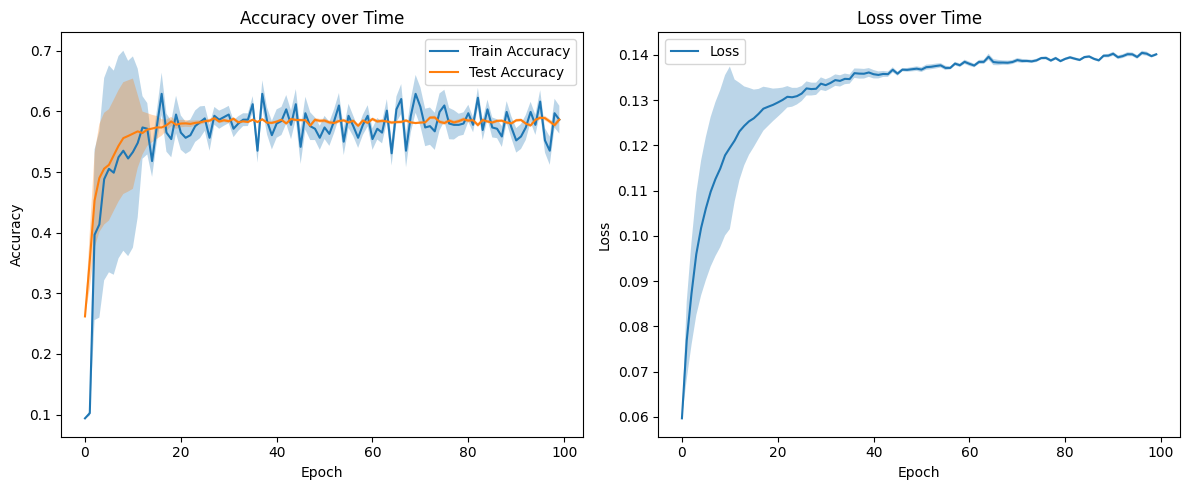

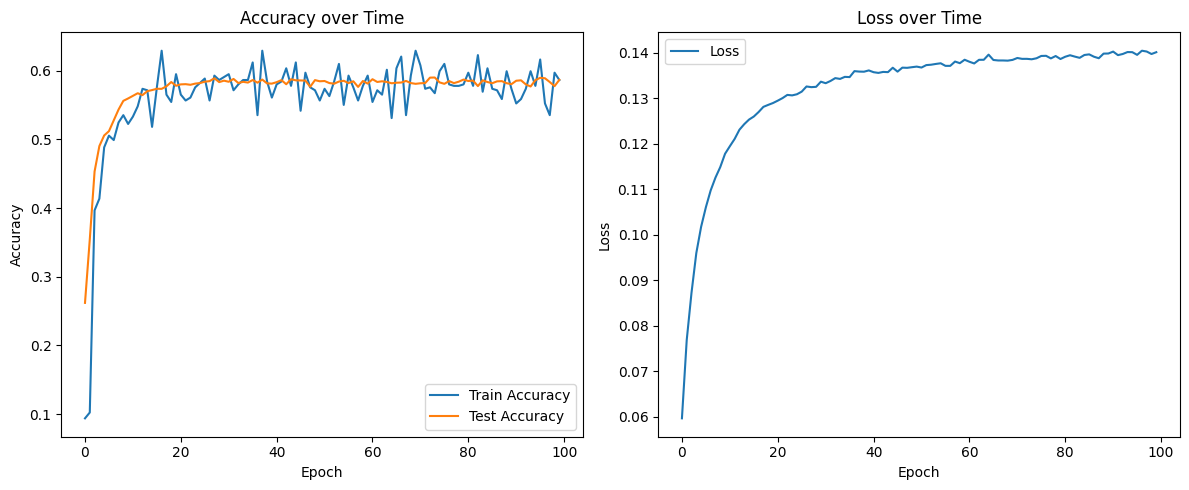

Final Train Accuracy: 0.59 ± 0.02
Final Test Accuracy: 0.59 ± 0.00
bernoulli - Final Train Accuracy: 0.47 ± 0.04
bernoulli - Final Test Accuracy: 0.44 ± 0.00
gumbel_softmax - Final Train Accuracy: 0.13 ± 0.01
gumbel_softmax - Final Test Accuracy: 0.14 ± 0.00
gaussian - Final Train Accuracy: 0.16 ± 0.01
gaussian - Final Test Accuracy: 0.16 ± 0.00
beta - Final Train Accuracy: 0.66 ± 0.02
beta - Final Test Accuracy: 0.64 ± 0.00
dirichlet - Final Train Accuracy: 0.16 ± 0.02
dirichlet - Final Test Accuracy: 0.18 ± 0.00
multinomial - Final Train Accuracy: 0.13 ± 0.01
multinomial - Final Test Accuracy: 0.12 ± 0.00
cauchy - Final Train Accuracy: 0.10 ± 0.02
cauchy - Final Test Accuracy: 0.11 ± 0.00
laplace - Final Train Accuracy: 0.17 ± 0.02
laplace - Final Test Accuracy: 0.14 ± 0.00
uniform - Final Train Accuracy: 0.59 ± 0.02
uniform - Final Test Accuracy: 0.59 ± 0.00


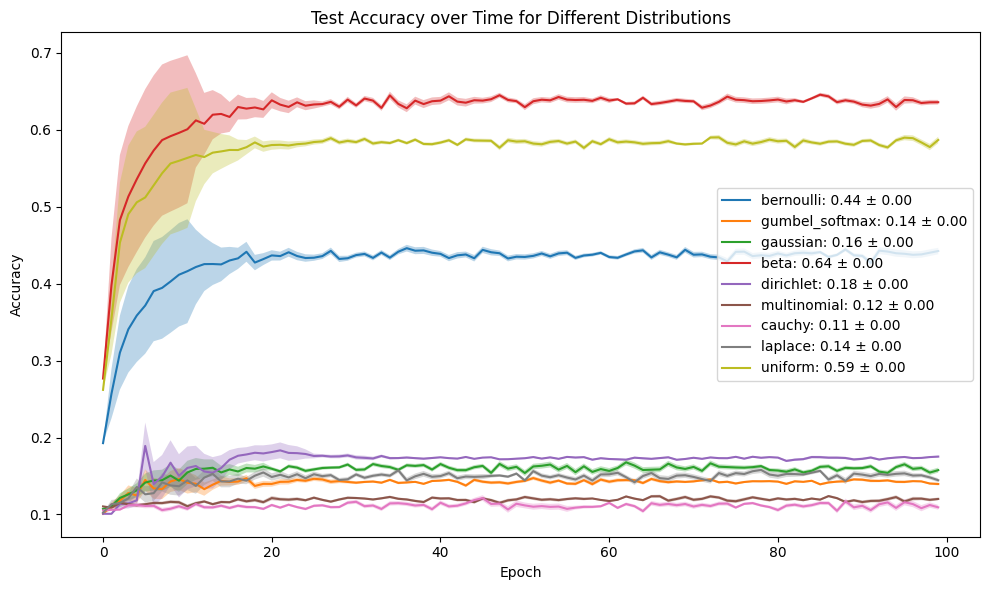

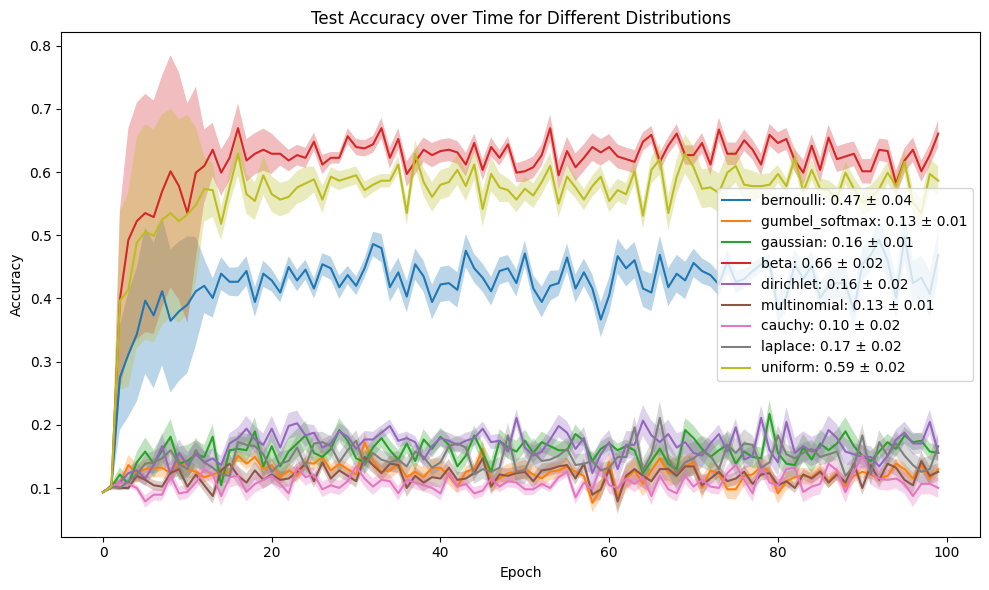

In [6]:


import csv
import numpy as np
import matplotlib.pyplot as plt

# List of distributions to iterate over
distributions = ["bernoulli", "gumbel_softmax", "gaussian", "beta", "dirichlet", "multinomial", "cauchy", "laplace", "uniform"]

# Configuration
config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.8,
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "width": 32,
    "grid": 3,
    "method": "MLP",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 4,
    "num_conv_layers": 2,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "initial_tau": 1.0, # positive float value
}

# Function to run kanRL and collect results
def run_experiment(distribution):
    config["distribution"] = distribution
    q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

    return train_accuracies, test_accuracies, losses, train_acc_stds, test_acc_stds, loss_stds

# Initialize results dictionary
results = {dist: {} for dist in distributions}

# Run experiments for each distribution
for distribution in distributions:
    train_accuracies, test_accuracies, losses, train_acc_stds, test_acc_stds, loss_stds = run_experiment(distribution)

    results[distribution]['train_accuracies'] = train_accuracies
    results[distribution]['test_accuracies'] = test_accuracies
    results[distribution]['losses'] = losses
    results[distribution]['train_acc_stds'] = train_acc_stds
    results[distribution]['test_acc_stds'] = test_acc_stds
    results[distribution]['loss_stds'] = loss_stds

    # Save train accuracies and stds
    with open(f'MLP_{distribution}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Epoch', 'Train Accuracy', 'Train Accuracy Std', 'Test Accuracy', 'Test Accuracy Std', 'Loss', 'Loss Std'])
        for epoch, (train_acc, train_acc_std, test_acc, test_acc_std, loss, loss_std) in enumerate(zip(train_accuracies, train_acc_stds, test_accuracies, test_acc_stds, losses, loss_stds)):
            writer.writerow([epoch, train_acc, train_acc_std, test_acc, test_acc_std, loss, loss_std])


# Print final accuracies with +/- errors for each distribution
for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]

    print(f"{distribution} - Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
    print(f"{distribution} - Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")



# Plotting: Test accuracy
epochs = np.arange(config["n_epochs"])

plt.figure(figsize=(10, 6))

for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]
    plt.plot(epochs, results[distribution]['test_accuracies'], label=f'{distribution}: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}')
    plt.fill_between(epochs, np.array(results[distribution]['test_accuracies']) - np.array(results[distribution]['test_acc_stds']),
                     np.array(results[distribution]['test_accuracies']) + np.array(results[distribution]['test_acc_stds']), alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy over Time for Different Distributions')

plt.tight_layout()
plt.savefig('MLP_test_comparison_plot.png', dpi=300)
plt.show()


# Plotting: Train accuracy
epochs = np.arange(config["n_epochs"])

plt.figure(figsize=(10, 6))

for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]
    plt.plot(epochs, results[distribution]['train_accuracies'], label=f'{distribution}: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}')
    plt.fill_between(epochs, np.array(results[distribution]['train_accuracies']) - np.array(results[distribution]['train_acc_stds']),
                     np.array(results[distribution]['train_accuracies']) + np.array(results[distribution]['train_acc_stds']), alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy over Time for Different Distributions')

plt.tight_layout()
plt.savefig('MLP_train_comparison_plot.png', dpi=300)
plt.show()




bernoulli - Final Train Accuracy: 0.89 ± 0.01\
bernoulli - Final Test Accuracy: 0.90 ± 0.00\
gumbel_softmax - Final Train Accuracy: 0.12 ± 0.01\
gumbel_softmax - Final Test Accuracy: 0.13 ± 0.01\
gaussian - Final Train Accuracy: 0.35 ± 0.02\
gaussian - Final Test Accuracy: 0.31 ± 0.01\
beta - Final Train Accuracy: 0.95 ± 0.01\
beta - Final Test Accuracy: 0.94 ± 0.00\
dirichlet - Final Train Accuracy: 0.21 ± 0.01\
dirichlet - Final Test Accuracy: 0.21 ± 0.00\
multinomial - Final Train Accuracy: 0.09 ± 0.01\
multinomial - Final Test Accuracy: 0.12 ± 0.01\
cauchy - Final Train Accuracy: 0.13 ± 0.02\
cauchy - Final Test Accuracy: 0.12 ± 0.01\
laplace - Final Train Accuracy: 0.28 ± 0.03\
laplace - Final Test Accuracy: 0.28 ± 0.01\
uniform - Final Train Accuracy: 0.94 ± 0.01\
uniform - Final Test Accuracy: 0.93 ± 0.00